# 10_Experiment_2 

The main file for experiment 2. It is an adaption from the 07 files. 

The labels are split by country and in a later step put back together for the leave-one-out strategy. 

In [3]:
## same install functions as always

!pip install pyyaml==5.1
#!pip uninstall torch
!yes | pip uninstall detectron2
#!pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
    
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Found existing installation: detectron2 0.6+cu111
Uninstalling detectron2-0.6+cu111:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/detectron2-0.6+cu111.dist-info/*
    /usr/local/lib/python3.8/dist-packages/detectron2/*
    /usr/local/lib/python3.8/dist-packages/tools/*
Proceed (y/n)?   Successfully uninstalled detectron2-0.6+cu111
yes: standard output: Broken pipe
Looking in links: https://download.pytorch.org/whl/torch_stable.html
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html
  Using cached https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/detectron2-0.6%2Bcu111-cp38-cp38-linux_x86_64.whl (6.9 MB)


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [5]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.9 ; cuda:  cu111
detectron2: 0.6


In [71]:
#!pip install datetime

In [6]:
import os
import sys

In [73]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [7]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.data import build_detection_train_loader
from detectron2.data import DatasetMapper
from detectron2.data import DatasetCatalog

from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer

from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer


In [8]:
import json
from datetime import datetime

In [76]:
# Error Message while training: module 'distutils' has no attribute 'version'
#!python3 -m pip install setuptools==58.2.0
# then restart the kernel

In [77]:
## Function to register our datasets 
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_name_train = "thesis_030_train"
dataset_name_val = "thesis_030_val"

def register(name, path_labels, path_data):

    # Check if dataset name already exists in catalog
    if name in DatasetCatalog.list():
        
        # Remove existing dataset from catalog
        DatasetCatalog.remove(name)
        MetadataCatalog.remove(name)

    # Register your dataset using register_coco_instances
    register_coco_instances(name, {}, path_labels, path_data)

In [78]:
base_path = "/workspace/scripts"

os.chdir(base_path)

In [79]:
# Taken from https://eidos-ai.medium.com/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
# https://gist.github.com/ortegatron/c0dad15e49c2b74de8bb09a5615d9f6b

from EvalLossHook import LossEvalHook
from detectron2.engine import BestCheckpointer
from detectron2.checkpoint import DetectionCheckpointer

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.data import build_detection_train_loader
from torch.utils.data.sampler import Sampler


from detectron2.data.samplers import (
    InferenceSampler,
    RandomSubsetTrainingSampler,
    RepeatFactorTrainingSampler,
    TrainingSampler,
)

## Adapted the MyTrainer from Experiment 1 to add a maximum number of images that can be sampled
class MyTrainer_sampled(DefaultTrainer):
        
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            self.cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        
        # add the best checkpointer hook
        # adapted from https://www.kaggle.com/c/sartorius-cell-instance-segmentation/discussion/287023
        hooks.insert(-1, BestCheckpointer(self.cfg.TEST.EVAL_PERIOD, 
                                         DetectionCheckpointer(self.model, self.cfg.OUTPUT_DIR),
                                         "bbox/AP50",
                                         "max",
                                         "best_ap50"
                                         ))
        return hooks

    def build_train_loader(cls, cfg):
        sampler = TrainingSampler(1500) # Change the number of seen images here. 
        #This generates and index of files that the trainer sees.
        
        return build_detection_train_loader(cfg, sampler = sampler)
 


## Modify the train detection function to include training on individual countries

In [97]:
#from detectron2.utils.comm import create_local_process_group # show the import here as reference 

def train_detectron_countries(config_dict = None, 
                         default_dict = None,
                         resolution = "res_missing",
                         output_dir_prefix = None,
                         dataset_name_train = '030_train',
                        dataset_name_val = '030_val',
                        country = None
                        ):
    
    """
    This docstring was created by chatGPT. The function is ours. 
    Trains a Detectron2 model for object detection on a specific country's dataset.

    Parameters
    ----------
    config_dict : dict, optional
        Dictionary with configuration parameters to override the default_dict values.
    default_dict : dict, optional
        Dictionary with default values for configuration parameters. If not provided, the function will use these default values:
        {
            'eval_period': None,
            'learning_rate': 0.001,
            'batch_size': 8,
            'anchors': [[4, 8, 16, 32, 64]],
            'weight_decay': 0.0001,
            'solver_steps_divider': 10,
            'freeze_at': 2,
            'gradient_clipping': False
        }
    resolution : str, optional
        Resolution of the images in the dataset (e.g. "60-90"). Default is "res_missing".
    output_dir_prefix : str, optional
        Prefix for the output directory where the trained model will be saved. Default is None, in which case the prefix will be "res{resolution}_<current_time>".
    dataset_name_train : str, optional
        Name of the training dataset. Default is "030_train".
    dataset_name_val : str, optional
        Name of the validation dataset. Default is "030_val".
    country : str, required
        Name of the country to train the model on. This parameter is required.

    Returns
    -------
    Tuple with the following elements:
    - cfg: Detectron2 CfgNode with the model's configuration.
    - trainer: Detectron2 trainer object used for training the model.
    - predictor: Detectron2 predictor object used for making predictions with the trained model.

    If the `country` parameter is None, the function returns the string "You did not pass a country".
    """
    
    if country is None:
        return "You did not pass a country"

    if config_dict is None:
        config_dict = {}
    if default_dict is None:
        default_dict = {
            'eval_period': None,
            'learning_rate': 0.001,
            'batch_size': 8,
            'anchors': [[4, 8, 16, 32, 64]],
            'weight_decay': 0.0001,
            'solver_steps_divider': 10,
            'freeze_at': 2,
            'gradient_clipping': False}

    # Merge default_dict with my_dict, overriding any duplicate keys
    config = {**default_dict, **config_dict}
    
    print(config)
    
    register(dataset_name_train, f"/workspace/data/countries/train_{country}_labels.json", f"/workspace/data/data_{resolution}_mexico_60-90/train/data")
    register(dataset_name_val, f"/workspace/data/countries/test_{country}_labels.json",  f"/workspace/data/data_{resolution}_mexico_60-90/test/data")
    
    
    if output_dir_prefix:
        now = datetime.now() 
        output_dir = f"/workspace/output/{output_dir_prefix}/{country}"
    else:
        now = datetime.now() 
        output_dir = f"/workspace/output/res{resolution}_{now.strftime('%m.%d.%H.%M')}"
        
    #create_local_process_group(num_workers_per_machine=2)
    
    # batchsize * iterations
    views = 50000
    
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
    cfg.INPUT.FORMAT = "RGB"
    
    cfg.OUTPUT_DIR = output_dir
    print("Output Dir:", cfg.OUTPUT_DIR)
    cfg.DATASETS.TRAIN = (dataset_name_train)
    cfg.DATASETS.TEST = (dataset_name_val,)
    cfg.DATASETS.EVAL = (dataset_name_val,)
    
    cfg.DATALOADER.SAMPLER_TRAIN = "TrainingSampler"

    cfg.DATALOADER.SEED = 42

    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.ANCHOR_GENERATOR.SIZES = config['anchors']
    cfg.SOLVER.MAX_ITER = round(views/config['batch_size'])
    cfg.TEST.EVAL_PERIOD = cfg.SOLVER.MAX_ITER / 20 # für unseren Evaluator

    cfg.SOLVER.IMS_PER_BATCH = config['batch_size']
    cfg.SOLVER.BASE_LR = config['learning_rate']
    cfg.SOLVER.WEIGHT_DECAY = config['weight_decay']
    cfg.SOLVER.CLIP_GRADIENTS.ENABLED = config['gradient_clipping']
    cfg.SOLVER.STEPS = [.5*cfg.SOLVER.MAX_ITER, .75*cfg.SOLVER.MAX_ITER, .9*cfg.SOLVER.MAX_ITER]
    #print(cfg.SOLVER.STEPS)
    
    cfg.MODEL.BACKBONE.FREEZE_AT = config['freeze_at']
      
    
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
    cfg.TEST.DETECTIONS_PER_IMAGE = 30

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    
    trainer = MyTrainer_sampled(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()
    
    
    predictor = DefaultPredictor(cfg)
    
    return cfg, trainer, predictor

In [9]:
import random as rd
import itertools

# Function to load jsons to arrays
def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines


## Cross Country Comparison

- build function to extract labels from just one country
- build function to evaluate the model on different countries (change eval hook)

In [99]:
def labels_by_country(labels_file: str, location_dict: dict, mode = 'train') -> None:
    """
    Splits a COCO-formatted labels file into separate files for each location based on the
    first two characters of the file path. Writes out one new labels file for each location.

    Args:
        labels_file (str): The path to the COCO-formatted labels file to be split.
        location_dict (dict): A dictionary mapping location names to the two-letter codes at
                              the beginning of the file paths.

    Returns:
        None.
    """
    
    
    with open(labels_file, 'r') as f:
        coco_labels = json.load(f)
    
    # Create a dictionary to store the labels for each location
    location_labels = {}
    for location in location_dict.keys():
        location_labels[location_dict[location]] = {"info": coco_labels["info"], "images": [], "annotations": [], "categories": coco_labels["categories"]}
    
    print(location_labels)
    # Iterate over the images and annotations, and add them to the appropriate location
    for image in coco_labels["images"]:
        location = location_dict[image["file_name"][:2]]
        location_labels[location]["images"].append(image)
        
        # Find the annotations for this image and add them to the appropriate location
        image_annotations = [ann for ann in coco_labels["annotations"] if ann["image_id"] == image["id"]]
        for annotation in image_annotations:
            location_labels[location]["annotations"].append(annotation)
    
    if not os.path.exists(f"/workspace/data/countries/"):
        os.mkdir(f"/workspace/data/countries/")
    # Write out the labels for each location
    for location, location_label in location_labels.items():
        location_filename = f"/workspace/data/countries/{mode}_{location}_labels.json"
        with open(location_filename, 'w') as f:
            json.dump(location_label, f) 

In [100]:
# define a dictionary going from the individual locations to whole countries
location_mapping = {'AR': 'USA',
 'CH': 'China', 
 'CL': 'USA', 
 'DU': 'NZ', 
 'GI': 'NZ', 
 'KA': 'USA', 
 'ME': 'Mexico', 
 'PA': 'NZ', 
 'RO': 'NZ', 
 'SU': 'Sudan', 
 'TA': 'NZ', 
 'WI': 'USA'}


# rearrange the labels by country
# Uncomment the next lines to generate the new labels
#labels_by_country("/workspace/data/labels_train_DT.json",location_mapping, 'train')

In [101]:
#labels_by_country("/workspace/data/labels_val_DT.json", location_mapping, 'val')

In [102]:
#labels_by_country("/workspace/data/labels_test_DT.json", location_mapping, 'test')

### Main loop to run experiments for individual countries

In [ ]:

for country in ['Mexico']:#,'NZ', 'USA', 'Sudan']:

    print("------ Training on Data from: ", country, "----------")
    config1 = {'learning_rate': 0.001, 
              'batch_size': 5, 
              'gradient_clipping': True, 
              'weight_decay': 0.001, 
              'freeze_at': 1, 
              'index': 8}

    now = datetime.now()
    output_dir_prefix = f"experiment2_{country}_{now.strftime('%m.%d.%H.%M')}"


    if not os.path.exists(f'/workspace/output/{output_dir_prefix}'):
        os.mkdir(f'/workspace/output/{output_dir_prefix}')


    cfg_mex, trainer_mex, predictor_mex = train_detectron_countries(config1, 
                                resolution = '030',
                                output_dir_prefix = output_dir_prefix,
                                dataset_name_train = '030_train',
                                dataset_name_val = '030_val',
                                country = country)

------ Training on Data from:  Mexico ----------
{'eval_period': None, 'learning_rate': 0.001, 'batch_size': 5, 'anchors': [[4, 8, 16, 32, 64]], 'weight_decay': 0.001, 'solver_steps_divider': 10, 'freeze_at': 1, 'gradient_clipping': True, 'index': 8}
Output Dir: /workspace/output/experiment2_Mexico_04.22.11.16/Mexico
[04/22 11:16:24 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3

WARNING [04/22 11:16:24 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/22 11:16:24 d2.data.datasets.coco]: Loaded 2079 images in COCO format from /workspace/data/countries/train_Mexico_labels.json
[04/22 11:16:24 d2.data.build]: Removed 0 images with no usable annotations. 2079 images left.
[04/22 11:16:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/22 11:16:24 d2.data.common]: Serializing 2079 elements to byte tensors and concatenating them all ...
[04/22 11:16:24 d2.data.common]: Serialized dataset takes 0.92 MiB
[04/22 11:16:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/22 11:16:24 d2.data.datasets

[04/22 11:16:24 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[04/22 11:16:24 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint       | Shapes                                          |
|:------------------|:--------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2_0_branch2b_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2_0_branch2c_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.shortcut.* | res2_0_branch1_{bn_*,w}   | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,256,1,1)            |
| res2.1.conv2.*    | res2_1_branch2b_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.1.c

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}


[04/22 11:16:24 d2.engine.train_loop]: Starting training from iteration 0
[04/22 11:16:30 d2.utils.events]:  eta: 0:48:08  iter: 19  total_loss: 1.246  loss_cls: 0.4672  loss_box_reg: 0.006741  loss_rpn_cls: 0.6851  loss_rpn_loc: 0.06543  time: 0.2803  data_time: 0.0359  lr: 1.9981e-05  max_mem: 7150M
[04/22 11:16:36 d2.utils.events]:  eta: 0:47:41  iter: 39  total_loss: 0.8075  loss_cls: 0.04247  loss_box_reg: 0.005086  loss_rpn_cls: 0.6785  loss_rpn_loc: 0.07522  time: 0.2761  data_time: 0.0278  lr: 3.9961e-05  max_mem: 7150M
[04/22 11:16:41 d2.utils.events]:  eta: 0:47:19  iter: 59  total_loss: 0.7692  loss_cls: 0.04086  loss_box_reg: 0.00367  loss_rpn_cls: 0.6635  loss_rpn_loc: 0.05574  time: 0.2759  data_time: 0.0280  lr: 5.9941e-05  max_mem: 7150M
[04/22 11:16:47 d2.utils.events]:  eta: 0:47:14  iter: 79  total_loss: 0.7472  loss_cls: 0.04826  loss_box_reg: 0.006668  loss_rpn_cls: 0.6384  loss_rpn_loc: 0.05512  time: 0.2769  data_time: 0.0267  lr: 7.9921e-05  max_mem: 7150M
[04/2

[04/22 11:19:23 d2.evaluation.coco_evaluation]: Saving results to /workspace/output/experiment2_Mexico_04.22.11.16/Mexico/inference/coco_instances_results.json
[04/22 11:19:23 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.23s)
creating index...
index created!
[04/22 11:19:23 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[04/22 11:19:23 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.17 seconds.
[04/22 11:19:23 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[04/22 11:19:23 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.04 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.020
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1

[04/22 11:22:23 d2.utils.events]:  eta: 0:43:44  iter: 959  total_loss: 0.7208  loss_cls: 0.256  loss_box_reg: 0.3487  loss_rpn_cls: 0.05503  loss_rpn_loc: 0.03916  validation_loss: 0.7456  time: 0.2809  data_time: 0.0271  lr: 0.00095904  max_mem: 7150M
[04/22 11:22:28 d2.utils.events]:  eta: 0:43:38  iter: 979  total_loss: 0.6341  loss_cls: 0.2421  loss_box_reg: 0.3199  loss_rpn_cls: 0.0506  loss_rpn_loc: 0.03745  validation_loss: 0.7456  time: 0.2806  data_time: 0.0287  lr: 0.00097902  max_mem: 7150M
WARNING [04/22 11:22:33 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/22 11:22:33 d2.data.datasets.coco]: Loaded 1043 images in COCO format from /workspace/data/countries/test_Mexico_labels.json
[04/22 11:22:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/22 11:22:34 d2.data.common]: Serializing 1

[04/22 11:25:04 d2.utils.events]:  eta: 0:42:37  iter: 1219  total_loss: 0.6825  loss_cls: 0.2417  loss_box_reg: 0.3556  loss_rpn_cls: 0.04228  loss_rpn_loc: 0.02908  validation_loss: 0.8826  time: 0.2808  data_time: 0.0273  lr: 0.001  max_mem: 7150M
[04/22 11:25:10 d2.utils.events]:  eta: 0:42:31  iter: 1239  total_loss: 0.7404  loss_cls: 0.2796  loss_box_reg: 0.3788  loss_rpn_cls: 0.03249  loss_rpn_loc: 0.03812  validation_loss: 0.8826  time: 0.2808  data_time: 0.0274  lr: 0.001  max_mem: 7150M
[04/22 11:25:16 d2.utils.events]:  eta: 0:42:25  iter: 1259  total_loss: 0.694  loss_cls: 0.2567  loss_box_reg: 0.3481  loss_rpn_cls: 0.03951  loss_rpn_loc: 0.03931  validation_loss: 0.8826  time: 0.2809  data_time: 0.0278  lr: 0.001  max_mem: 7150M
[04/22 11:25:21 d2.utils.events]:  eta: 0:42:18  iter: 1279  total_loss: 0.6553  loss_cls: 0.2547  loss_box_reg: 0.3532  loss_rpn_cls: 0.03579  loss_rpn_loc: 0.0377  validation_loss: 0.8826  time: 0.2810  data_time: 0.0264  lr: 0.001  max_mem: 7150

[04/22 11:27:01 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/22 11:27:01 d2.evaluation.testing]: copypaste: 0.3888,2.0586,0.0151,0.4114,0.9783,nan
[04/22 11:27:51 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 2.05862, not better than best score 3.21328 @ iteration 999.
[04/22 11:27:51 d2.utils.events]:  eta: 0:41:11  iter: 1499  total_loss: 0.686  loss_cls: 0.2611  loss_box_reg: 0.3672  loss_rpn_cls: 0.03441  loss_rpn_loc: 0.03491  validation_loss: 1.02  time: 0.2809  data_time: 0.0261  lr: 0.001  max_mem: 7150M
[04/22 11:27:56 d2.utils.events]:  eta: 0:41:04  iter: 1519  total_loss: 0.6981  loss_cls: 0.2458  loss_box_reg: 0.3581  loss_rpn_cls: 0.0264  loss_rpn_loc: 0.03515  validation_loss: 1.02  time: 0.2808  data_time: 0.0280  lr: 0.001  max_mem: 7150M
[04/22 11:28:02 d2.utils.events]:  eta: 0:40:57  iter: 1539  total_loss: 0.6848  loss_cls: 0.2448  loss_box_reg: 0.372  loss_rpn_cls: 0.03451  loss_rpn_loc: 0.03289  validation_loss: 1.02  time:

[04/22 11:30:38 d2.evaluation.evaluator]: Inference done 689/1043. Dataloading: 0.0010 s/iter. Inference: 0.0358 s/iter. Eval: 0.0002 s/iter. Total: 0.0370 s/iter. ETA=0:00:13
[04/22 11:30:43 d2.evaluation.evaluator]: Inference done 829/1043. Dataloading: 0.0010 s/iter. Inference: 0.0357 s/iter. Eval: 0.0002 s/iter. Total: 0.0368 s/iter. ETA=0:00:07
[04/22 11:30:48 d2.evaluation.evaluator]: Inference done 966/1043. Dataloading: 0.0010 s/iter. Inference: 0.0356 s/iter. Eval: 0.0002 s/iter. Total: 0.0368 s/iter. ETA=0:00:02
[04/22 11:30:50 d2.evaluation.evaluator]: Total inference time: 0:00:38.254014 (0.036854 s / iter per device, on 1 devices)
[04/22 11:30:50 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.035592 s / iter per device, on 1 devices)
[04/22 11:30:51 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/22 11:30:51 d2.evaluation.coco_evaluation]: Saving results to /workspace/output/experiment2_Mexico_04.22.11.16/Mexico/inference/

[04/22 11:33:34 d2.utils.events]:  eta: 0:36:57  iter: 2399  total_loss: 0.6344  loss_cls: 0.2314  loss_box_reg: 0.3429  loss_rpn_cls: 0.0232  loss_rpn_loc: 0.02808  validation_loss: 1.057  time: 0.2816  data_time: 0.0270  lr: 0.001  max_mem: 7150M
[04/22 11:33:40 d2.utils.events]:  eta: 0:36:51  iter: 2419  total_loss: 0.6837  loss_cls: 0.2379  loss_box_reg: 0.375  loss_rpn_cls: 0.02108  loss_rpn_loc: 0.0256  validation_loss: 1.057  time: 0.2816  data_time: 0.0261  lr: 0.001  max_mem: 7150M
[04/22 11:33:45 d2.utils.events]:  eta: 0:36:44  iter: 2439  total_loss: 0.7164  loss_cls: 0.2548  loss_box_reg: 0.4106  loss_rpn_cls: 0.02625  loss_rpn_loc: 0.0279  validation_loss: 1.057  time: 0.2815  data_time: 0.0259  lr: 0.001  max_mem: 7150M
[04/22 11:33:51 d2.utils.events]:  eta: 0:36:38  iter: 2459  total_loss: 0.747  loss_cls: 0.2501  loss_box_reg: 0.4345  loss_rpn_cls: 0.02088  loss_rpn_loc: 0.0391  validation_loss: 1.057  time: 0.2815  data_time: 0.0257  lr: 0.001  max_mem: 7150M
[04/22

[04/22 11:36:14 d2.utils.events]:  eta: 0:35:37  iter: 2659  total_loss: 0.6852  loss_cls: 0.2307  loss_box_reg: 0.3827  loss_rpn_cls: 0.02776  loss_rpn_loc: 0.03338  validation_loss: 1.095  time: 0.2816  data_time: 0.0271  lr: 0.001  max_mem: 7150M
[04/22 11:36:20 d2.utils.events]:  eta: 0:35:32  iter: 2679  total_loss: 0.6348  loss_cls: 0.2276  loss_box_reg: 0.3497  loss_rpn_cls: 0.01686  loss_rpn_loc: 0.03315  validation_loss: 1.095  time: 0.2815  data_time: 0.0272  lr: 0.001  max_mem: 7150M
[04/22 11:36:26 d2.utils.events]:  eta: 0:35:27  iter: 2699  total_loss: 0.6458  loss_cls: 0.2414  loss_box_reg: 0.3736  loss_rpn_cls: 0.01677  loss_rpn_loc: 0.02817  validation_loss: 1.095  time: 0.2816  data_time: 0.0277  lr: 0.001  max_mem: 7150M
[04/22 11:36:31 d2.utils.events]:  eta: 0:35:21  iter: 2719  total_loss: 0.6011  loss_cls: 0.2097  loss_box_reg: 0.3376  loss_rpn_cls: 0.02401  loss_rpn_loc: 0.02513  validation_loss: 1.095  time: 0.2815  data_time: 0.0273  lr: 0.001  max_mem: 7150M


[04/22 11:38:27 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[04/22 11:38:27 d2.engine.defaults]: Evaluation results for 030_val in csv format:
[04/22 11:38:27 d2.evaluation.testing]: copypaste: Task: bbox
[04/22 11:38:27 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/22 11:38:27 d2.evaluation.testing]: copypaste: 1.1657,4.7279,0.5061,1.1057,2.2342,nan
[04/22 11:39:16 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 4.72785, not better than best score 5.48413 @ iteration 1999.
[04/22 11:39:17 d2.utils.events]:  eta: 0:33:55  iter: 2999  total_loss: 0.6859  loss_cls: 0.2408  loss_box_reg: 0.3966  loss_rpn_cls: 0.02473  loss_rpn_loc: 0.02898  validation_loss: 1.129  time: 0.2812  data_time: 0.0277  lr: 0.001  max_mem: 7150M
[04/22 11:39:22 d2.utils.events]:  eta: 0:33:49  iter: 3019  total_loss: 0.715  loss_cls: 0.2462  loss_box_reg: 0.3958  loss_rpn_cls: 0.02037  loss_rpn_loc: 0.03175  validation_loss: 1.129  tim

[04/22 11:41:57 d2.evaluation.evaluator]: Inference done 580/1043. Dataloading: 0.0009 s/iter. Inference: 0.0342 s/iter. Eval: 0.0001 s/iter. Total: 0.0354 s/iter. ETA=0:00:16
[04/22 11:42:02 d2.evaluation.evaluator]: Inference done 720/1043. Dataloading: 0.0009 s/iter. Inference: 0.0343 s/iter. Eval: 0.0001 s/iter. Total: 0.0354 s/iter. ETA=0:00:11
[04/22 11:42:07 d2.evaluation.evaluator]: Inference done 859/1043. Dataloading: 0.0009 s/iter. Inference: 0.0344 s/iter. Eval: 0.0001 s/iter. Total: 0.0356 s/iter. ETA=0:00:06
[04/22 11:42:12 d2.evaluation.evaluator]: Inference done 998/1043. Dataloading: 0.0009 s/iter. Inference: 0.0345 s/iter. Eval: 0.0001 s/iter. Total: 0.0356 s/iter. ETA=0:00:01
[04/22 11:42:14 d2.evaluation.evaluator]: Total inference time: 0:00:37.086299 (0.035729 s / iter per device, on 1 devices)
[04/22 11:42:14 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:35 (0.034527 s / iter per device, on 1 devices)
[04/22 11:42:14 d2.evaluation.coco_evaluat

[04/22 11:44:51 d2.utils.events]:  eta: 0:29:32  iter: 3879  total_loss: 0.6134  loss_cls: 0.1967  loss_box_reg: 0.3459  loss_rpn_cls: 0.0159  loss_rpn_loc: 0.0248  validation_loss: 1.162  time: 0.2811  data_time: 0.0277  lr: 0.001  max_mem: 7150M
[04/22 11:44:56 d2.utils.events]:  eta: 0:29:26  iter: 3899  total_loss: 0.6492  loss_cls: 0.214  loss_box_reg: 0.3838  loss_rpn_cls: 0.01559  loss_rpn_loc: 0.02674  validation_loss: 1.162  time: 0.2810  data_time: 0.0293  lr: 0.001  max_mem: 7150M
[04/22 11:45:02 d2.utils.events]:  eta: 0:29:20  iter: 3919  total_loss: 0.626  loss_cls: 0.2109  loss_box_reg: 0.3748  loss_rpn_cls: 0.01241  loss_rpn_loc: 0.02369  validation_loss: 1.162  time: 0.2810  data_time: 0.0274  lr: 0.001  max_mem: 7150M
[04/22 11:45:08 d2.utils.events]:  eta: 0:29:14  iter: 3939  total_loss: 0.6198  loss_cls: 0.2166  loss_box_reg: 0.3593  loss_rpn_cls: 0.01589  loss_rpn_loc: 0.03029  validation_loss: 1.162  time: 0.2811  data_time: 0.0286  lr: 0.001  max_mem: 7150M
[04/

[04/22 11:47:29 d2.utils.events]:  eta: 0:28:16  iter: 4139  total_loss: 0.6242  loss_cls: 0.2058  loss_box_reg: 0.3695  loss_rpn_cls: 0.01319  loss_rpn_loc: 0.02353  validation_loss: 1.171  time: 0.2809  data_time: 0.0299  lr: 0.001  max_mem: 7150M
[04/22 11:47:35 d2.utils.events]:  eta: 0:28:11  iter: 4159  total_loss: 0.5739  loss_cls: 0.1957  loss_box_reg: 0.3388  loss_rpn_cls: 0.01239  loss_rpn_loc: 0.02455  validation_loss: 1.171  time: 0.2809  data_time: 0.0277  lr: 0.001  max_mem: 7150M
[04/22 11:47:41 d2.utils.events]:  eta: 0:28:05  iter: 4179  total_loss: 0.5707  loss_cls: 0.1883  loss_box_reg: 0.3245  loss_rpn_cls: 0.01224  loss_rpn_loc: 0.02893  validation_loss: 1.171  time: 0.2809  data_time: 0.0275  lr: 0.001  max_mem: 7150M
[04/22 11:47:46 d2.utils.events]:  eta: 0:27:59  iter: 4199  total_loss: 0.6082  loss_cls: 0.1913  loss_box_reg: 0.3543  loss_rpn_cls: 0.0139  loss_rpn_loc: 0.02642  validation_loss: 1.171  time: 0.2809  data_time: 0.0293  lr: 0.001  max_mem: 7150M
[

[04/22 11:49:48 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[04/22 11:49:48 d2.engine.defaults]: Evaluation results for 030_val in csv format:
[04/22 11:49:48 d2.evaluation.testing]: copypaste: Task: bbox
[04/22 11:49:48 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/22 11:49:48 d2.evaluation.testing]: copypaste: 1.2712,4.5869,1.0044,1.2191,1.8995,nan
[04/22 11:50:37 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 4.58686, not better than best score 5.48413 @ iteration 1999.
[04/22 11:50:37 d2.utils.events]:  eta: 0:26:34  iter: 4499  total_loss: 0.6245  loss_cls: 0.2047  loss_box_reg: 0.3728  loss_rpn_cls: 0.01657  loss_rpn_loc: 0.02421  validation_loss: 1.18  time: 0.2809  data_time: 0.0279  lr: 0.001  max_mem: 7150M
[04/22 11:50:43 d2.utils.events]:  eta: 0:26:27  iter: 4519  total_loss: 0.6193  loss_cls: 0.2048  loss_box_reg: 0.3723  loss_rpn_cls: 0.00994  loss_rpn_loc: 0.02251  validation_loss: 1.18  time

[04/22 11:53:19 d2.evaluation.evaluator]: Inference done 558/1043. Dataloading: 0.0010 s/iter. Inference: 0.0355 s/iter. Eval: 0.0001 s/iter. Total: 0.0367 s/iter. ETA=0:00:17
[04/22 11:53:24 d2.evaluation.evaluator]: Inference done 697/1043. Dataloading: 0.0010 s/iter. Inference: 0.0354 s/iter. Eval: 0.0001 s/iter. Total: 0.0366 s/iter. ETA=0:00:12
[04/22 11:53:29 d2.evaluation.evaluator]: Inference done 841/1043. Dataloading: 0.0010 s/iter. Inference: 0.0352 s/iter. Eval: 0.0001 s/iter. Total: 0.0363 s/iter. ETA=0:00:07
[04/22 11:53:34 d2.evaluation.evaluator]: Inference done 985/1043. Dataloading: 0.0009 s/iter. Inference: 0.0350 s/iter. Eval: 0.0001 s/iter. Total: 0.0361 s/iter. ETA=0:00:02
[04/22 11:53:36 d2.evaluation.evaluator]: Total inference time: 0:00:37.476369 (0.036104 s / iter per device, on 1 devices)
[04/22 11:53:36 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:36 (0.034916 s / iter per device, on 1 devices)
[04/22 11:53:36 d2.evaluation.coco_evaluat

[04/22 11:56:12 d2.utils.events]:  eta: 0:22:17  iter: 5379  total_loss: 0.4794  loss_cls: 0.1621  loss_box_reg: 0.2903  loss_rpn_cls: 0.008894  loss_rpn_loc: 0.02121  validation_loss: 1.186  time: 0.2808  data_time: 0.0270  lr: 0.0001  max_mem: 7150M
[04/22 11:56:17 d2.utils.events]:  eta: 0:22:11  iter: 5399  total_loss: 0.4588  loss_cls: 0.1446  loss_box_reg: 0.2674  loss_rpn_cls: 0.01037  loss_rpn_loc: 0.02597  validation_loss: 1.186  time: 0.2808  data_time: 0.0286  lr: 0.0001  max_mem: 7150M
[04/22 11:56:23 d2.utils.events]:  eta: 0:22:06  iter: 5419  total_loss: 0.4955  loss_cls: 0.1615  loss_box_reg: 0.2997  loss_rpn_cls: 0.009461  loss_rpn_loc: 0.02216  validation_loss: 1.186  time: 0.2808  data_time: 0.0281  lr: 0.0001  max_mem: 7150M
[04/22 11:56:29 d2.utils.events]:  eta: 0:22:01  iter: 5439  total_loss: 0.5077  loss_cls: 0.1695  loss_box_reg: 0.2977  loss_rpn_cls: 0.009595  loss_rpn_loc: 0.02308  validation_loss: 1.186  time: 0.2808  data_time: 0.0273  lr: 0.0001  max_mem:

[04/22 11:58:52 d2.utils.events]:  eta: 0:21:04  iter: 5639  total_loss: 0.4674  loss_cls: 0.1508  loss_box_reg: 0.284  loss_rpn_cls: 0.009839  loss_rpn_loc: 0.02019  validation_loss: 1.192  time: 0.2809  data_time: 0.0291  lr: 0.0001  max_mem: 7150M
[04/22 11:58:58 d2.utils.events]:  eta: 0:20:58  iter: 5659  total_loss: 0.4402  loss_cls: 0.1447  loss_box_reg: 0.2716  loss_rpn_cls: 0.008145  loss_rpn_loc: 0.0197  validation_loss: 1.192  time: 0.2808  data_time: 0.0289  lr: 0.0001  max_mem: 7150M
[04/22 11:59:03 d2.utils.events]:  eta: 0:20:52  iter: 5679  total_loss: 0.481  loss_cls: 0.1558  loss_box_reg: 0.2857  loss_rpn_cls: 0.006841  loss_rpn_loc: 0.02021  validation_loss: 1.192  time: 0.2808  data_time: 0.0280  lr: 0.0001  max_mem: 7150M
[04/22 11:59:09 d2.utils.events]:  eta: 0:20:46  iter: 5699  total_loss: 0.4405  loss_cls: 0.1492  loss_box_reg: 0.266  loss_rpn_cls: 0.008808  loss_rpn_loc: 0.02102  validation_loss: 1.192  time: 0.2808  data_time: 0.0266  lr: 0.0001  max_mem: 71

[04/22 12:01:10 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[04/22 12:01:10 d2.engine.defaults]: Evaluation results for 030_val in csv format:
[04/22 12:01:10 d2.evaluation.testing]: copypaste: Task: bbox
[04/22 12:01:10 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/22 12:01:10 d2.evaluation.testing]: copypaste: 0.8749,3.0292,0.0958,0.8468,1.4276,nan
[04/22 12:02:00 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 3.02921, not better than best score 5.48413 @ iteration 1999.
[04/22 12:02:00 d2.utils.events]:  eta: 0:19:16  iter: 5999  total_loss: 0.4435  loss_cls: 0.1427  loss_box_reg: 0.2689  loss_rpn_cls: 0.007705  loss_rpn_loc: 0.02121  validation_loss: 1.205  time: 0.2808  data_time: 0.0286  lr: 0.0001  max_mem: 7150M
[04/22 12:02:06 d2.utils.events]:  eta: 0:19:11  iter: 6019  total_loss: 0.4589  loss_cls: 0.1504  loss_box_reg: 0.2555  loss_rpn_cls: 0.008405  loss_rpn_loc: 0.02066  validation_loss: 1.205 

[04/22 12:04:36 d2.evaluation.evaluator]: Inference done 431/1043. Dataloading: 0.0009 s/iter. Inference: 0.0348 s/iter. Eval: 0.0001 s/iter. Total: 0.0358 s/iter. ETA=0:00:21
[04/22 12:04:41 d2.evaluation.evaluator]: Inference done 573/1043. Dataloading: 0.0009 s/iter. Inference: 0.0347 s/iter. Eval: 0.0001 s/iter. Total: 0.0357 s/iter. ETA=0:00:16
[04/22 12:04:46 d2.evaluation.evaluator]: Inference done 713/1043. Dataloading: 0.0009 s/iter. Inference: 0.0347 s/iter. Eval: 0.0001 s/iter. Total: 0.0357 s/iter. ETA=0:00:11
[04/22 12:04:51 d2.evaluation.evaluator]: Inference done 854/1043. Dataloading: 0.0009 s/iter. Inference: 0.0346 s/iter. Eval: 0.0001 s/iter. Total: 0.0357 s/iter. ETA=0:00:06
[04/22 12:04:56 d2.evaluation.evaluator]: Inference done 995/1043. Dataloading: 0.0009 s/iter. Inference: 0.0346 s/iter. Eval: 0.0001 s/iter. Total: 0.0357 s/iter. ETA=0:00:01
[04/22 12:04:58 d2.evaluation.evaluator]: Total inference time: 0:00:37.092827 (0.035735 s / iter per device, on 1 devic

[04/22 12:07:35 d2.utils.events]:  eta: 0:15:02  iter: 6879  total_loss: 0.4256  loss_cls: 0.1388  loss_box_reg: 0.2541  loss_rpn_cls: 0.006498  loss_rpn_loc: 0.02192  validation_loss: 1.218  time: 0.2808  data_time: 0.0269  lr: 0.0001  max_mem: 7150M
[04/22 12:07:40 d2.utils.events]:  eta: 0:14:56  iter: 6899  total_loss: 0.4626  loss_cls: 0.1482  loss_box_reg: 0.282  loss_rpn_cls: 0.006536  loss_rpn_loc: 0.02214  validation_loss: 1.218  time: 0.2808  data_time: 0.0264  lr: 0.0001  max_mem: 7150M
[04/22 12:07:46 d2.utils.events]:  eta: 0:14:51  iter: 6919  total_loss: 0.4494  loss_cls: 0.1397  loss_box_reg: 0.2798  loss_rpn_cls: 0.008649  loss_rpn_loc: 0.02298  validation_loss: 1.218  time: 0.2808  data_time: 0.0272  lr: 0.0001  max_mem: 7150M
[04/22 12:07:51 d2.utils.events]:  eta: 0:14:45  iter: 6939  total_loss: 0.4099  loss_cls: 0.1364  loss_box_reg: 0.2511  loss_rpn_cls: 0.008304  loss_rpn_loc: 0.02082  validation_loss: 1.218  time: 0.2808  data_time: 0.0269  lr: 0.0001  max_mem:

[04/22 12:10:14 d2.utils.events]:  eta: 0:13:47  iter: 7139  total_loss: 0.427  loss_cls: 0.1416  loss_box_reg: 0.253  loss_rpn_cls: 0.007038  loss_rpn_loc: 0.02066  validation_loss: 1.238  time: 0.2808  data_time: 0.0250  lr: 0.0001  max_mem: 7150M
[04/22 12:10:20 d2.utils.events]:  eta: 0:13:41  iter: 7159  total_loss: 0.4111  loss_cls: 0.1359  loss_box_reg: 0.2402  loss_rpn_cls: 0.006137  loss_rpn_loc: 0.023  validation_loss: 1.238  time: 0.2808  data_time: 0.0248  lr: 0.0001  max_mem: 7150M
[04/22 12:10:25 d2.utils.events]:  eta: 0:13:34  iter: 7179  total_loss: 0.4057  loss_cls: 0.1318  loss_box_reg: 0.2367  loss_rpn_cls: 0.006534  loss_rpn_loc: 0.02354  validation_loss: 1.238  time: 0.2808  data_time: 0.0246  lr: 0.0001  max_mem: 7150M
[04/22 12:10:31 d2.utils.events]:  eta: 0:13:29  iter: 7199  total_loss: 0.4445  loss_cls: 0.1407  loss_box_reg: 0.2716  loss_rpn_cls: 0.006454  loss_rpn_loc: 0.01963  validation_loss: 1.238  time: 0.2808  data_time: 0.0252  lr: 0.0001  max_mem: 71

[04/22 12:12:34 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[04/22 12:12:34 d2.engine.defaults]: Evaluation results for 030_val in csv format:
[04/22 12:12:34 d2.evaluation.testing]: copypaste: Task: bbox
[04/22 12:12:34 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/22 12:12:34 d2.evaluation.testing]: copypaste: 0.5625,2.6621,0.0803,0.5253,1.3814,nan
[04/22 12:13:23 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 2.66207, not better than best score 5.48413 @ iteration 1999.
[04/22 12:13:23 d2.utils.events]:  eta: 0:12:02  iter: 7499  total_loss: 0.4081  loss_cls: 0.1374  loss_box_reg: 0.2468  loss_rpn_cls: 0.006254  loss_rpn_loc: 0.02011  validation_loss: 1.259  time: 0.2809  data_time: 0.0272  lr: 0.0001  max_mem: 7150M
[04/22 12:13:29 d2.utils.events]:  eta: 0:11:57  iter: 7519  total_loss: 0.4397  loss_cls: 0.1396  loss_box_reg: 0.2673  loss_rpn_cls: 0.007295  loss_rpn_loc: 0.02063  validation_loss: 1.259 

[04/22 12:16:00 d2.evaluation.evaluator]: Inference done 426/1043. Dataloading: 0.0010 s/iter. Inference: 0.0352 s/iter. Eval: 0.0001 s/iter. Total: 0.0363 s/iter. ETA=0:00:22
[04/22 12:16:05 d2.evaluation.evaluator]: Inference done 563/1043. Dataloading: 0.0010 s/iter. Inference: 0.0352 s/iter. Eval: 0.0001 s/iter. Total: 0.0364 s/iter. ETA=0:00:17
[04/22 12:16:10 d2.evaluation.evaluator]: Inference done 702/1043. Dataloading: 0.0010 s/iter. Inference: 0.0352 s/iter. Eval: 0.0001 s/iter. Total: 0.0363 s/iter. ETA=0:00:12
[04/22 12:16:15 d2.evaluation.evaluator]: Inference done 845/1043. Dataloading: 0.0010 s/iter. Inference: 0.0350 s/iter. Eval: 0.0001 s/iter. Total: 0.0361 s/iter. ETA=0:00:07
[04/22 12:16:20 d2.evaluation.evaluator]: Inference done 986/1043. Dataloading: 0.0010 s/iter. Inference: 0.0349 s/iter. Eval: 0.0001 s/iter. Total: 0.0361 s/iter. ETA=0:00:02
[04/22 12:16:22 d2.evaluation.evaluator]: Total inference time: 0:00:37.482269 (0.036110 s / iter per device, on 1 devic

In [121]:
### Use this for debugging when loop is not working
# cfg_mex, trainer_mex, predictor_mex = train_detectron_countries(config1, 
#                             resolution = '030',
#                             output_dir_prefix = 'test-test-test',
#                             dataset_name_train = '030_train',
#                             dataset_name_val = '030_val',
#                             country = country)

{'eval_period': None, 'learning_rate': 0.001, 'batch_size': 5, 'anchors': [[4, 8, 16, 32, 64]], 'weight_decay': 0.001, 'solver_steps_divider': 10, 'freeze_at': 1, 'gradient_clipping': True, 'index': 8}
Output Dir: /workspace/output/test-test-test/Sudan
[04/17 17:06:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMax

WARNING [04/17 17:06:39 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/17 17:06:39 d2.data.datasets.coco]: Loaded 3990 images in COCO format from /workspace/data/countries/train_Sudan_labels.json
[04/17 17:06:39 d2.data.build]: Removed 4 images with no usable annotations. 3986 images left.
[04/17 17:06:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/17 17:06:39 d2.data.common]: Serializing 3986 elements to byte tensors and concatenating them all ...
[04/17 17:06:39 d2.data.common]: Serialized dataset takes 2.87 MiB
[04/17 17:06:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/17 17:06:39 d2.data.datasets.

[04/17 17:06:40 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint       | Shapes                                          |
|:------------------|:--------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2_0_branch2b_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2_0_branch2c_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.shortcut.* | res2_0_branch1_{bn_*,w}   | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,256,1,1)            |
| res2.1.conv2.*    | res2_1_branch2b_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.1.conv3.*    | res2_1_branch2c_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}


[04/17 17:06:40 d2.engine.train_loop]: Starting training from iteration 0
[04/17 17:06:46 d2.utils.events]:  eta: 0:49:04  iter: 19  total_loss: 1.397  loss_cls: 0.6166  loss_box_reg: 0.00394  loss_rpn_cls: 0.6977  loss_rpn_loc: 0.081  time: 0.2853  data_time: 0.0375  lr: 1.9981e-05  max_mem: 11915M
[04/17 17:06:51 d2.engine.hooks]: Overall training speed: 35 iterations in 0:00:09 (0.2846 s / it)
[04/17 17:06:51 d2.engine.hooks]: Total training time: 0:00:09 (0:00:00 on hooks)
[04/17 17:06:51 d2.utils.events]:  eta: 0:48:39  iter: 37  total_loss: 0.8644  loss_cls: 0.08809  loss_box_reg: 0.004289  loss_rpn_cls: 0.6915  loss_rpn_loc: 0.07634  time: 0.2818  data_time: 0.0299  lr: 3.6964e-05  max_mem: 11915M


KeyboardInterrupt: 

In [ ]:
## The same as in 08_Training_Analysis file

import matplotlib.pyplot as plt
import numpy as np

ltys = ['-','--','-.',':']
def plot_metrics(plotting_files, 
                 resolution_set, 
                window_divider = 10,   # divides the number of iterations for averaging window set
                losses = ['loss_box_reg', 'loss_cls', 'total_loss', 'validation_loss', 'bbox/AP50']): 
    ap50_max = []
    ap50_last = []

    plt.figure(figsize = (12*2,8*3))
    for n, loss in enumerate(losses):
        plt.subplot(2,3,n+1)
        
        l = 0
        for latest_file, res in zip(plotting_files, resolution_set):
            

            experiment_metrics = load_json_arr(latest_file + f'/metrics.json')

            ap50_max.append(max([met["bbox/AP50"] for met in experiment_metrics if 'bbox/AP50' in met and 'validation_loss' in met]))
            ap50_last.append([met["bbox/AP50"] for met in experiment_metrics  if 'bbox/AP50' in met and 'validation_loss' in met][-1])

            # Extract the values for the specified loss
            loss_values = [x[loss] for x in experiment_metrics if loss in x]

            if loss not in ['validation_loss','bbox/AP50'] and window_divider >0:
                window_size = round(len(loss_values)/window_divider)

                # Calculate the rolling average of the loss over a specified window size
                loss_avg = np.convolve(loss_values, np.ones(window_size) / window_size, mode='valid')            
                plt.plot(
                    [x['iteration'] for x in experiment_metrics if loss in x][window_size-1:], 
                    loss_avg, 
                    label = res,
                    linestyle = ltys[l%(len(ltys))],
                    alpha = 1
                )
                plt.xlabel('Iteration')
                plt.ylabel(loss)
                #plt.title(loss)
                plt.legend()
                plt.grid()

            else: 
                plt.plot(
                    [x['iteration'] for x in experiment_metrics if loss in x and 'validation_loss' in x], 
                    [x[loss] for x in experiment_metrics if loss in x and 'validation_loss' in x], 
                    label = res,
                    linestyle = ltys[l%(len(ltys))],
                    alpha = 1
                )
                plt.xlabel('Iteration')
                plt.ylabel(loss)
                #plt.title(loss)
                plt.legend()
                plt.grid()

            l += 1
        #plt.gca().set_axis_off()
    
    plt.margins(0,0)
    plt.savefig(f"/workspace/figures/loss_curves_{str.replace(loss, '/','')}", 
                bbox_inches = 'tight',
                pad_inches = .25)
    plt.show()

    
plot_metrics(['/workspace/output/experiment2_Mexico_04.22.11.16/Mexico',
             '/workspace/output/experiment2_NZ_04.16.22.29/NZ',
             '/workspace/output/experiment2_USA_04.16.23.28/USA',
             '/workspace/output/experiment2_Sudan_04.17.00.28/Sudan'], ['Mexico', 'NZ','USA', 'Sudan'])



## Test on other locations

In [287]:

def evaluate_detectron(config_dict = None, 
                         default_dict = None,
                         resolution = "res_missing",
                         output_dir_prefix = None,
                         dataset_name_train = '030_train',
                        dataset_name_val = '030_val',
                        country = None,
                        best_model_path = None
                        ):
    
    """
    This docstring was created by chatGPT. The function is ours. 
    Loads and outputs a Detectron2 model for testing..

    Parameters
    ----------
    config_dict : dict, optional
        Dictionary with configuration parameters to override the default_dict values.
    default_dict : dict, optional
        Dictionary with default values for configuration parameters. If not provided, the function will use these default values:
        {
            'eval_period': None,
            'learning_rate': 0.001,
            'batch_size': 8,
            'anchors': [[4, 8, 16, 32, 64]],
            'weight_decay': 0.0001,
            'solver_steps_divider': 10,
            'freeze_at': 2,
            'gradient_clipping': False
        }
    resolution : str, optional
        Resolution of the images in the dataset (e.g. "60-90"). Default is "res_missing".
    output_dir_prefix : str, optional
        Prefix for the output directory where the trained model will be saved. Default is None, in which case the prefix will be "res{resolution}_<current_time>".
    dataset_name_train : str, optional
        Name of the training dataset. Default is "030_train".
    dataset_name_val : str, optional
        Name of the validation dataset. Default is "030_val".
    country : str, required
        Name of the country to train the model on. This parameter is required.
    best_model_path : str, required
        The filepath to the saved model checkpoint to be evaluated upn

    Returns
    -------
    A dictionary with the evaluation results 
    """
    
    if country is None:
        return "You did not pass a country"

    if config_dict is None:
        config_dict = {}
    if default_dict is None:
        default_dict = {
            'eval_period': None,
            'learning_rate': 0.001,
            'batch_size': 8,
            'anchors': [[4, 8, 16, 32, 64]],
            'weight_decay': 0.0001,
            'solver_steps_divider': 10,
            'freeze_at': 2,
            'gradient_clipping': False}

    # Merge default_dict with my_dict, overriding any duplicate keys
    config = {**default_dict, **config_dict}
    
    print(config)
    
    register(dataset_name_train, f"/workspace/data/countries/train_{country}_labels.json" , f"/workspace/data/data_{resolution}_mexico_60-90/train/data")
    register(dataset_name_val, f"/workspace/data/countries/test_{country}_labels.json",  f"/workspace/data/data_{resolution}_mexico_60-90/test/data")
    
    
    if output_dir_prefix:
        now = datetime.now() 
        output_dir = f"/workspace/output/{output_dir_prefix}/{country}"
    else:
        now = datetime.now() 
        output_dir = f"/workspace/output/res{resolution}_{now.strftime('%m.%d.%H.%M')}"
        
    #create_local_process_group(num_workers_per_machine=2)
    
    # batchsize * iterations
    views = 120000
    
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
    cfg.INPUT.FORMAT = "RGB"
    
    cfg.OUTPUT_DIR = output_dir
    print("Output Dir:", cfg.OUTPUT_DIR)
    cfg.DATASETS.TRAIN = (dataset_name_train)
    cfg.DATASETS.TEST = (dataset_name_val,)
    cfg.DATASETS.EVAL = (dataset_name_val,)
    
    
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.ANCHOR_GENERATOR.SIZES = config['anchors']
    cfg.SOLVER.MAX_ITER = round(views/config['batch_size'])
    cfg.TEST.EVAL_PERIOD = cfg.SOLVER.MAX_ITER / 10 # für unseren Evaluator

    cfg.SOLVER.IMS_PER_BATCH = config['batch_size']
    cfg.SOLVER.BASE_LR = config['learning_rate']
    cfg.SOLVER.WEIGHT_DECAY = config['weight_decay']
    cfg.SOLVER.CLIP_GRADIENTS.ENABLED = config['gradient_clipping']
    cfg.SOLVER.STEPS = [.5*cfg.SOLVER.MAX_ITER, .75*cfg.SOLVER.MAX_ITER, .9*cfg.SOLVER.MAX_ITER]
    #print(cfg.SOLVER.STEPS)
    
    cfg.MODEL.BACKBONE.FREEZE_AT = config['freeze_at']
    
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
    cfg.TEST.DETECTIONS_PER_IMAGE = 30
    
    cfg.MODEL.WEIGHTS = best_model_path

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    
    trainer = MyTrainer_sampled(cfg)
    trainer.resume_or_load(resume=True)
    
    evaluator = COCOEvaluator(dataset_name_val, cfg, False, output_dir="/workspace/final_test",max_dets_per_image = 30)
    val_loader = build_detection_test_loader(cfg, dataset_name_val)
    
    
    return inference_on_dataset(trainer.model, val_loader, evaluator)


In [288]:
test_dict = {}

In [289]:
config1 = {'learning_rate': 0.001, 
              'batch_size': 5, 
              'gradient_clipping': True, 
              'weight_decay': 0.001, 
              'freeze_at': 1, 
              'index': 8}

for country_model, country in zip(['/workspace/output/experiment2_Mexico_04.22.10.10/Mexico',
             '/workspace/output/experiment2_NZ_04.16.22.29/NZ',
             '/workspace/output/experiment2_USA_04.16.23.28/USA',
             '/workspace/output/experiment2_Sudan_04.17.00.28/Sudan'], ['Mexico', 'NZ', 'USA', 'Sudan']):
    
    tested = {}
    for country_test in ['Mexico', 'NZ', 'China', 'USA', 'Sudan']:

        aps =  evaluate_detectron(config1,
                         resolution = "030",
                         output_dir_prefix = 'exp2/output_test_eval_mittwoch',
                         dataset_name_train = '030_train',
                        dataset_name_val = '030_val',
                        country = country_test,
                        best_model_path = f"{country_model}/best_ap50.pth"
                        )


        tested[country_test] = aps['bbox']['AP50']

    test_dict[country] = tested
    
with open(f'test_set_evals_24.04.11.56.json', 'w') as f:
        json.dump(test_dict, f)

{'eval_period': None, 'learning_rate': 0.001, 'batch_size': 5, 'anchors': [[4, 8, 16, 32, 64]], 'weight_decay': 0.001, 'solver_steps_divider': 10, 'freeze_at': 1, 'gradient_clipping': True, 'index': 8}
Output Dir: /workspace/output/exp2/output_test_eval_mittwoch/Mexico
[04/24 09:37:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_blo

WARNING [04/24 09:37:39 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:37:39 d2.data.datasets.coco]: Loaded 2079 images in COCO format from /workspace/data/countries/train_Mexico_labels.json
[04/24 09:37:39 d2.data.build]: Removed 0 images with no usable annotations. 2079 images left.
[04/24 09:37:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 09:37:39 d2.data.common]: Serializing 2079 elements to byte tensors and concatenating them all ...
[04/24 09:37:39 d2.data.common]: Serialized dataset takes 0.92 MiB
[04/24 09:37:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/24 09:37:39 d2.data.datasets

WARNING [04/24 09:37:39 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/24 09:37:39 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:37:39 d2.data.datasets.coco]: Loaded 1043 images in COCO format from /workspace/data/countries/test_Mexico_labels.json
[04/24 09:37:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 09:37:39 d2.data.common]: Serializing 1043 elements to byte tensors and concatenating them all ...
[04/24 09:37:39 d2.data.common]: Serialized dataset takes 0.48 MiB
[04/24 09:37:39 d2.evaluation.evaluator]: Start inference on 1043 batches
[04/24 09:37:40 d2.evaluation.evaluator]: Inference done 11/1043. Dataloading: 0.0007 s/iter. Inference: 0.0360 s/iter. Eval: 0.0002 s/it

WARNING [04/24 09:38:19 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:38:19 d2.data.datasets.coco]: Loaded 1667 images in COCO format from /workspace/data/countries/train_NZ_labels.json
[04/24 09:38:19 d2.data.build]: Removed 100 images with no usable annotations. 1567 images left.
[04/24 09:38:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 09:38:19 d2.data.common]: Serializing 1567 elements to byte tensors and concatenating them all ...
[04/24 09:38:19 d2.data.common]: Serialized dataset takes 0.60 MiB
[04/24 09:38:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/24 09:38:19 d2.data.datasets.c

WARNING [04/24 09:38:19 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/24 09:38:19 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:38:19 d2.data.datasets.coco]: Loaded 191 images in COCO format from /workspace/data/countries/test_NZ_labels.json
[04/24 09:38:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 09:38:19 d2.data.common]: Serializing 191 elements to byte tensors and concatenating them all ...
[04/24 09:38:19 d2.data.common]: Serialized dataset takes 0.06 MiB
[04/24 09:38:19 d2.evaluation.evaluator]: Start inference on 191 batches
[04/24 09:38:20 d2.evaluation.evaluator]: Inference done 29/191. Dataloading: 0.0009 s/iter. Inference: 0.0346 s/iter. Eval: 0.0001 s/iter. Tota

WARNING [04/24 09:38:27 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:38:27 d2.data.datasets.coco]: Loaded 1055 images in COCO format from /workspace/data/countries/train_China_labels.json
[04/24 09:38:27 d2.data.build]: Removed 273 images with no usable annotations. 782 images left.
[04/24 09:38:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 09:38:27 d2.data.common]: Serializing 782 elements to byte tensors and concatenating them all ...
[04/24 09:38:27 d2.data.common]: Serialized dataset takes 0.36 MiB
[04/24 09:38:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/24 09:38:27 d2.data.datasets.

WARNING [04/24 09:38:27 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:38:27 d2.data.datasets.coco]: Loaded 104 images in COCO format from /workspace/data/countries/test_China_labels.json
[04/24 09:38:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 09:38:27 d2.data.common]: Serializing 104 elements to byte tensors and concatenating them all ...
[04/24 09:38:27 d2.data.common]: Serialized dataset takes 0.04 MiB
[04/24 09:38:27 d2.evaluation.evaluator]: Start inference on 104 batches
[04/24 09:38:30 d2.evaluation.evaluator]: Inference done 90/104. Dataloading: 0.0009 s/iter. Inference: 0.0340 s/iter. Eval: 0.0001 s/iter. Total: 0.0351 s/iter. ETA=0:00:00
[04/24 09:38:31 d2.evaluation.evaluator]: Total inference time: 0:00:03.546576 (0.035824 s / iter per device, on 1 devices)
[04/24 09:38:

WARNING [04/24 09:38:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:38:31 d2.data.datasets.coco]: Loaded 2761 images in COCO format from /workspace/data/countries/train_USA_labels.json
[04/24 09:38:31 d2.data.build]: Removed 471 images with no usable annotations. 2290 images left.
[04/24 09:38:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 09:38:31 d2.data.common]: Serializing 2290 elements to byte tensors and concatenating them all ...
[04/24 09:38:31 d2.data.common]: Serialized dataset takes 0.81 MiB
[04/24 09:38:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/24 09:38:31 d2.data.datasets.

WARNING [04/24 09:38:32 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/24 09:38:32 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:38:32 d2.data.datasets.coco]: Loaded 897 images in COCO format from /workspace/data/countries/test_USA_labels.json
[04/24 09:38:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 09:38:32 d2.data.common]: Serializing 897 elements to byte tensors and concatenating them all ...
[04/24 09:38:32 d2.data.common]: Serialized dataset takes 0.33 MiB
[04/24 09:38:32 d2.evaluation.evaluator]: Start inference on 897 batches
[04/24 09:38:35 d2.evaluation.evaluator]: Inference done 92/897. Dataloading: 0.0010 s/iter. Inference: 0.0342 s/iter. Eval: 0.0001 s/iter. Tot

WARNING [04/24 09:39:05 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:39:05 d2.data.datasets.coco]: Loaded 3990 images in COCO format from /workspace/data/countries/train_Sudan_labels.json
[04/24 09:39:05 d2.data.build]: Removed 4 images with no usable annotations. 3986 images left.
[04/24 09:39:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 09:39:05 d2.data.common]: Serializing 3986 elements to byte tensors and concatenating them all ...
[04/24 09:39:05 d2.data.common]: Serialized dataset takes 2.92 MiB
[04/24 09:39:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/24 09:39:05 d2.data.datasets.

WARNING [04/24 09:39:05 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/24 09:39:05 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:39:05 d2.data.datasets.coco]: Loaded 466 images in COCO format from /workspace/data/countries/test_Sudan_labels.json
[04/24 09:39:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 09:39:05 d2.data.common]: Serializing 466 elements to byte tensors and concatenating them all ...
[04/24 09:39:05 d2.data.common]: Serialized dataset takes 0.33 MiB
[04/24 09:39:05 d2.evaluation.evaluator]: Start inference on 466 batches
[04/24 09:39:06 d2.evaluation.evaluator]: Inference done 11/466. Dataloading: 0.0008 s/iter. Inference: 0.0355 s/iter. Eval: 0.0001 s/iter. T

WARNING [04/24 09:40:50 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:40:50 d2.data.datasets.coco]: Loaded 3990 images in COCO format from /workspace/data/countries/train_Sudan_labels.json
[04/24 09:40:50 d2.data.build]: Removed 4 images with no usable annotations. 3986 images left.
[04/24 09:40:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 09:40:51 d2.data.common]: Serializing 3986 elements to byte tensors and concatenating them all ...
[04/24 09:40:51 d2.data.common]: Serialized dataset takes 2.92 MiB
[04/24 09:40:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/24 09:40:51 d2.data.datasets.

WARNING [04/24 09:40:51 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:40:51 d2.data.datasets.coco]: Loaded 466 images in COCO format from /workspace/data/countries/test_Sudan_labels.json
[04/24 09:40:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 09:40:51 d2.data.common]: Serializing 466 elements to byte tensors and concatenating them all ...
[04/24 09:40:51 d2.data.common]: Serialized dataset takes 0.33 MiB
[04/24 09:40:51 d2.evaluation.evaluator]: Start inference on 466 batches
[04/24 09:40:53 d2.evaluation.evaluator]: Inference done 67/466. Dataloading: 0.0009 s/iter. Inference: 0.0347 s/iter. Eval: 0.0002 s/iter. Total: 0.0358 s/iter. ETA=0:00:14
[04/24 09:40:58 d2.evaluation.evaluator]: Inference done 207/466. Dataloading: 0.0009 s/iter. Inference: 0.0347 s/iter. Eval: 0.0001 s/it

WARNING [04/24 09:41:09 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:41:09 d2.data.datasets.coco]: Loaded 2079 images in COCO format from /workspace/data/countries/train_Mexico_labels.json
[04/24 09:41:09 d2.data.build]: Removed 0 images with no usable annotations. 2079 images left.
[04/24 09:41:09 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 09:41:09 d2.data.common]: Serializing 2079 elements to byte tensors and concatenating them all ...
[04/24 09:41:09 d2.data.common]: Serialized dataset takes 0.92 MiB
[04/24 09:41:09 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/24 09:41:09 d2.data.datasets

WARNING [04/24 09:41:09 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/24 09:41:09 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:41:09 d2.data.datasets.coco]: Loaded 1043 images in COCO format from /workspace/data/countries/test_Mexico_labels.json
[04/24 09:41:09 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 09:41:09 d2.data.common]: Serializing 1043 elements to byte tensors and concatenating them all ...
[04/24 09:41:09 d2.data.common]: Serialized dataset takes 0.48 MiB
[04/24 09:41:09 d2.evaluation.evaluator]: Start inference on 1043 batches
[04/24 09:41:10 d2.evaluation.evaluator]: Inference done 11/1043. Dataloading: 0.0008 s/iter. Inference: 0.0356 s/iter. Eval: 0.0002 s/it

WARNING [04/24 09:41:49 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:41:49 d2.data.datasets.coco]: Loaded 1667 images in COCO format from /workspace/data/countries/train_NZ_labels.json
[04/24 09:41:49 d2.data.build]: Removed 100 images with no usable annotations. 1567 images left.
[04/24 09:41:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 09:41:49 d2.data.common]: Serializing 1567 elements to byte tensors and concatenating them all ...
[04/24 09:41:49 d2.data.common]: Serialized dataset takes 0.60 MiB
[04/24 09:41:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/24 09:41:49 d2.data.datasets.c

WARNING [04/24 09:41:49 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/24 09:41:49 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:41:49 d2.data.datasets.coco]: Loaded 191 images in COCO format from /workspace/data/countries/test_NZ_labels.json
[04/24 09:41:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 09:41:49 d2.data.common]: Serializing 191 elements to byte tensors and concatenating them all ...
[04/24 09:41:49 d2.data.common]: Serialized dataset takes 0.06 MiB
[04/24 09:41:49 d2.evaluation.evaluator]: Start inference on 191 batches
[04/24 09:41:50 d2.evaluation.evaluator]: Inference done 12/191. Dataloading: 0.0008 s/iter. Inference: 0.0350 s/iter. Eval: 0.0002 s/iter. Tota

WARNING [04/24 09:41:57 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:41:57 d2.data.datasets.coco]: Loaded 1055 images in COCO format from /workspace/data/countries/train_China_labels.json
[04/24 09:41:57 d2.data.build]: Removed 273 images with no usable annotations. 782 images left.
[04/24 09:41:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 09:41:57 d2.data.common]: Serializing 782 elements to byte tensors and concatenating them all ...
[04/24 09:41:57 d2.data.common]: Serialized dataset takes 0.36 MiB
[04/24 09:41:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/24 09:41:57 d2.data.datasets.

WARNING [04/24 09:41:57 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:41:57 d2.data.datasets.coco]: Loaded 104 images in COCO format from /workspace/data/countries/test_China_labels.json
[04/24 09:41:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 09:41:57 d2.data.common]: Serializing 104 elements to byte tensors and concatenating them all ...
[04/24 09:41:57 d2.data.common]: Serialized dataset takes 0.04 MiB
[04/24 09:41:57 d2.evaluation.evaluator]: Start inference on 104 batches
[04/24 09:42:00 d2.evaluation.evaluator]: Inference done 67/104. Dataloading: 0.0009 s/iter. Inference: 0.0342 s/iter. Eval: 0.0001 s/iter. Total: 0.0353 s/iter. ETA=0:00:01
[04/24 09:42:01 d2.evaluation.evaluator]: Total inference time: 0:00:03.586696 (0.036229 s / iter per device, on 1 devices)
[04/24 09:42:

WARNING [04/24 09:42:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:42:02 d2.data.datasets.coco]: Loaded 2761 images in COCO format from /workspace/data/countries/train_USA_labels.json
[04/24 09:42:02 d2.data.build]: Removed 471 images with no usable annotations. 2290 images left.
[04/24 09:42:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 09:42:02 d2.data.common]: Serializing 2290 elements to byte tensors and concatenating them all ...
[04/24 09:42:02 d2.data.common]: Serialized dataset takes 0.81 MiB
[04/24 09:42:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/24 09:42:02 d2.data.datasets.

WARNING [04/24 09:42:02 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/24 09:42:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:42:02 d2.data.datasets.coco]: Loaded 897 images in COCO format from /workspace/data/countries/test_USA_labels.json
[04/24 09:42:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 09:42:02 d2.data.common]: Serializing 897 elements to byte tensors and concatenating them all ...
[04/24 09:42:02 d2.data.common]: Serialized dataset takes 0.33 MiB
[04/24 09:42:02 d2.evaluation.evaluator]: Start inference on 897 batches
[04/24 09:42:05 d2.evaluation.evaluator]: Inference done 65/897. Dataloading: 0.0009 s/iter. Inference: 0.0349 s/iter. Eval: 0.0002 s/iter. Tot

WARNING [04/24 09:42:37 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:42:37 d2.data.datasets.coco]: Loaded 3990 images in COCO format from /workspace/data/countries/train_Sudan_labels.json
[04/24 09:42:37 d2.data.build]: Removed 4 images with no usable annotations. 3986 images left.
[04/24 09:42:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 09:42:37 d2.data.common]: Serializing 3986 elements to byte tensors and concatenating them all ...
[04/24 09:42:37 d2.data.common]: Serialized dataset takes 2.92 MiB
[04/24 09:42:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/24 09:42:37 d2.data.datasets.

WARNING [04/24 09:42:37 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:42:37 d2.data.datasets.coco]: Loaded 466 images in COCO format from /workspace/data/countries/test_Sudan_labels.json
[04/24 09:42:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 09:42:37 d2.data.common]: Serializing 466 elements to byte tensors and concatenating them all ...
[04/24 09:42:37 d2.data.common]: Serialized dataset takes 0.33 MiB
[04/24 09:42:37 d2.evaluation.evaluator]: Start inference on 466 batches
[04/24 09:42:38 d2.evaluation.evaluator]: Inference done 11/466. Dataloading: 0.0009 s/iter. Inference: 0.0368 s/iter. Eval: 0.0002 s/iter. Total: 0.0378 s/iter. ETA=0:00:17
[04/24 09:42:43 d2.evaluation.evaluator]: Inference done 151/466. Dataloading: 0.0010 s/iter. Inference: 0.0348 s/iter. Eval: 0.0002 s/it

WARNING [04/24 09:42:55 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:42:55 d2.data.datasets.coco]: Loaded 2079 images in COCO format from /workspace/data/countries/train_Mexico_labels.json
[04/24 09:42:56 d2.data.build]: Removed 0 images with no usable annotations. 2079 images left.
[04/24 09:42:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 09:42:56 d2.data.common]: Serializing 2079 elements to byte tensors and concatenating them all ...
[04/24 09:42:56 d2.data.common]: Serialized dataset takes 0.92 MiB
[04/24 09:42:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/24 09:42:56 d2.data.datasets

WARNING [04/24 09:42:56 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/24 09:42:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:42:56 d2.data.datasets.coco]: Loaded 1043 images in COCO format from /workspace/data/countries/test_Mexico_labels.json
[04/24 09:42:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 09:42:56 d2.data.common]: Serializing 1043 elements to byte tensors and concatenating them all ...
[04/24 09:42:56 d2.data.common]: Serialized dataset takes 0.48 MiB
[04/24 09:42:56 d2.evaluation.evaluator]: Start inference on 1043 batches
[04/24 09:42:58 d2.evaluation.evaluator]: Inference done 46/1043. Dataloading: 0.0010 s/iter. Inference: 0.0345 s/iter. Eval: 0.0002 s/it

WARNING [04/24 09:43:37 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:43:37 d2.data.datasets.coco]: Loaded 1667 images in COCO format from /workspace/data/countries/train_NZ_labels.json
[04/24 09:43:37 d2.data.build]: Removed 100 images with no usable annotations. 1567 images left.
[04/24 09:43:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 09:43:37 d2.data.common]: Serializing 1567 elements to byte tensors and concatenating them all ...
[04/24 09:43:37 d2.data.common]: Serialized dataset takes 0.60 MiB
[04/24 09:43:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/24 09:43:37 d2.data.datasets.c

WARNING [04/24 09:43:37 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:43:37 d2.data.datasets.coco]: Loaded 191 images in COCO format from /workspace/data/countries/test_NZ_labels.json
[04/24 09:43:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 09:43:37 d2.data.common]: Serializing 191 elements to byte tensors and concatenating them all ...
[04/24 09:43:37 d2.data.common]: Serialized dataset takes 0.06 MiB
[04/24 09:43:37 d2.evaluation.evaluator]: Start inference on 191 batches
[04/24 09:43:38 d2.evaluation.evaluator]: Inference done 17/191. Dataloading: 0.0009 s/iter. Inference: 0.0342 s/iter. Eval: 0.0002 s/iter. Total: 0.0354 s/iter. ETA=0:00:06
[04/24 09:43:43 d2.evaluation.evaluator]: Inference done 159/191. Dataloading: 0.0010 s/iter. Inference: 0.0342 s/iter. Eval: 0.0002 s/iter.

WARNING [04/24 09:43:45 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:43:45 d2.data.datasets.coco]: Loaded 1055 images in COCO format from /workspace/data/countries/train_China_labels.json
[04/24 09:43:45 d2.data.build]: Removed 273 images with no usable annotations. 782 images left.
[04/24 09:43:45 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 09:43:45 d2.data.common]: Serializing 782 elements to byte tensors and concatenating them all ...
[04/24 09:43:45 d2.data.common]: Serialized dataset takes 0.36 MiB
[04/24 09:43:45 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/24 09:43:45 d2.data.datasets.

WARNING [04/24 09:43:45 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:43:45 d2.data.datasets.coco]: Loaded 104 images in COCO format from /workspace/data/countries/test_China_labels.json
[04/24 09:43:45 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 09:43:45 d2.data.common]: Serializing 104 elements to byte tensors and concatenating them all ...
[04/24 09:43:45 d2.data.common]: Serialized dataset takes 0.04 MiB
[04/24 09:43:45 d2.evaluation.evaluator]: Start inference on 104 batches
[04/24 09:43:48 d2.evaluation.evaluator]: Inference done 73/104. Dataloading: 0.0010 s/iter. Inference: 0.0347 s/iter. Eval: 0.0002 s/iter. Total: 0.0359 s/iter. ETA=0:00:01
[04/24 09:43:49 d2.evaluation.evaluator]: Total inference time: 0:00:03.652970 (0.036899 s / iter per device, on 1 devices)
[04/24 09:43:

WARNING [04/24 09:43:50 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:43:50 d2.data.datasets.coco]: Loaded 2761 images in COCO format from /workspace/data/countries/train_USA_labels.json
[04/24 09:43:50 d2.data.build]: Removed 471 images with no usable annotations. 2290 images left.
[04/24 09:43:50 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 09:43:50 d2.data.common]: Serializing 2290 elements to byte tensors and concatenating them all ...
[04/24 09:43:50 d2.data.common]: Serialized dataset takes 0.81 MiB
[04/24 09:43:50 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/24 09:43:50 d2.data.datasets.

WARNING [04/24 09:43:50 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/24 09:43:50 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:43:50 d2.data.datasets.coco]: Loaded 897 images in COCO format from /workspace/data/countries/test_USA_labels.json
[04/24 09:43:50 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 09:43:50 d2.data.common]: Serializing 897 elements to byte tensors and concatenating them all ...
[04/24 09:43:50 d2.data.common]: Serialized dataset takes 0.33 MiB
[04/24 09:43:50 d2.evaluation.evaluator]: Start inference on 897 batches
[04/24 09:43:53 d2.evaluation.evaluator]: Inference done 70/897. Dataloading: 0.0010 s/iter. Inference: 0.0343 s/iter. Eval: 0.0002 s/iter. Tot

WARNING [04/24 09:44:24 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:44:24 d2.data.datasets.coco]: Loaded 3990 images in COCO format from /workspace/data/countries/train_Sudan_labels.json
[04/24 09:44:24 d2.data.build]: Removed 4 images with no usable annotations. 3986 images left.
[04/24 09:44:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 09:44:24 d2.data.common]: Serializing 3986 elements to byte tensors and concatenating them all ...
[04/24 09:44:24 d2.data.common]: Serialized dataset takes 2.92 MiB
[04/24 09:44:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/24 09:44:24 d2.data.datasets.

WARNING [04/24 09:44:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 09:44:25 d2.data.datasets.coco]: Loaded 466 images in COCO format from /workspace/data/countries/test_Sudan_labels.json
[04/24 09:44:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 09:44:25 d2.data.common]: Serializing 466 elements to byte tensors and concatenating them all ...
[04/24 09:44:25 d2.data.common]: Serialized dataset takes 0.33 MiB
[04/24 09:44:25 d2.evaluation.evaluator]: Start inference on 466 batches
[04/24 09:44:25 d2.evaluation.evaluator]: Inference done 11/466. Dataloading: 0.0008 s/iter. Inference: 0.0351 s/iter. Eval: 0.0002 s/iter. Total: 0.0361 s/iter. ETA=0:00:16
[04/24 09:44:30 d2.evaluation.evaluator]: Inference done 152/466. Dataloading: 0.0010 s/iter. Inference: 0.0343 s/iter. Eval: 0.0002 s/it

In [290]:
# with open(f'test_set_evals_15.4.18.23.json', 'w') as f:
#         json.dump(test_dict, f)

In [291]:
# Load the relevant test set eval file you need to run your analysis

with open(f'test_set_evals_24.04.11.56.json', 'r') as f:
    test_dict = json.load(f)

In [292]:
test_dict

{'Mexico': {'Mexico': 1.7473988826466842,
  'NZ': 0.7092007907518415,
  'China': 0.2925659763038727,
  'USA': 3.285762078236884,
  'Sudan': 0.14668133480014667},
 'NZ': {'Mexico': 0.6218713269946746,
  'NZ': 32.49877604139578,
  'China': 0.22119233199915733,
  'USA': 2.821942141831612,
  'Sudan': 0.5362156684751631},
 'USA': {'Mexico': 3.28404146437597,
  'NZ': 3.9711659150370706,
  'China': 0.5542441140362249,
  'USA': 24.270375575009698,
  'Sudan': 0.06306363120388472},
 'Sudan': {'Mexico': 0.040412204485754694,
  'NZ': 0.3517494153977413,
  'China': 12.117309546411747,
  'USA': 0.14040350071814425,
  'Sudan': 46.51939879904925}}

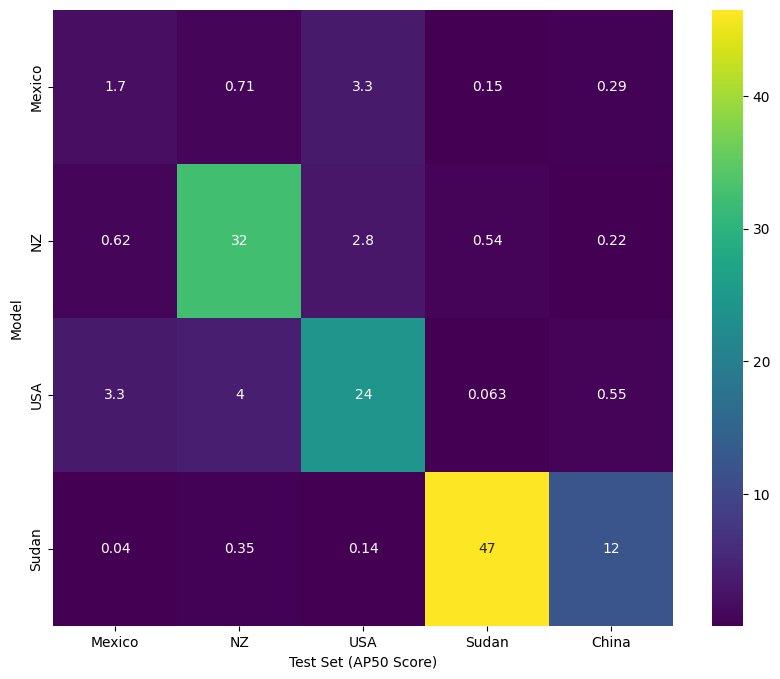

In [293]:
# MAKE HEATMAP FOR THE PAPER

import seaborn as sns

keys = list(test_dict.keys())
values = [[test_dict[key][inner_key] for inner_key in ['Mexico', 'NZ', 'USA', 'Sudan', 'China']] for key in keys]

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(values, annot=True, cmap="viridis", cbar=True, xticklabels=['Mexico', 'NZ', 'USA', 'Sudan', 'China'], yticklabels=keys)
plt.ylabel('Model')
plt.xlabel('Test Set (AP50 Score)')
plt.savefig('/workspace/figures/exp2_results', bbox_inches = 'tight')
plt.show()

 # Leave-on-out training scheme - create Labels Files

### for the labels train file

In [316]:
with open('/workspace/data/countries/train_Mexico_labels.json', 'r') as f:
    ME_labels = json.load(f)
    
with open('/workspace/data/countries/train_USA_labels.json', 'r') as f:
    US_labels = json.load(f)
    
with open('/workspace/data/countries/train_Sudan_labels.json', 'r') as f:
    SU_labels = json.load(f)
    
with open('/workspace/data/countries/train_NZ_labels.json', 'r') as f:
    NZ_labels = json.load(f)

In [317]:
name_to_dict = {'ME': ME_labels,
 'US': US_labels,
 'SU': SU_labels,
 'NZ': NZ_labels
}

In [318]:
# check the range of the image ids for all four countries
for labels in [ME_labels, US_labels, SU_labels, NZ_labels]:

    max_id = float('-inf')
    min_id = float('inf')

    # iterate through the 'images' list and find the maximum and minimum 'id' value
    for image in labels['images']:
        image_id = image['id']
        if image_id > max_id:
            max_id = image_id
        if image_id < min_id:
            min_id = image_id

    print(f"image ID range between: {min_id} and {max_id}")


image ID range between: 1 and 2079
image ID range between: 1056 and 5483
image ID range between: 5484 and 9473
image ID range between: 2058 and 3724


In [319]:
# adjust the image ids and annotation image_ids for mexico to numbers that are not yet taken by other countries

old_id = 1
new_id = 9474
annotation_id = 100000
for i in range(len(ME_labels['images'])):
    ME_labels['images'][i]['id'] = new_id
    for j in range(len(ME_labels['annotations'])):
        if ME_labels['annotations'][j]['image_id'] == old_id:
            ME_labels['annotations'][j]['image_id'] = new_id
            ME_labels['annotations'][j]['id'] = annotation_id
            annotation_id += 1
    new_id += 1
    old_id += 1

In [321]:
# create train_labels for all four leave-one-out combinations
import random
import itertools

countries = ["ME", "US", "SU", "NZ"]
#for comb in itertools.combinations(countries, 3):
for comb in [["ME", "US", "SU", "NZ"]]:
    merged_dict = {"images": [], "annotations": []}
    merged_dict['categories'] = [{"id": 0, "name": "DT", "supercategory": None}]
    merged_dict["info"] = {"year": "", "version": "", "description": "", "contributor": "", "url": "https://voxel51.com/fiftyone", "date_created": "2023-03-13T16:25:21"} 
    merged_dict["licenses"] = [],
    for country in comb:
        dict_name = country + "_labels"
        
        country_dict = name_to_dict[country]
        
        country_images = random.sample(country_dict["images"], 1125) #, 1500)
        country_image_ids = [img["id"] for img in country_images]
        country_annotations = [ann for ann in country_dict["annotations"] if ann["image_id"] in country_image_ids]

        merged_dict["images"].extend(country_images)
        merged_dict["annotations"].extend(country_annotations)
        

        
        #merged_dict["images"].extend(eval(dict_name)["images"])
        #merged_dict["annotations"].extend(eval(dict_name)["annotations"])
    
    filename = '_'.join(comb) + "_labels_train.json"
    with open(f'/workspace/data/countries/leave-one-out-johannes/{filename}', "w") as f:
        json.dump(merged_dict, f)

In [322]:
print(len(merged_dict['images']))

4500


### for val set

In [306]:
with open('/workspace/data/countries/val_Mexico_labels.json', 'r') as f:
    ME_labels = json.load(f)
    
with open('/workspace/data/countries/val_USA_labels.json', 'r') as f:
    US_labels = json.load(f)
    
with open('/workspace/data/countries/val_Sudan_labels.json', 'r') as f:
    SU_labels = json.load(f)
    
with open('/workspace/data/countries/val_NZ_labels.json', 'r') as f:
    NZ_labels = json.load(f)

In [307]:
name_to_dict = {'ME': ME_labels,
 'US': US_labels,
 'SU': SU_labels,
 'NZ': NZ_labels
}

In [308]:
# check the range of the image ids for all four countries
for labels in [ME_labels, US_labels, SU_labels, NZ_labels]:

    max_id = float('-inf')
    min_id = float('inf')

    # iterate through the 'images' list and find the maximum and minimum 'id' value
    for image in labels['images']:
        image_id = image['id']
        if image_id > max_id:
            max_id = image_id
        if image_id < min_id:
            min_id = image_id

    print(f"image ID range between: {min_id} and {max_id}")

image ID range between: 1 and 209
image ID range between: 169 and 1049
image ID range between: 1050 and 1736
image ID range between: 300 and 716


In [309]:
## val set for mexico is the shortest with 206 images

# adjust the image ids and annotation image_ids for mexico to numbers that are not yet taken by other countries

old_id = 1
new_id = 1737
annotation_id = 100000
for i in range(len(ME_labels['images'])):
    ME_labels['images'][i]['id'] = new_id
    for j in range(len(ME_labels['annotations'])):
        if ME_labels['annotations'][j]['image_id'] == old_id:
            ME_labels['annotations'][j]['image_id'] = new_id
            ME_labels['annotations'][j]['id'] = annotation_id
            annotation_id += 1
    new_id += 1
    old_id += 1

In [310]:
# choose 205 random images, minimum comes from val set mexico
import itertools

countries = ["ME", "US", "SU", "NZ"]
#for comb in itertools.combinations(countries, 3):
for comb in [["ME", "US", "SU", "NZ"]]: # to generate the model with all four locations
    merged_dict = {"images": [], "annotations": []}

    merged_dict['categories'] = [{"id": 0, "name": "DT", "supercategory": None}]
    merged_dict["info"] = {"year": "", "version": "", "description": "", "contributor": "", "url": "https://voxel51.com/fiftyone", "date_created": "2023-03-13T16:25:21"} 
    merged_dict["licenses"] = [],
    
    
    for country in comb:
        dict_name = country + "_labels"
        country_dict = name_to_dict[country]
        
        country_images = random.sample(country_dict["images"],154) #, 205)
        country_image_ids = [img["id"] for img in country_images]
        country_annotations = [ann for ann in country_dict["annotations"] if ann["image_id"] in country_image_ids]

        merged_dict["images"].extend(country_images)
        merged_dict["annotations"].extend(country_annotations)
        
        
        #merged_dict["images"].extend(eval(dict_name)["images"])
        #merged_dict["annotations"].extend(eval(dict_name)["annotations"])
    
    filename = '_'.join(comb) + "_labels_val.json"
    with open(f'/workspace/data/countries/leave-one-out-johannes/{filename}', "w") as f:
        json.dump(merged_dict, f)

In [311]:
print(len(merged_dict['images']))

616


In [313]:
filename

'ME_US_SU_NZ_labels_val.json'

In [314]:
with open(f'/workspace/data/countries/leave-one-out-johannes/ME_US_SU_NZ_labels_val.json', 'r') as f:
    faulty_labels = json.load(f)

In [315]:
im_ids = []
for i in faulty_labels['annotations']:
    
    if i['id'] in im_ids:
        print(i['id'], ' is a duplicate image ID, \nfilename: ')#, i['file_name'][:3])
    else: 
        im_ids.append(i['id'])
        

## Training

In [323]:
# We use the older MyTrainer from Experiment 1 here because the sampling into the loo-labels files took care of the sample size.

class MyTrainer(DefaultTrainer):
        
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            self.cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        
        # add the best checkpointer hook
        # adapted from https://www.kaggle.com/c/sartorius-cell-instance-segmentation/discussion/287023
        hooks.insert(-1, BestCheckpointer(self.cfg.TEST.EVAL_PERIOD, 
                                         DetectionCheckpointer(self.model, self.cfg.OUTPUT_DIR),
                                         "bbox/AP50",
                                         "max",
                                         "best_ap50"
                                         ))
        return hooks

    def build_train_loader(cls, cfg):
        
        return build_detection_train_loader(cfg)


def train_detectron_leave_one_out(config_dict = None, 
                         default_dict = None,
                         resolution = "res_missing",
                         output_dir_prefix = None,
                         dataset_name_train = '030_train',
                        dataset_name_val = '030_val',
                        comb = None
                        ):
    
    """
    This docstring was created by chatGPT. The function is ours. 
    Trains a Detectron2 model for object detection on a specific country combination

    Parameters
    ----------
    config_dict : dict, optional
        Dictionary with configuration parameters to override the default_dict values.
    default_dict : dict, optional
        Dictionary with default values for configuration parameters. If not provided, the function will use these default values:
        {
            'eval_period': None,
            'learning_rate': 0.001,
            'batch_size': 8,
            'anchors': [[4, 8, 16, 32, 64]],
            'weight_decay': 0.0001,
            'solver_steps_divider': 10,
            'freeze_at': 2,
            'gradient_clipping': False
        }
    resolution : str, optional
        Resolution of the images in the dataset (e.g. "60-90"). Default is "res_missing".
    output_dir_prefix : str, optional
        Prefix for the output directory where the trained model will be saved. Default is None, in which case the prefix will be "res{resolution}_<current_time>".
    dataset_name_train : str, optional
        Name of the training dataset. Default is "030_train".
    dataset_name_val : str, optional
        Name of the validation dataset. Default is "030_val".
    comb : str, required
        combination of countries. used to access the data file. 

    Returns
    -------
    Tuple with the following elements:
    - cfg: Detectron2 CfgNode with the model's configuration.
    - trainer: Detectron2 trainer object used for training the model.
    - predictor: Detectron2 predictor object used for making predictions with the trained model.

    If the `country` parameter is None, the function returns the string "You did not pass a country".
    """
    
    if country is None:
        return "You did not pass a country"

    if config_dict is None:
        config_dict = {}
    if default_dict is None:
        default_dict = {
            'eval_period': None,
            'learning_rate': 0.001,
            'batch_size': 8,
            'anchors': [[4, 8, 16, 32, 64]],
            'weight_decay': 0.0001,
            'solver_steps_divider': 10,
            'freeze_at': 2,
            'gradient_clipping': False}

    # Merge default_dict with my_dict, overriding any duplicate keys
    config = {**default_dict, **config_dict}
    
    print(config)
    
    register(dataset_name_train, f"/workspace/data/countries/leave-one-out-johannes/{comb}_labels_train.json", f"/workspace/data/data_{resolution}_mexico_60-90/train/data")
    register(dataset_name_val, f"/workspace/data/countries/leave-one-out-johannes/{comb}_labels_val.json", f"/workspace/data/data_{resolution}_mexico_60-90/val/data")
    
    
    if output_dir_prefix:
        now = datetime.now() 
        output_dir = f"/workspace/output/{output_dir_prefix}/{comb}"
    else:
        now = datetime.now() 
        output_dir = f"/workspace/output/res{resolution}_{now.strftime('%m.%d.%H.%M')}"
        
    #create_local_process_group(num_workers_per_machine=2)
    
    # batchsize * iterations
    views = 75000
    
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
    cfg.INPUT.FORMAT = "RGB"
    
    cfg.OUTPUT_DIR = output_dir
    print("Output Dir:", cfg.OUTPUT_DIR)
    cfg.DATASETS.TRAIN = (dataset_name_train)
    cfg.DATASETS.TEST = (dataset_name_val,)
    cfg.DATASETS.EVAL = (dataset_name_val,)
    
    cfg.DATALOADER.SAMPLER_TRAIN = "TrainingSampler"
    #cfg.DATALOADER.
    #cfg.DATALOADER.NUM_INSTANCE = 500
    cfg.DATALOADER.SEED = 42

    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.ANCHOR_GENERATOR.SIZES = config['anchors']
    cfg.SOLVER.MAX_ITER = round(views/config['batch_size'])
    cfg.TEST.EVAL_PERIOD = cfg.SOLVER.MAX_ITER / 20 # für unseren Evaluator

    cfg.SOLVER.IMS_PER_BATCH = config['batch_size']
    cfg.SOLVER.BASE_LR = config['learning_rate']
    cfg.SOLVER.WEIGHT_DECAY = config['weight_decay']
    cfg.SOLVER.CLIP_GRADIENTS.ENABLED = config['gradient_clipping']
    cfg.SOLVER.STEPS = [.5*cfg.SOLVER.MAX_ITER, .75*cfg.SOLVER.MAX_ITER, .9*cfg.SOLVER.MAX_ITER]
    #print(cfg.SOLVER.STEPS)
    
    cfg.MODEL.BACKBONE.FREEZE_AT = config['freeze_at']
      
    
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
    cfg.TEST.DETECTIONS_PER_IMAGE = 30

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    
    trainer = MyTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()
    
    
    predictor = DefaultPredictor(cfg)
    
    return cfg, trainer, predictor

## Main loop for Leave-One-Out with 3 countries

In [212]:
countries = ["ME", "US", "SU", "NZ"]


output_dir_prefix = f"experiment2/leave-one-out/{now.strftime('%m.%d.%H.%M')}"

for comb in itertools.combinations(countries, 3):
    
    config1 = {'learning_rate': 0.001, 
              'batch_size': 5, 
              'gradient_clipping': True, 
              'weight_decay': 0.001, 
              'freeze_at': 1, 
              'index': 8}
    filename = '_'.join(comb)
    print("------ Training on Combo from: ", filename, "----------")
    print("------ Saving to: ", f'/workspace/output/{output_dir_prefix}/leave-one-out/', "----------")

    now = datetime.now()
    

    if not os.path.exists(f'/workspace/output/{output_dir_prefix}'):
        os.makedirs(f'/workspace/output/{output_dir_prefix}')


    cfg_mex, trainer_mex, predictor_mex = train_detectron_leave_one_out(config1, 
                                resolution = '030',
                                output_dir_prefix = output_dir_prefix,
                                dataset_name_train = '030_train',
                                dataset_name_val = '030_val',
                                comb = filename)

------ Training on Combo from:  ME_US_SU ----------
------ Saving to:  /workspace/output/experiment2/leave-one-out/04.23.18.43/leave-one-out/ ----------
{'eval_period': None, 'learning_rate': 0.001, 'batch_size': 5, 'anchors': [[4, 8, 16, 32, 64]], 'weight_decay': 0.001, 'solver_steps_divider': 10, 'freeze_at': 1, 'gradient_clipping': True, 'index': 8}
Output Dir: /workspace/output/experiment2/leave-one-out/04.23.18.43/ME_US_SU
[04/23 18:45:02 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_l

WARNING [04/23 18:45:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/23 18:45:02 d2.data.datasets.coco]: Loaded 4500 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_US_SU_labels_train.json
[04/23 18:45:02 d2.data.build]: Removed 264 images with no usable annotations. 4236 images left.
[04/23 18:45:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/23 18:45:02 d2.data.build]: Using training sampler TrainingSampler
[04/23 18:45:02 d2.data.common]: Serializing 4236 elements to byte tensors and concatenating them all ...
[04/23 18:45:02 d2.data.common]: Serialized dataset takes 2.20 MiB
[04/23 18:45:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 8

[04/23 18:45:02 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint       | Shapes                                          |
|:------------------|:--------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2_0_branch2b_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2_0_branch2c_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.shortcut.* | res2_0_branch1_{bn_*,w}   | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,256,1,1)            |
| res2.1.conv2.*    | res2_1_branch2b_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.1.conv3.*    | res2_1_branch2c_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}


[04/23 18:45:02 d2.engine.train_loop]: Starting training from iteration 0
[04/23 18:45:08 d2.utils.events]:  eta: 1:12:29  iter: 19  total_loss: 1.384  loss_cls: 0.5829  loss_box_reg: 0.007319  loss_rpn_cls: 0.7005  loss_rpn_loc: 0.07061  time: 0.2795  data_time: 0.0362  lr: 1.9981e-05  max_mem: 8090M
[04/23 18:45:14 d2.utils.events]:  eta: 1:11:37  iter: 39  total_loss: 0.8542  loss_cls: 0.06329  loss_box_reg: 0.005041  loss_rpn_cls: 0.6908  loss_rpn_loc: 0.09294  time: 0.2784  data_time: 0.0268  lr: 3.9961e-05  max_mem: 8090M
[04/23 18:45:19 d2.utils.events]:  eta: 1:10:57  iter: 59  total_loss: 0.796  loss_cls: 0.05539  loss_box_reg: 0.006275  loss_rpn_cls: 0.6787  loss_rpn_loc: 0.0554  time: 0.2790  data_time: 0.0276  lr: 5.9941e-05  max_mem: 8090M
[04/23 18:45:25 d2.utils.events]:  eta: 1:10:51  iter: 79  total_loss: 0.7911  loss_cls: 0.05784  loss_box_reg: 0.006844  loss_rpn_cls: 0.6543  loss_rpn_loc: 0.06744  time: 0.2784  data_time: 0.0269  lr: 7.9921e-05  max_mem: 8090M
[04/23

[04/23 18:48:32 d2.utils.events]:  eta: 1:08:56  iter: 739  total_loss: 0.5291  loss_cls: 0.1802  loss_box_reg: 0.2179  loss_rpn_cls: 0.08574  loss_rpn_loc: 0.03631  time: 0.2822  data_time: 0.0283  lr: 0.00073926  max_mem: 8090M
WARNING [04/23 18:48:34 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/23 18:48:34 d2.data.datasets.coco]: Loaded 615 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_US_SU_labels_val.json
[04/23 18:48:35 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/23 18:48:35 d2.data.common]: Serializing 615 elements to byte tensors and concatenating them all ...
[04/23 18:48:35 d2.data.common]: Serialized dataset takes 0.30 MiB
WARNING [04/23 18:48:35 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Pl

[04/23 18:50:48 d2.utils.events]:  eta: 1:07:29  iter: 1039  total_loss: 0.7118  loss_cls: 0.252  loss_box_reg: 0.3126  loss_rpn_cls: 0.0712  loss_rpn_loc: 0.04132  validation_loss: 0.528  time: 0.2820  data_time: 0.0267  lr: 0.001  max_mem: 8090M
[04/23 18:50:54 d2.utils.events]:  eta: 1:07:29  iter: 1059  total_loss: 0.7422  loss_cls: 0.2307  loss_box_reg: 0.2979  loss_rpn_cls: 0.06524  loss_rpn_loc: 0.04628  validation_loss: 0.528  time: 0.2821  data_time: 0.0294  lr: 0.001  max_mem: 8090M
[04/23 18:50:59 d2.utils.events]:  eta: 1:07:26  iter: 1079  total_loss: 0.7872  loss_cls: 0.2757  loss_box_reg: 0.3669  loss_rpn_cls: 0.08073  loss_rpn_loc: 0.05574  validation_loss: 0.528  time: 0.2821  data_time: 0.0281  lr: 0.001  max_mem: 8090M
[04/23 18:51:05 d2.utils.events]:  eta: 1:07:21  iter: 1099  total_loss: 0.6876  loss_cls: 0.2408  loss_box_reg: 0.3285  loss_rpn_cls: 0.06644  loss_rpn_loc: 0.03231  validation_loss: 0.528  time: 0.2823  data_time: 0.0274  lr: 0.001  max_mem: 8090M
[0

[04/23 18:53:21 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.09 seconds.
[04/23 18:53:21 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[04/23 18:53:21 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.061
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.033
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.140
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.207
 Ave

[04/23 18:56:12 d2.utils.events]:  eta: 1:03:16  iter: 1999  total_loss: 0.7018  loss_cls: 0.2606  loss_box_reg: 0.338  loss_rpn_cls: 0.04527  loss_rpn_loc: 0.04567  validation_loss: 0.5803  time: 0.2824  data_time: 0.0275  lr: 0.001  max_mem: 8090M
[04/23 18:56:18 d2.utils.events]:  eta: 1:03:10  iter: 2019  total_loss: 0.8411  loss_cls: 0.2765  loss_box_reg: 0.4007  loss_rpn_cls: 0.06361  loss_rpn_loc: 0.04123  validation_loss: 0.5803  time: 0.2824  data_time: 0.0281  lr: 0.001  max_mem: 8090M
[04/23 18:56:23 d2.utils.events]:  eta: 1:03:07  iter: 2039  total_loss: 0.7854  loss_cls: 0.2732  loss_box_reg: 0.3761  loss_rpn_cls: 0.04558  loss_rpn_loc: 0.03968  validation_loss: 0.5803  time: 0.2824  data_time: 0.0284  lr: 0.001  max_mem: 8090M
[04/23 18:56:29 d2.utils.events]:  eta: 1:02:59  iter: 2059  total_loss: 0.6911  loss_cls: 0.2497  loss_box_reg: 0.333  loss_rpn_cls: 0.03922  loss_rpn_loc: 0.03258  validation_loss: 0.5803  time: 0.2824  data_time: 0.0276  lr: 0.001  max_mem: 8090

[04/23 18:58:28 d2.utils.events]:  eta: 1:01:50  iter: 2299  total_loss: 0.8311  loss_cls: 0.2872  loss_box_reg: 0.4354  loss_rpn_cls: 0.04018  loss_rpn_loc: 0.03498  validation_loss: 0.6326  time: 0.2823  data_time: 0.0268  lr: 0.001  max_mem: 8090M
[04/23 18:58:34 d2.utils.events]:  eta: 1:01:45  iter: 2319  total_loss: 0.7708  loss_cls: 0.261  loss_box_reg: 0.3511  loss_rpn_cls: 0.05629  loss_rpn_loc: 0.04399  validation_loss: 0.6326  time: 0.2823  data_time: 0.0277  lr: 0.001  max_mem: 8090M
[04/23 18:58:40 d2.utils.events]:  eta: 1:01:39  iter: 2339  total_loss: 0.7336  loss_cls: 0.2705  loss_box_reg: 0.3731  loss_rpn_cls: 0.04741  loss_rpn_loc: 0.03881  validation_loss: 0.6326  time: 0.2823  data_time: 0.0295  lr: 0.001  max_mem: 8090M
[04/23 18:58:45 d2.utils.events]:  eta: 1:01:37  iter: 2359  total_loss: 0.7895  loss_cls: 0.2852  loss_box_reg: 0.4109  loss_rpn_cls: 0.04405  loss_rpn_loc: 0.03752  validation_loss: 0.6326  time: 0.2824  data_time: 0.0290  lr: 0.001  max_mem: 809

[04/23 19:01:35 d2.utils.events]:  eta: 0:58:43  iter: 2959  total_loss: 0.7941  loss_cls: 0.2934  loss_box_reg: 0.4117  loss_rpn_cls: 0.03733  loss_rpn_loc: 0.04137  validation_loss: 0.6326  time: 0.2824  data_time: 0.0302  lr: 0.001  max_mem: 8090M
[04/23 19:01:41 d2.utils.events]:  eta: 0:58:36  iter: 2979  total_loss: 0.715  loss_cls: 0.266  loss_box_reg: 0.3727  loss_rpn_cls: 0.02746  loss_rpn_loc: 0.04086  validation_loss: 0.6326  time: 0.2824  data_time: 0.0270  lr: 0.001  max_mem: 8090M
WARNING [04/23 19:01:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/23 19:01:47 d2.data.datasets.coco]: Loaded 615 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_US_SU_labels_val.json
[04/23 19:01:47 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/23 19:01:47 d2.data.common]

[04/23 19:03:52 d2.utils.events]:  eta: 0:57:08  iter: 3259  total_loss: 0.7282  loss_cls: 0.2742  loss_box_reg: 0.3955  loss_rpn_cls: 0.03245  loss_rpn_loc: 0.03395  validation_loss: 0.65  time: 0.2823  data_time: 0.0269  lr: 0.001  max_mem: 8090M
[04/23 19:03:57 d2.utils.events]:  eta: 0:57:04  iter: 3279  total_loss: 0.7278  loss_cls: 0.2826  loss_box_reg: 0.3839  loss_rpn_cls: 0.03063  loss_rpn_loc: 0.03393  validation_loss: 0.65  time: 0.2823  data_time: 0.0291  lr: 0.001  max_mem: 8090M
[04/23 19:04:03 d2.utils.events]:  eta: 0:57:00  iter: 3299  total_loss: 0.7489  loss_cls: 0.2774  loss_box_reg: 0.4152  loss_rpn_cls: 0.03873  loss_rpn_loc: 0.03363  validation_loss: 0.65  time: 0.2823  data_time: 0.0269  lr: 0.001  max_mem: 8090M
[04/23 19:04:09 d2.utils.events]:  eta: 0:56:55  iter: 3319  total_loss: 0.7092  loss_cls: 0.2537  loss_box_reg: 0.3845  loss_rpn_cls: 0.03521  loss_rpn_loc: 0.03529  validation_loss: 0.65  time: 0.2824  data_time: 0.0267  lr: 0.001  max_mem: 8090M
[04/

[04/23 19:06:33 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/23 19:06:33 d2.evaluation.coco_evaluation]: Saving results to /workspace/output/experiment2/leave-one-out/04.23.18.43/ME_US_SU/inference/coco_instances_results.json
[04/23 19:06:33 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[04/23 19:06:33 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[04/23 19:06:33 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.09 seconds.
[04/23 19:06:33 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[04/23 19:06:33 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.098
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.343
 Average Precision  (AP) @[ IoU=0.75      | area=   

[04/23 19:09:15 d2.utils.events]:  eta: 0:52:26  iter: 4219  total_loss: 0.7778  loss_cls: 0.2815  loss_box_reg: 0.4226  loss_rpn_cls: 0.02878  loss_rpn_loc: 0.03408  validation_loss: 0.6675  time: 0.2823  data_time: 0.0281  lr: 0.001  max_mem: 8090M
[04/23 19:09:20 d2.utils.events]:  eta: 0:52:19  iter: 4239  total_loss: 0.7149  loss_cls: 0.2715  loss_box_reg: 0.4005  loss_rpn_cls: 0.03425  loss_rpn_loc: 0.03595  validation_loss: 0.6675  time: 0.2823  data_time: 0.0283  lr: 0.001  max_mem: 8090M
[04/23 19:09:26 d2.utils.events]:  eta: 0:52:13  iter: 4259  total_loss: 0.7555  loss_cls: 0.2693  loss_box_reg: 0.4175  loss_rpn_cls: 0.03158  loss_rpn_loc: 0.03961  validation_loss: 0.6675  time: 0.2823  data_time: 0.0266  lr: 0.001  max_mem: 8090M
[04/23 19:09:31 d2.utils.events]:  eta: 0:52:04  iter: 4279  total_loss: 0.727  loss_cls: 0.2447  loss_box_reg: 0.3751  loss_rpn_cls: 0.03173  loss_rpn_loc: 0.03869  validation_loss: 0.6675  time: 0.2823  data_time: 0.0262  lr: 0.001  max_mem: 809

[04/23 19:11:31 d2.utils.events]:  eta: 0:50:52  iter: 4519  total_loss: 0.7434  loss_cls: 0.2708  loss_box_reg: 0.3941  loss_rpn_cls: 0.03165  loss_rpn_loc: 0.03787  validation_loss: 0.6699  time: 0.2822  data_time: 0.0273  lr: 0.001  max_mem: 8090M
[04/23 19:11:36 d2.utils.events]:  eta: 0:50:45  iter: 4539  total_loss: 0.7031  loss_cls: 0.2479  loss_box_reg: 0.3881  loss_rpn_cls: 0.0307  loss_rpn_loc: 0.0282  validation_loss: 0.6699  time: 0.2822  data_time: 0.0258  lr: 0.001  max_mem: 8090M
[04/23 19:11:42 d2.utils.events]:  eta: 0:50:39  iter: 4559  total_loss: 0.7022  loss_cls: 0.2421  loss_box_reg: 0.3841  loss_rpn_cls: 0.02835  loss_rpn_loc: 0.02654  validation_loss: 0.6699  time: 0.2822  data_time: 0.0271  lr: 0.001  max_mem: 8090M
[04/23 19:11:47 d2.utils.events]:  eta: 0:50:33  iter: 4579  total_loss: 0.7217  loss_cls: 0.2508  loss_box_reg: 0.4044  loss_rpn_cls: 0.02626  loss_rpn_loc: 0.03005  validation_loss: 0.6699  time: 0.2822  data_time: 0.0282  lr: 0.001  max_mem: 8090

[04/23 19:14:37 d2.utils.events]:  eta: 0:47:36  iter: 5179  total_loss: 0.6711  loss_cls: 0.2569  loss_box_reg: 0.3814  loss_rpn_cls: 0.02264  loss_rpn_loc: 0.02977  validation_loss: 0.6699  time: 0.2822  data_time: 0.0267  lr: 0.001  max_mem: 8090M
[04/23 19:14:43 d2.utils.events]:  eta: 0:47:31  iter: 5199  total_loss: 0.8075  loss_cls: 0.2814  loss_box_reg: 0.4259  loss_rpn_cls: 0.02676  loss_rpn_loc: 0.03079  validation_loss: 0.6699  time: 0.2822  data_time: 0.0278  lr: 0.001  max_mem: 8090M
[04/23 19:14:49 d2.utils.events]:  eta: 0:47:25  iter: 5219  total_loss: 0.7312  loss_cls: 0.268  loss_box_reg: 0.4032  loss_rpn_cls: 0.02343  loss_rpn_loc: 0.03101  validation_loss: 0.6699  time: 0.2822  data_time: 0.0286  lr: 0.001  max_mem: 8090M
[04/23 19:14:54 d2.utils.events]:  eta: 0:47:19  iter: 5239  total_loss: 0.6838  loss_cls: 0.2453  loss_box_reg: 0.3902  loss_rpn_cls: 0.02459  loss_rpn_loc: 0.03044  validation_loss: 0.6699  time: 0.2822  data_time: 0.0274  lr: 0.001  max_mem: 809

[04/23 19:16:53 d2.utils.events]:  eta: 0:46:06  iter: 5479  total_loss: 0.8239  loss_cls: 0.2888  loss_box_reg: 0.4242  loss_rpn_cls: 0.02619  loss_rpn_loc: 0.03607  validation_loss: 0.6724  time: 0.2821  data_time: 0.0269  lr: 0.001  max_mem: 8090M
[04/23 19:16:59 d2.utils.events]:  eta: 0:46:02  iter: 5499  total_loss: 0.7418  loss_cls: 0.2664  loss_box_reg: 0.3834  loss_rpn_cls: 0.0253  loss_rpn_loc: 0.03456  validation_loss: 0.6724  time: 0.2822  data_time: 0.0291  lr: 0.001  max_mem: 8090M
[04/23 19:17:04 d2.utils.events]:  eta: 0:45:58  iter: 5519  total_loss: 0.7401  loss_cls: 0.2503  loss_box_reg: 0.3542  loss_rpn_cls: 0.03896  loss_rpn_loc: 0.0459  validation_loss: 0.6724  time: 0.2822  data_time: 0.0281  lr: 0.001  max_mem: 8090M
[04/23 19:17:10 d2.utils.events]:  eta: 0:45:52  iter: 5539  total_loss: 0.7614  loss_cls: 0.2656  loss_box_reg: 0.4202  loss_rpn_cls: 0.02873  loss_rpn_loc: 0.03713  validation_loss: 0.6724  time: 0.2822  data_time: 0.0286  lr: 0.001  max_mem: 8090

[04/23 19:19:42 d2.evaluation.evaluator]: Total inference time: 0:00:21.939732 (0.035967 s / iter per device, on 1 devices)
[04/23 19:19:42 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:21 (0.034701 s / iter per device, on 1 devices)
[04/23 19:19:42 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/23 19:19:42 d2.evaluation.coco_evaluation]: Saving results to /workspace/output/experiment2/leave-one-out/04.23.18.43/ME_US_SU/inference/coco_instances_results.json
[04/23 19:19:42 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[04/23 19:19:42 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[04/23 19:19:42 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.08 seconds.
[04/23 19:19:42 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[04/23 19:19:42 d2.evaluation.fast_eval_api]: COCOeval_o

[04/23 19:22:15 d2.utils.events]:  eta: 0:41:33  iter: 6439  total_loss: 0.7162  loss_cls: 0.2663  loss_box_reg: 0.394  loss_rpn_cls: 0.02108  loss_rpn_loc: 0.03549  validation_loss: 0.6992  time: 0.2821  data_time: 0.0279  lr: 0.001  max_mem: 8090M
[04/23 19:22:21 d2.utils.events]:  eta: 0:41:28  iter: 6459  total_loss: 0.7665  loss_cls: 0.2756  loss_box_reg: 0.3856  loss_rpn_cls: 0.02794  loss_rpn_loc: 0.03644  validation_loss: 0.6992  time: 0.2821  data_time: 0.0269  lr: 0.001  max_mem: 8090M
[04/23 19:22:26 d2.utils.events]:  eta: 0:41:23  iter: 6479  total_loss: 0.6898  loss_cls: 0.2506  loss_box_reg: 0.3803  loss_rpn_cls: 0.02479  loss_rpn_loc: 0.03307  validation_loss: 0.6992  time: 0.2821  data_time: 0.0270  lr: 0.001  max_mem: 8090M
[04/23 19:22:32 d2.utils.events]:  eta: 0:41:13  iter: 6499  total_loss: 0.7582  loss_cls: 0.273  loss_box_reg: 0.4303  loss_rpn_cls: 0.0205  loss_rpn_loc: 0.03718  validation_loss: 0.6992  time: 0.2821  data_time: 0.0272  lr: 0.001  max_mem: 8090M

[04/23 19:24:05 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/23 19:24:05 d2.evaluation.testing]: copypaste: 7.3215,28.5696,0.9821,7.4090,4.0042,nan
[04/23 19:24:34 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 28.56956, not better than best score 38.15136 @ iteration 2999.
[04/23 19:24:36 d2.utils.events]:  eta: 0:39:59  iter: 6759  total_loss: 0.7227  loss_cls: 0.2439  loss_box_reg: 0.3889  loss_rpn_cls: 0.025  loss_rpn_loc: 0.03261  validation_loss: 0.726  time: 0.2820  data_time: 0.0293  lr: 0.001  max_mem: 8090M
[04/23 19:24:42 d2.utils.events]:  eta: 0:39:53  iter: 6779  total_loss: 0.7451  loss_cls: 0.2548  loss_box_reg: 0.4331  loss_rpn_cls: 0.02322  loss_rpn_loc: 0.04026  validation_loss: 0.726  time: 0.2820  data_time: 0.0288  lr: 0.001  max_mem: 8090M
[04/23 19:24:48 d2.utils.events]:  eta: 0:39:47  iter: 6799  total_loss: 0.7075  loss_cls: 0.2567  loss_box_reg: 0.4044  loss_rpn_cls: 0.02541  loss_rpn_loc: 0.02948  validation_loss: 0.72

[04/23 19:27:37 d2.utils.events]:  eta: 0:36:52  iter: 7399  total_loss: 0.7005  loss_cls: 0.2625  loss_box_reg: 0.3925  loss_rpn_cls: 0.0211  loss_rpn_loc: 0.0288  validation_loss: 0.726  time: 0.2821  data_time: 0.0266  lr: 0.001  max_mem: 8090M
[04/23 19:27:43 d2.utils.events]:  eta: 0:36:44  iter: 7419  total_loss: 0.7009  loss_cls: 0.2568  loss_box_reg: 0.3911  loss_rpn_cls: 0.02825  loss_rpn_loc: 0.03293  validation_loss: 0.726  time: 0.2821  data_time: 0.0267  lr: 0.001  max_mem: 8090M
[04/23 19:27:48 d2.utils.events]:  eta: 0:36:37  iter: 7439  total_loss: 0.6656  loss_cls: 0.2508  loss_box_reg: 0.3673  loss_rpn_cls: 0.02328  loss_rpn_loc: 0.02781  validation_loss: 0.726  time: 0.2821  data_time: 0.0266  lr: 0.001  max_mem: 8090M
[04/23 19:27:54 d2.utils.events]:  eta: 0:36:31  iter: 7459  total_loss: 0.7373  loss_cls: 0.247  loss_box_reg: 0.4209  loss_rpn_cls: 0.02221  loss_rpn_loc: 0.03559  validation_loss: 0.726  time: 0.2820  data_time: 0.0252  lr: 0.001  max_mem: 8090M
[04

[04/23 19:29:53 d2.utils.events]:  eta: 0:35:20  iter: 7699  total_loss: 0.6573  loss_cls: 0.2278  loss_box_reg: 0.372  loss_rpn_cls: 0.02248  loss_rpn_loc: 0.0335  validation_loss: 0.7311  time: 0.2820  data_time: 0.0277  lr: 0.0001  max_mem: 8090M
[04/23 19:29:59 d2.utils.events]:  eta: 0:35:14  iter: 7719  total_loss: 0.6737  loss_cls: 0.2351  loss_box_reg: 0.3791  loss_rpn_cls: 0.0227  loss_rpn_loc: 0.03112  validation_loss: 0.7311  time: 0.2821  data_time: 0.0258  lr: 0.0001  max_mem: 8090M
[04/23 19:30:05 d2.utils.events]:  eta: 0:35:07  iter: 7739  total_loss: 0.6965  loss_cls: 0.2455  loss_box_reg: 0.3848  loss_rpn_cls: 0.02196  loss_rpn_loc: 0.03046  validation_loss: 0.7311  time: 0.2821  data_time: 0.0282  lr: 0.0001  max_mem: 8090M
[04/23 19:30:10 d2.utils.events]:  eta: 0:35:02  iter: 7759  total_loss: 0.6807  loss_cls: 0.2367  loss_box_reg: 0.3932  loss_rpn_cls: 0.01697  loss_rpn_loc: 0.03054  validation_loss: 0.7311  time: 0.2820  data_time: 0.0265  lr: 0.0001  max_mem: 8

[04/23 19:32:39 d2.evaluation.evaluator]: Inference done 290/615. Dataloading: 0.0009 s/iter. Inference: 0.0348 s/iter. Eval: 0.0002 s/iter. Total: 0.0360 s/iter. ETA=0:00:11
[04/23 19:32:44 d2.evaluation.evaluator]: Inference done 429/615. Dataloading: 0.0010 s/iter. Inference: 0.0348 s/iter. Eval: 0.0002 s/iter. Total: 0.0360 s/iter. ETA=0:00:06
[04/23 19:32:49 d2.evaluation.evaluator]: Inference done 568/615. Dataloading: 0.0010 s/iter. Inference: 0.0348 s/iter. Eval: 0.0002 s/iter. Total: 0.0360 s/iter. ETA=0:00:01
[04/23 19:32:51 d2.evaluation.evaluator]: Total inference time: 0:00:22.049552 (0.036147 s / iter per device, on 1 devices)
[04/23 19:32:51 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:21 (0.034821 s / iter per device, on 1 devices)
[04/23 19:32:51 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/23 19:32:51 d2.evaluation.coco_evaluation]: Saving results to /workspace/output/experiment2/leave-one-out/04.23.18.43/ME_US_SU/infe

[04/23 19:35:16 d2.utils.events]:  eta: 0:30:44  iter: 8659  total_loss: 0.6329  loss_cls: 0.219  loss_box_reg: 0.3207  loss_rpn_cls: 0.02026  loss_rpn_loc: 0.02656  validation_loss: 0.7361  time: 0.2820  data_time: 0.0267  lr: 0.0001  max_mem: 8090M
[04/23 19:35:21 d2.utils.events]:  eta: 0:30:38  iter: 8679  total_loss: 0.7169  loss_cls: 0.2403  loss_box_reg: 0.4178  loss_rpn_cls: 0.0192  loss_rpn_loc: 0.03461  validation_loss: 0.7361  time: 0.2820  data_time: 0.0273  lr: 0.0001  max_mem: 8090M
[04/23 19:35:27 d2.utils.events]:  eta: 0:30:32  iter: 8699  total_loss: 0.6438  loss_cls: 0.2415  loss_box_reg: 0.339  loss_rpn_cls: 0.0204  loss_rpn_loc: 0.02679  validation_loss: 0.7361  time: 0.2820  data_time: 0.0283  lr: 0.0001  max_mem: 8090M
[04/23 19:35:33 d2.utils.events]:  eta: 0:30:27  iter: 8719  total_loss: 0.7019  loss_cls: 0.2395  loss_box_reg: 0.4188  loss_rpn_cls: 0.01882  loss_rpn_loc: 0.03216  validation_loss: 0.7361  time: 0.2820  data_time: 0.0282  lr: 0.0001  max_mem: 80

[04/23 19:37:14 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[04/23 19:37:14 d2.engine.defaults]: Evaluation results for 030_val in csv format:
[04/23 19:37:14 d2.evaluation.testing]: copypaste: Task: bbox
[04/23 19:37:14 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/23 19:37:14 d2.evaluation.testing]: copypaste: 8.4946,33.2353,1.5004,8.6321,5.9026,nan
[04/23 19:37:43 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 33.23525, not better than best score 38.15136 @ iteration 2999.
[04/23 19:37:43 d2.utils.events]:  eta: 0:29:07  iter: 8999  total_loss: 0.5885  loss_cls: 0.1972  loss_box_reg: 0.3201  loss_rpn_cls: 0.01735  loss_rpn_loc: 0.03039  validation_loss: 0.7376  time: 0.2820  data_time: 0.0262  lr: 0.0001  max_mem: 8090M
[04/23 19:37:48 d2.utils.events]:  eta: 0:29:01  iter: 9019  total_loss: 0.6284  loss_cls: 0.2155  loss_box_reg: 0.3711  loss_rpn_cls: 0.01436  loss_rpn_loc: 0.02798  validation_loss: 0.73

[04/23 19:40:37 d2.utils.events]:  eta: 0:26:04  iter: 9619  total_loss: 0.6438  loss_cls: 0.2252  loss_box_reg: 0.3572  loss_rpn_cls: 0.01994  loss_rpn_loc: 0.02402  validation_loss: 0.7376  time: 0.2819  data_time: 0.0276  lr: 0.0001  max_mem: 8090M
[04/23 19:40:42 d2.utils.events]:  eta: 0:25:59  iter: 9639  total_loss: 0.7084  loss_cls: 0.2388  loss_box_reg: 0.3933  loss_rpn_cls: 0.016  loss_rpn_loc: 0.02976  validation_loss: 0.7376  time: 0.2819  data_time: 0.0278  lr: 0.0001  max_mem: 8090M
[04/23 19:40:48 d2.utils.events]:  eta: 0:25:53  iter: 9659  total_loss: 0.649  loss_cls: 0.2278  loss_box_reg: 0.3704  loss_rpn_cls: 0.01395  loss_rpn_loc: 0.02663  validation_loss: 0.7376  time: 0.2819  data_time: 0.0281  lr: 0.0001  max_mem: 8090M
[04/23 19:40:53 d2.utils.events]:  eta: 0:25:47  iter: 9679  total_loss: 0.6381  loss_cls: 0.2294  loss_box_reg: 0.3544  loss_rpn_cls: 0.01571  loss_rpn_loc: 0.02562  validation_loss: 0.7376  time: 0.2818  data_time: 0.0265  lr: 0.0001  max_mem: 8

[04/23 19:42:53 d2.utils.events]:  eta: 0:24:38  iter: 9919  total_loss: 0.6273  loss_cls: 0.2248  loss_box_reg: 0.3543  loss_rpn_cls: 0.01485  loss_rpn_loc: 0.02464  validation_loss: 0.7392  time: 0.2818  data_time: 0.0279  lr: 0.0001  max_mem: 8090M
[04/23 19:42:58 d2.utils.events]:  eta: 0:24:32  iter: 9939  total_loss: 0.6163  loss_cls: 0.2138  loss_box_reg: 0.3478  loss_rpn_cls: 0.0151  loss_rpn_loc: 0.02662  validation_loss: 0.7392  time: 0.2818  data_time: 0.0291  lr: 0.0001  max_mem: 8090M
[04/23 19:43:04 d2.utils.events]:  eta: 0:24:26  iter: 9959  total_loss: 0.657  loss_cls: 0.2167  loss_box_reg: 0.3787  loss_rpn_cls: 0.01733  loss_rpn_loc: 0.02783  validation_loss: 0.7392  time: 0.2818  data_time: 0.0289  lr: 0.0001  max_mem: 8090M
[04/23 19:43:10 d2.utils.events]:  eta: 0:24:21  iter: 9979  total_loss: 0.6617  loss_cls: 0.236  loss_box_reg: 0.4016  loss_rpn_cls: 0.01603  loss_rpn_loc: 0.02996  validation_loss: 0.7392  time: 0.2818  data_time: 0.0275  lr: 0.0001  max_mem: 8

[04/23 19:45:37 d2.evaluation.evaluator]: Inference done 11/615. Dataloading: 0.0008 s/iter. Inference: 0.0349 s/iter. Eval: 0.0001 s/iter. Total: 0.0359 s/iter. ETA=0:00:21
[04/23 19:45:42 d2.evaluation.evaluator]: Inference done 150/615. Dataloading: 0.0010 s/iter. Inference: 0.0350 s/iter. Eval: 0.0002 s/iter. Total: 0.0361 s/iter. ETA=0:00:16
[04/23 19:45:47 d2.evaluation.evaluator]: Inference done 290/615. Dataloading: 0.0010 s/iter. Inference: 0.0348 s/iter. Eval: 0.0002 s/iter. Total: 0.0360 s/iter. ETA=0:00:11
[04/23 19:45:52 d2.evaluation.evaluator]: Inference done 433/615. Dataloading: 0.0010 s/iter. Inference: 0.0345 s/iter. Eval: 0.0002 s/iter. Total: 0.0357 s/iter. ETA=0:00:06
[04/23 19:45:57 d2.evaluation.evaluator]: Inference done 576/615. Dataloading: 0.0009 s/iter. Inference: 0.0344 s/iter. Eval: 0.0002 s/iter. Total: 0.0356 s/iter. ETA=0:00:01
[04/23 19:45:59 d2.evaluation.evaluator]: Total inference time: 0:00:21.762281 (0.035676 s / iter per device, on 1 devices)
[0

[04/23 19:48:10 d2.utils.events]:  eta: 0:20:08  iter: 10859  total_loss: 0.6701  loss_cls: 0.2226  loss_box_reg: 0.3877  loss_rpn_cls: 0.0145  loss_rpn_loc: 0.02835  validation_loss: 0.7408  time: 0.2818  data_time: 0.0290  lr: 0.0001  max_mem: 8090M
[04/23 19:48:15 d2.utils.events]:  eta: 0:20:02  iter: 10879  total_loss: 0.6179  loss_cls: 0.2149  loss_box_reg: 0.3108  loss_rpn_cls: 0.01845  loss_rpn_loc: 0.02435  validation_loss: 0.7408  time: 0.2818  data_time: 0.0288  lr: 0.0001  max_mem: 8090M
[04/23 19:48:21 d2.utils.events]:  eta: 0:19:55  iter: 10899  total_loss: 0.6311  loss_cls: 0.212  loss_box_reg: 0.3724  loss_rpn_cls: 0.01304  loss_rpn_loc: 0.02963  validation_loss: 0.7408  time: 0.2819  data_time: 0.0260  lr: 0.0001  max_mem: 8090M
[04/23 19:48:27 d2.utils.events]:  eta: 0:19:49  iter: 10919  total_loss: 0.6668  loss_cls: 0.24  loss_box_reg: 0.3781  loss_rpn_cls: 0.01452  loss_rpn_loc: 0.02619  validation_loss: 0.7408  time: 0.2818  data_time: 0.0266  lr: 0.0001  max_mem

[04/23 19:50:23 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[04/23 19:50:23 d2.engine.defaults]: Evaluation results for 030_val in csv format:
[04/23 19:50:23 d2.evaluation.testing]: copypaste: Task: bbox
[04/23 19:50:23 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/23 19:50:23 d2.evaluation.testing]: copypaste: 8.8230,33.2439,1.6201,8.9576,6.6638,nan
[04/23 19:50:51 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 33.24391, not better than best score 38.15136 @ iteration 2999.
[04/23 19:50:54 d2.utils.events]:  eta: 0:18:12  iter: 11259  total_loss: 0.6389  loss_cls: 0.2191  loss_box_reg: 0.3834  loss_rpn_cls: 0.016  loss_rpn_loc: 0.02852  validation_loss: 0.7424  time: 0.2819  data_time: 0.0282  lr: 1e-05  max_mem: 8090M
[04/23 19:51:00 d2.utils.events]:  eta: 0:18:06  iter: 11279  total_loss: 0.6508  loss_cls: 0.211  loss_box_reg: 0.3669  loss_rpn_cls: 0.01159  loss_rpn_loc: 0.02549  validation_loss: 0.7424

[04/23 19:53:49 d2.utils.events]:  eta: 0:15:10  iter: 11879  total_loss: 0.6119  loss_cls: 0.2119  loss_box_reg: 0.3657  loss_rpn_cls: 0.01507  loss_rpn_loc: 0.02473  validation_loss: 0.7424  time: 0.2819  data_time: 0.0297  lr: 1e-05  max_mem: 8090M
[04/23 19:53:55 d2.utils.events]:  eta: 0:15:04  iter: 11899  total_loss: 0.65  loss_cls: 0.217  loss_box_reg: 0.3732  loss_rpn_cls: 0.01844  loss_rpn_loc: 0.029  validation_loss: 0.7424  time: 0.2819  data_time: 0.0280  lr: 1e-05  max_mem: 8090M
[04/23 19:54:01 d2.utils.events]:  eta: 0:14:59  iter: 11919  total_loss: 0.6438  loss_cls: 0.2172  loss_box_reg: 0.3607  loss_rpn_cls: 0.01531  loss_rpn_loc: 0.02926  validation_loss: 0.7424  time: 0.2819  data_time: 0.0284  lr: 1e-05  max_mem: 8090M
[04/23 19:54:06 d2.utils.events]:  eta: 0:14:53  iter: 11939  total_loss: 0.6411  loss_cls: 0.227  loss_box_reg: 0.3629  loss_rpn_cls: 0.01773  loss_rpn_loc: 0.03153  validation_loss: 0.7424  time: 0.2819  data_time: 0.0266  lr: 1e-05  max_mem: 8090

[04/23 19:56:06 d2.utils.events]:  eta: 0:13:42  iter: 12179  total_loss: 0.6002  loss_cls: 0.2012  loss_box_reg: 0.3365  loss_rpn_cls: 0.01376  loss_rpn_loc: 0.02646  validation_loss: 0.7468  time: 0.2819  data_time: 0.0286  lr: 1e-05  max_mem: 8090M
[04/23 19:56:12 d2.utils.events]:  eta: 0:13:36  iter: 12199  total_loss: 0.595  loss_cls: 0.2119  loss_box_reg: 0.3458  loss_rpn_cls: 0.01612  loss_rpn_loc: 0.02583  validation_loss: 0.7468  time: 0.2819  data_time: 0.0293  lr: 1e-05  max_mem: 8090M
[04/23 19:56:17 d2.utils.events]:  eta: 0:13:31  iter: 12219  total_loss: 0.616  loss_cls: 0.2101  loss_box_reg: 0.3572  loss_rpn_cls: 0.01181  loss_rpn_loc: 0.02258  validation_loss: 0.7468  time: 0.2819  data_time: 0.0288  lr: 1e-05  max_mem: 8090M
[04/23 19:56:23 d2.utils.events]:  eta: 0:13:25  iter: 12239  total_loss: 0.6516  loss_cls: 0.231  loss_box_reg: 0.3748  loss_rpn_cls: 0.016  loss_rpn_loc: 0.02915  validation_loss: 0.7468  time: 0.2819  data_time: 0.0295  lr: 1e-05  max_mem: 809

[04/23 19:58:53 d2.evaluation.evaluator]: Inference done 151/615. Dataloading: 0.0009 s/iter. Inference: 0.0348 s/iter. Eval: 0.0001 s/iter. Total: 0.0359 s/iter. ETA=0:00:16
[04/23 19:58:58 d2.evaluation.evaluator]: Inference done 291/615. Dataloading: 0.0009 s/iter. Inference: 0.0347 s/iter. Eval: 0.0002 s/iter. Total: 0.0359 s/iter. ETA=0:00:11
[04/23 19:59:03 d2.evaluation.evaluator]: Inference done 429/615. Dataloading: 0.0009 s/iter. Inference: 0.0349 s/iter. Eval: 0.0002 s/iter. Total: 0.0360 s/iter. ETA=0:00:06
[04/23 19:59:08 d2.evaluation.evaluator]: Inference done 571/615. Dataloading: 0.0009 s/iter. Inference: 0.0347 s/iter. Eval: 0.0002 s/iter. Total: 0.0359 s/iter. ETA=0:00:01
[04/23 19:59:10 d2.evaluation.evaluator]: Total inference time: 0:00:21.975504 (0.036025 s / iter per device, on 1 devices)
[04/23 19:59:10 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:21 (0.034743 s / iter per device, on 1 devices)
[04/23 19:59:10 d2.evaluation.coco_evaluation]

[04/23 20:01:29 d2.utils.events]:  eta: 0:09:03  iter: 13139  total_loss: 0.6415  loss_cls: 0.2185  loss_box_reg: 0.3716  loss_rpn_cls: 0.01779  loss_rpn_loc: 0.03149  validation_loss: 0.7513  time: 0.2820  data_time: 0.0270  lr: 1e-05  max_mem: 8090M
[04/23 20:01:34 d2.utils.events]:  eta: 0:08:57  iter: 13159  total_loss: 0.6148  loss_cls: 0.2182  loss_box_reg: 0.338  loss_rpn_cls: 0.01849  loss_rpn_loc: 0.02598  validation_loss: 0.7513  time: 0.2820  data_time: 0.0297  lr: 1e-05  max_mem: 8090M
[04/23 20:01:40 d2.utils.events]:  eta: 0:08:50  iter: 13179  total_loss: 0.6551  loss_cls: 0.2207  loss_box_reg: 0.3673  loss_rpn_cls: 0.0178  loss_rpn_loc: 0.02966  validation_loss: 0.7513  time: 0.2819  data_time: 0.0280  lr: 1e-05  max_mem: 8090M
[04/23 20:01:46 d2.utils.events]:  eta: 0:08:44  iter: 13199  total_loss: 0.6711  loss_cls: 0.2294  loss_box_reg: 0.3666  loss_rpn_cls: 0.0191  loss_rpn_loc: 0.03002  validation_loss: 0.7513  time: 0.2819  data_time: 0.0288  lr: 1e-05  max_mem: 8

[04/23 20:03:33 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[04/23 20:03:33 d2.engine.defaults]: Evaluation results for 030_val in csv format:
[04/23 20:03:33 d2.evaluation.testing]: copypaste: Task: bbox
[04/23 20:03:33 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/23 20:03:33 d2.evaluation.testing]: copypaste: 8.6184,33.1857,1.5774,8.7625,6.5312,nan
[04/23 20:04:02 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 33.18575, not better than best score 38.15136 @ iteration 2999.
[04/23 20:04:02 d2.utils.events]:  eta: 0:07:17  iter: 13499  total_loss: 0.6102  loss_cls: 0.2014  loss_box_reg: 0.3591  loss_rpn_cls: 0.01671  loss_rpn_loc: 0.02926  validation_loss: 0.7592  time: 0.2820  data_time: 0.0274  lr: 1e-05  max_mem: 8090M
[04/23 20:04:07 d2.utils.events]:  eta: 0:07:11  iter: 13519  total_loss: 0.579  loss_cls: 0.2042  loss_box_reg: 0.3424  loss_rpn_cls: 0.01205  loss_rpn_loc: 0.02802  validation_loss: 0.75

[04/23 20:06:57 d2.utils.events]:  eta: 0:04:16  iter: 14119  total_loss: 0.5869  loss_cls: 0.2082  loss_box_reg: 0.3432  loss_rpn_cls: 0.01829  loss_rpn_loc: 0.02622  validation_loss: 0.7592  time: 0.2820  data_time: 0.0279  lr: 1e-06  max_mem: 8090M
[04/23 20:07:02 d2.utils.events]:  eta: 0:04:10  iter: 14139  total_loss: 0.6241  loss_cls: 0.2321  loss_box_reg: 0.3778  loss_rpn_cls: 0.01775  loss_rpn_loc: 0.02788  validation_loss: 0.7592  time: 0.2820  data_time: 0.0294  lr: 1e-06  max_mem: 8090M
[04/23 20:07:08 d2.utils.events]:  eta: 0:04:04  iter: 14159  total_loss: 0.5637  loss_cls: 0.192  loss_box_reg: 0.3367  loss_rpn_cls: 0.01589  loss_rpn_loc: 0.02449  validation_loss: 0.7592  time: 0.2820  data_time: 0.0275  lr: 1e-06  max_mem: 8090M
[04/23 20:07:13 d2.utils.events]:  eta: 0:03:59  iter: 14179  total_loss: 0.6268  loss_cls: 0.2198  loss_box_reg: 0.3557  loss_rpn_cls: 0.02173  loss_rpn_loc: 0.02699  validation_loss: 0.7592  time: 0.2820  data_time: 0.0304  lr: 1e-06  max_mem:

[04/23 20:09:14 d2.utils.events]:  eta: 0:02:49  iter: 14419  total_loss: 0.6322  loss_cls: 0.2132  loss_box_reg: 0.3644  loss_rpn_cls: 0.01389  loss_rpn_loc: 0.02407  validation_loss: 0.767  time: 0.2820  data_time: 0.0293  lr: 1e-06  max_mem: 8090M
[04/23 20:09:19 d2.utils.events]:  eta: 0:02:43  iter: 14439  total_loss: 0.5941  loss_cls: 0.2033  loss_box_reg: 0.3438  loss_rpn_cls: 0.01344  loss_rpn_loc: 0.02486  validation_loss: 0.767  time: 0.2820  data_time: 0.0279  lr: 1e-06  max_mem: 8090M
[04/23 20:09:25 d2.utils.events]:  eta: 0:02:37  iter: 14459  total_loss: 0.6092  loss_cls: 0.2155  loss_box_reg: 0.3549  loss_rpn_cls: 0.01453  loss_rpn_loc: 0.02545  validation_loss: 0.767  time: 0.2820  data_time: 0.0281  lr: 1e-06  max_mem: 8090M
[04/23 20:09:30 d2.utils.events]:  eta: 0:02:31  iter: 14479  total_loss: 0.6382  loss_cls: 0.2141  loss_box_reg: 0.3889  loss_rpn_cls: 0.01783  loss_rpn_loc: 0.02289  validation_loss: 0.767  time: 0.2820  data_time: 0.0271  lr: 1e-06  max_mem: 80

[04/23 20:12:26 d2.data.common]: Serialized dataset takes 0.30 MiB
WARNING [04/23 20:12:26 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[04/23 20:12:26 d2.evaluation.evaluator]: Start inference on 615 batches
[04/23 20:12:27 d2.evaluation.evaluator]: Inference done 11/615. Dataloading: 0.0008 s/iter. Inference: 0.0342 s/iter. Eval: 0.0002 s/iter. Total: 0.0351 s/iter. ETA=0:00:21
[04/23 20:12:32 d2.evaluation.evaluator]: Inference done 151/615. Dataloading: 0.0009 s/iter. Inference: 0.0346 s/iter. Eval: 0.0001 s/iter. Total: 0.0357 s/iter. ETA=0:00:16
[04/23 20:12:37 d2.evaluation.evaluator]: Inference done 291/615. Dataloading: 0.0010 s/iter. Inference: 0.0346 s/iter. Eval: 0.0002 s/iter. Total: 0.0358 s/iter. ETA=0:00:11
[04/23 20:12:42 d2.evaluation.evaluator]: Inference done 433/615. Dataloading: 0.0010 s/iter. Inference: 0.0345 s/iter. Eval: 0.0002 s/iter. Total: 0.0357 s/iter. ETA

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}


------ Training on Combo from:  ME_US_NZ ----------
------ Saving to:  /workspace/output/experiment2/leave-one-out/04.23.18.43/leave-one-out/ ----------
{'eval_period': None, 'learning_rate': 0.001, 'batch_size': 5, 'anchors': [[4, 8, 16, 32, 64]], 'weight_decay': 0.001, 'solver_steps_divider': 10, 'freeze_at': 1, 'gradient_clipping': True, 'index': 8}
Output Dir: /workspace/output/experiment2/leave-one-out/04.23.18.43/ME_US_NZ
[04/23 20:12:50 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_l

WARNING [04/23 20:12:50 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/23 20:12:50 d2.data.datasets.coco]: Loaded 4500 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_US_NZ_labels_train.json
[04/23 20:12:50 d2.data.build]: Removed 353 images with no usable annotations. 4147 images left.
[04/23 20:12:50 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|     DT     | 10714        |
|            |              |
[04/23 20:12:50 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/23 20:12:50 d2.data.build]: Using training sampler TrainingSampler
[04/23 20:12:50 d2.data.common]: Serializing 4147 elements to byte tensors and concatenating them all ...
[04/23 20:12:50 d2.

[04/23 20:12:51 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint       | Shapes                                          |
|:------------------|:--------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2_0_branch2b_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2_0_branch2c_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.shortcut.* | res2_0_branch1_{bn_*,w}   | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,256,1,1)            |
| res2.1.conv2.*    | res2_1_branch2b_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.1.conv3.*    | res2_1_branch2c_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}


[04/23 20:12:51 d2.engine.train_loop]: Starting training from iteration 0
[04/23 20:12:56 d2.utils.events]:  eta: 1:11:07  iter: 19  total_loss: 1.572  loss_cls: 0.7515  loss_box_reg: 0.00608  loss_rpn_cls: 0.7068  loss_rpn_loc: 0.07656  time: 0.2756  data_time: 0.0334  lr: 1.9981e-05  max_mem: 8090M
[04/23 20:13:02 d2.utils.events]:  eta: 1:12:10  iter: 39  total_loss: 0.7942  loss_cls: 0.03292  loss_box_reg: 0.003104  loss_rpn_cls: 0.7006  loss_rpn_loc: 0.05917  time: 0.2818  data_time: 0.0270  lr: 3.9961e-05  max_mem: 8090M
[04/23 20:13:08 d2.utils.events]:  eta: 1:12:04  iter: 59  total_loss: 0.7882  loss_cls: 0.04097  loss_box_reg: 0.004832  loss_rpn_cls: 0.6849  loss_rpn_loc: 0.05844  time: 0.2819  data_time: 0.0280  lr: 5.9941e-05  max_mem: 8090M
[04/23 20:13:13 d2.utils.events]:  eta: 1:11:58  iter: 79  total_loss: 0.7925  loss_cls: 0.04826  loss_box_reg: 0.00823  loss_rpn_cls: 0.6598  loss_rpn_loc: 0.05625  time: 0.2826  data_time: 0.0273  lr: 7.9921e-05  max_mem: 8090M
[04/23

[04/23 20:16:22 d2.utils.events]:  eta: 1:09:37  iter: 739  total_loss: 0.563  loss_cls: 0.1775  loss_box_reg: 0.2154  loss_rpn_cls: 0.06922  loss_rpn_loc: 0.05446  time: 0.2845  data_time: 0.0261  lr: 0.00073926  max_mem: 8090M
WARNING [04/23 20:16:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/23 20:16:25 d2.data.datasets.coco]: Loaded 615 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_US_NZ_labels_val.json
[04/23 20:16:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/23 20:16:25 d2.data.common]: Serializing 615 elements to byte tensors and concatenating them all ...
[04/23 20:16:25 d2.data.common]: Serialized dataset takes 0.23 MiB
WARNING [04/23 20:16:25 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Ple

[04/23 20:18:38 d2.utils.events]:  eta: 1:08:04  iter: 1039  total_loss: 0.6346  loss_cls: 0.2231  loss_box_reg: 0.2866  loss_rpn_cls: 0.0559  loss_rpn_loc: 0.05534  validation_loss: 0.3946  time: 0.2835  data_time: 0.0285  lr: 0.001  max_mem: 8090M
[04/23 20:18:44 d2.utils.events]:  eta: 1:08:01  iter: 1059  total_loss: 0.6308  loss_cls: 0.2389  loss_box_reg: 0.2777  loss_rpn_cls: 0.06113  loss_rpn_loc: 0.03741  validation_loss: 0.3946  time: 0.2834  data_time: 0.0289  lr: 0.001  max_mem: 8090M
[04/23 20:18:49 d2.utils.events]:  eta: 1:07:56  iter: 1079  total_loss: 0.6436  loss_cls: 0.2276  loss_box_reg: 0.2928  loss_rpn_cls: 0.06162  loss_rpn_loc: 0.04435  validation_loss: 0.3946  time: 0.2836  data_time: 0.0293  lr: 0.001  max_mem: 8090M
[04/23 20:18:55 d2.utils.events]:  eta: 1:07:50  iter: 1099  total_loss: 0.6343  loss_cls: 0.2004  loss_box_reg: 0.2805  loss_rpn_cls: 0.06342  loss_rpn_loc: 0.04443  validation_loss: 0.3946  time: 0.2834  data_time: 0.0283  lr: 0.001  max_mem: 809

[04/23 20:21:11 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.31 seconds.
[04/23 20:21:11 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[04/23 20:21:11 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.023
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.077
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.118
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.069
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.196
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.233
 Ave

[04/23 20:24:02 d2.utils.events]:  eta: 1:03:19  iter: 1999  total_loss: 0.6629  loss_cls: 0.2368  loss_box_reg: 0.3285  loss_rpn_cls: 0.0307  loss_rpn_loc: 0.03215  validation_loss: 0.451  time: 0.2831  data_time: 0.0265  lr: 0.001  max_mem: 8090M
[04/23 20:24:08 d2.utils.events]:  eta: 1:03:13  iter: 2019  total_loss: 0.6413  loss_cls: 0.2303  loss_box_reg: 0.3103  loss_rpn_cls: 0.03677  loss_rpn_loc: 0.03337  validation_loss: 0.451  time: 0.2831  data_time: 0.0278  lr: 0.001  max_mem: 8090M
[04/23 20:24:13 d2.utils.events]:  eta: 1:03:07  iter: 2039  total_loss: 0.6867  loss_cls: 0.2386  loss_box_reg: 0.3465  loss_rpn_cls: 0.04047  loss_rpn_loc: 0.0429  validation_loss: 0.451  time: 0.2831  data_time: 0.0277  lr: 0.001  max_mem: 8090M
[04/23 20:24:19 d2.utils.events]:  eta: 1:03:00  iter: 2059  total_loss: 0.6663  loss_cls: 0.2332  loss_box_reg: 0.3325  loss_rpn_cls: 0.03618  loss_rpn_loc: 0.0463  validation_loss: 0.451  time: 0.2831  data_time: 0.0276  lr: 0.001  max_mem: 8090M
[04

[04/23 20:28:23 d2.utils.events]:  eta: 0:59:42  iter: 2739  total_loss: 0.7656  loss_cls: 0.283  loss_box_reg: 0.3975  loss_rpn_cls: 0.03098  loss_rpn_loc: 0.03882  validation_loss: 0.4868  time: 0.2830  data_time: 0.0286  lr: 0.001  max_mem: 8090M
[04/23 20:28:28 d2.utils.events]:  eta: 0:59:36  iter: 2759  total_loss: 0.7183  loss_cls: 0.2542  loss_box_reg: 0.3923  loss_rpn_cls: 0.03247  loss_rpn_loc: 0.03459  validation_loss: 0.4868  time: 0.2830  data_time: 0.0289  lr: 0.001  max_mem: 8090M
[04/23 20:28:34 d2.utils.events]:  eta: 0:59:30  iter: 2779  total_loss: 0.6863  loss_cls: 0.2416  loss_box_reg: 0.3723  loss_rpn_cls: 0.03258  loss_rpn_loc: 0.03489  validation_loss: 0.4868  time: 0.2830  data_time: 0.0279  lr: 0.001  max_mem: 8090M
[04/23 20:28:40 d2.utils.events]:  eta: 0:59:24  iter: 2799  total_loss: 0.6459  loss_cls: 0.2396  loss_box_reg: 0.3281  loss_rpn_cls: 0.03678  loss_rpn_loc: 0.0405  validation_loss: 0.4868  time: 0.2830  data_time: 0.0278  lr: 0.001  max_mem: 8090

[04/23 20:30:39 d2.utils.events]:  eta: 0:58:08  iter: 3039  total_loss: 0.7117  loss_cls: 0.2678  loss_box_reg: 0.3561  loss_rpn_cls: 0.03701  loss_rpn_loc: 0.03651  validation_loss: 0.4971  time: 0.2827  data_time: 0.0306  lr: 0.001  max_mem: 8090M
[04/23 20:30:44 d2.utils.events]:  eta: 0:58:03  iter: 3059  total_loss: 0.6356  loss_cls: 0.2357  loss_box_reg: 0.332  loss_rpn_cls: 0.03624  loss_rpn_loc: 0.03113  validation_loss: 0.4971  time: 0.2827  data_time: 0.0285  lr: 0.001  max_mem: 8090M
[04/23 20:30:50 d2.utils.events]:  eta: 0:57:57  iter: 3079  total_loss: 0.7827  loss_cls: 0.2697  loss_box_reg: 0.4311  loss_rpn_cls: 0.03262  loss_rpn_loc: 0.04304  validation_loss: 0.4971  time: 0.2827  data_time: 0.0282  lr: 0.001  max_mem: 8090M
[04/23 20:30:56 d2.utils.events]:  eta: 0:57:50  iter: 3099  total_loss: 0.7604  loss_cls: 0.2737  loss_box_reg: 0.3936  loss_rpn_cls: 0.02865  loss_rpn_loc: 0.0348  validation_loss: 0.4971  time: 0.2827  data_time: 0.0273  lr: 0.001  max_mem: 8090

[04/23 20:33:44 d2.utils.events]:  eta: 0:54:44  iter: 3699  total_loss: 0.7778  loss_cls: 0.2706  loss_box_reg: 0.4203  loss_rpn_cls: 0.03295  loss_rpn_loc: 0.03784  validation_loss: 0.4971  time: 0.2825  data_time: 0.0267  lr: 0.001  max_mem: 8090M
[04/23 20:33:50 d2.utils.events]:  eta: 0:54:37  iter: 3719  total_loss: 0.7399  loss_cls: 0.258  loss_box_reg: 0.3935  loss_rpn_cls: 0.0314  loss_rpn_loc: 0.04463  validation_loss: 0.4971  time: 0.2824  data_time: 0.0278  lr: 0.001  max_mem: 8090M
[04/23 20:33:56 d2.utils.events]:  eta: 0:54:31  iter: 3739  total_loss: 0.7585  loss_cls: 0.277  loss_box_reg: 0.3872  loss_rpn_cls: 0.0249  loss_rpn_loc: 0.04409  validation_loss: 0.4971  time: 0.2824  data_time: 0.0279  lr: 0.001  max_mem: 8090M
WARNING [04/23 20:33:58 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/23 20:33:58 d2.data.datasets.coco]: Loaded 615 images in COCO format from /workspace/data/countries/leave-one

[04/23 20:36:00 d2.utils.events]:  eta: 0:53:16  iter: 3999  total_loss: 0.6356  loss_cls: 0.2231  loss_box_reg: 0.3377  loss_rpn_cls: 0.0261  loss_rpn_loc: 0.03011  validation_loss: 0.5073  time: 0.2823  data_time: 0.0252  lr: 0.001  max_mem: 8090M
[04/23 20:36:06 d2.utils.events]:  eta: 0:53:12  iter: 4019  total_loss: 0.6175  loss_cls: 0.2265  loss_box_reg: 0.3097  loss_rpn_cls: 0.03873  loss_rpn_loc: 0.0305  validation_loss: 0.5073  time: 0.2823  data_time: 0.0256  lr: 0.001  max_mem: 8090M
[04/23 20:36:12 d2.utils.events]:  eta: 0:53:07  iter: 4039  total_loss: 0.7656  loss_cls: 0.2596  loss_box_reg: 0.4213  loss_rpn_cls: 0.02776  loss_rpn_loc: 0.04335  validation_loss: 0.5073  time: 0.2823  data_time: 0.0261  lr: 0.001  max_mem: 8090M
[04/23 20:36:17 d2.utils.events]:  eta: 0:53:01  iter: 4059  total_loss: 0.6387  loss_cls: 0.2313  loss_box_reg: 0.3441  loss_rpn_cls: 0.02819  loss_rpn_loc: 0.0289  validation_loss: 0.5073  time: 0.2823  data_time: 0.0274  lr: 0.001  max_mem: 8090M

[04/23 20:38:44 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/23 20:38:44 d2.evaluation.coco_evaluation]: Saving results to /workspace/output/experiment2/leave-one-out/04.23.18.43/ME_US_NZ/inference/coco_instances_results.json
[04/23 20:38:44 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[04/23 20:38:44 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[04/23 20:38:45 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.05 seconds.
[04/23 20:38:45 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[04/23 20:38:45 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.351
 Average Precision  (AP) @[ IoU=0.75      | area=   

[04/23 20:41:24 d2.utils.events]:  eta: 0:48:54  iter: 4959  total_loss: 0.6837  loss_cls: 0.2519  loss_box_reg: 0.3893  loss_rpn_cls: 0.01597  loss_rpn_loc: 0.02955  validation_loss: 0.5169  time: 0.2825  data_time: 0.0286  lr: 0.001  max_mem: 8090M
[04/23 20:41:30 d2.utils.events]:  eta: 0:48:48  iter: 4979  total_loss: 0.6917  loss_cls: 0.2505  loss_box_reg: 0.3789  loss_rpn_cls: 0.02722  loss_rpn_loc: 0.04576  validation_loss: 0.5169  time: 0.2825  data_time: 0.0276  lr: 0.001  max_mem: 8090M
[04/23 20:41:36 d2.utils.events]:  eta: 0:48:43  iter: 4999  total_loss: 0.6162  loss_cls: 0.2262  loss_box_reg: 0.3372  loss_rpn_cls: 0.01795  loss_rpn_loc: 0.03051  validation_loss: 0.5169  time: 0.2826  data_time: 0.0281  lr: 0.001  max_mem: 8090M
[04/23 20:41:41 d2.utils.events]:  eta: 0:48:39  iter: 5019  total_loss: 0.7054  loss_cls: 0.2509  loss_box_reg: 0.3778  loss_rpn_cls: 0.02259  loss_rpn_loc: 0.03609  validation_loss: 0.5169  time: 0.2826  data_time: 0.0289  lr: 0.001  max_mem: 80

[04/23 20:43:41 d2.utils.events]:  eta: 0:47:28  iter: 5259  total_loss: 0.6656  loss_cls: 0.2419  loss_box_reg: 0.3656  loss_rpn_cls: 0.01812  loss_rpn_loc: 0.02993  validation_loss: 0.5264  time: 0.2826  data_time: 0.0293  lr: 0.001  max_mem: 8090M
[04/23 20:43:47 d2.utils.events]:  eta: 0:47:22  iter: 5279  total_loss: 0.6679  loss_cls: 0.2361  loss_box_reg: 0.3529  loss_rpn_cls: 0.02266  loss_rpn_loc: 0.03154  validation_loss: 0.5264  time: 0.2826  data_time: 0.0286  lr: 0.001  max_mem: 8090M
[04/23 20:43:52 d2.utils.events]:  eta: 0:47:16  iter: 5299  total_loss: 0.6625  loss_cls: 0.227  loss_box_reg: 0.4007  loss_rpn_cls: 0.01925  loss_rpn_loc: 0.02932  validation_loss: 0.5264  time: 0.2826  data_time: 0.0284  lr: 0.001  max_mem: 8090M
[04/23 20:43:58 d2.utils.events]:  eta: 0:47:13  iter: 5319  total_loss: 0.6651  loss_cls: 0.2349  loss_box_reg: 0.3677  loss_rpn_cls: 0.01578  loss_rpn_loc: 0.03224  validation_loss: 0.5264  time: 0.2826  data_time: 0.0284  lr: 0.001  max_mem: 809

[04/23 20:46:48 d2.utils.events]:  eta: 0:44:14  iter: 5919  total_loss: 0.6982  loss_cls: 0.2479  loss_box_reg: 0.382  loss_rpn_cls: 0.01985  loss_rpn_loc: 0.02731  validation_loss: 0.5264  time: 0.2827  data_time: 0.0285  lr: 0.001  max_mem: 8090M
[04/23 20:46:54 d2.utils.events]:  eta: 0:44:09  iter: 5939  total_loss: 0.6466  loss_cls: 0.2151  loss_box_reg: 0.3496  loss_rpn_cls: 0.01802  loss_rpn_loc: 0.0307  validation_loss: 0.5264  time: 0.2827  data_time: 0.0289  lr: 0.001  max_mem: 8090M
[04/23 20:47:00 d2.utils.events]:  eta: 0:44:02  iter: 5959  total_loss: 0.629  loss_cls: 0.2095  loss_box_reg: 0.3546  loss_rpn_cls: 0.01556  loss_rpn_loc: 0.02846  validation_loss: 0.5264  time: 0.2827  data_time: 0.0293  lr: 0.001  max_mem: 8090M
[04/23 20:47:05 d2.utils.events]:  eta: 0:43:56  iter: 5979  total_loss: 0.6703  loss_cls: 0.231  loss_box_reg: 0.4097  loss_rpn_cls: 0.02092  loss_rpn_loc: 0.031  validation_loss: 0.5264  time: 0.2827  data_time: 0.0294  lr: 0.001  max_mem: 8090M
WA

[04/23 20:49:05 d2.utils.events]:  eta: 0:42:42  iter: 6219  total_loss: 0.6232  loss_cls: 0.2413  loss_box_reg: 0.3715  loss_rpn_cls: 0.01796  loss_rpn_loc: 0.03004  validation_loss: 0.5464  time: 0.2828  data_time: 0.0270  lr: 0.001  max_mem: 8090M
[04/23 20:49:11 d2.utils.events]:  eta: 0:42:36  iter: 6239  total_loss: 0.6326  loss_cls: 0.2315  loss_box_reg: 0.3342  loss_rpn_cls: 0.021  loss_rpn_loc: 0.02858  validation_loss: 0.5464  time: 0.2828  data_time: 0.0270  lr: 0.001  max_mem: 8090M
[04/23 20:49:16 d2.utils.events]:  eta: 0:42:30  iter: 6259  total_loss: 0.7151  loss_cls: 0.2505  loss_box_reg: 0.3912  loss_rpn_cls: 0.01841  loss_rpn_loc: 0.03738  validation_loss: 0.5464  time: 0.2828  data_time: 0.0272  lr: 0.001  max_mem: 8090M
[04/23 20:49:22 d2.utils.events]:  eta: 0:42:23  iter: 6279  total_loss: 0.6404  loss_cls: 0.2257  loss_box_reg: 0.3493  loss_rpn_cls: 0.01524  loss_rpn_loc: 0.03098  validation_loss: 0.5464  time: 0.2828  data_time: 0.0282  lr: 0.001  max_mem: 8090

[04/23 20:51:56 d2.evaluation.evaluator]: Inference done 575/615. Dataloading: 0.0009 s/iter. Inference: 0.0345 s/iter. Eval: 0.0001 s/iter. Total: 0.0355 s/iter. ETA=0:00:01
[04/23 20:51:57 d2.evaluation.evaluator]: Total inference time: 0:00:21.734376 (0.035630 s / iter per device, on 1 devices)
[04/23 20:51:57 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:21 (0.034441 s / iter per device, on 1 devices)
[04/23 20:51:57 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/23 20:51:57 d2.evaluation.coco_evaluation]: Saving results to /workspace/output/experiment2/leave-one-out/04.23.18.43/ME_US_NZ/inference/coco_instances_results.json
[04/23 20:51:57 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[04/23 20:51:57 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[04/23 20:51:57 d2.evaluation.fast_eval_api]: COCOeval_opt

[04/23 20:54:28 d2.utils.events]:  eta: 0:38:01  iter: 7179  total_loss: 0.7067  loss_cls: 0.2378  loss_box_reg: 0.4016  loss_rpn_cls: 0.01527  loss_rpn_loc: 0.03112  validation_loss: 0.5664  time: 0.2828  data_time: 0.0283  lr: 0.001  max_mem: 8090M
[04/23 20:54:33 d2.utils.events]:  eta: 0:37:55  iter: 7199  total_loss: 0.6804  loss_cls: 0.2364  loss_box_reg: 0.3716  loss_rpn_cls: 0.01584  loss_rpn_loc: 0.03469  validation_loss: 0.5664  time: 0.2828  data_time: 0.0286  lr: 0.001  max_mem: 8090M
[04/23 20:54:39 d2.utils.events]:  eta: 0:37:50  iter: 7219  total_loss: 0.6317  loss_cls: 0.2273  loss_box_reg: 0.3424  loss_rpn_cls: 0.01622  loss_rpn_loc: 0.0275  validation_loss: 0.5664  time: 0.2828  data_time: 0.0294  lr: 0.001  max_mem: 8090M
[04/23 20:54:45 d2.utils.events]:  eta: 0:37:44  iter: 7239  total_loss: 0.5776  loss_cls: 0.2033  loss_box_reg: 0.3151  loss_rpn_cls: 0.01806  loss_rpn_loc: 0.02877  validation_loss: 0.5664  time: 0.2828  data_time: 0.0280  lr: 0.001  max_mem: 809

[04/23 20:56:20 d2.evaluation.testing]: copypaste: Task: bbox
[04/23 20:56:20 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/23 20:56:20 d2.evaluation.testing]: copypaste: 10.6227,37.2332,2.0678,10.6704,14.5293,nan
[04/23 20:56:49 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 37.23316, not better than best score 40.07580 @ iteration 5249.
[04/23 20:56:49 d2.utils.events]:  eta: 0:36:26  iter: 7499  total_loss: 0.6182  loss_cls: 0.2132  loss_box_reg: 0.3471  loss_rpn_cls: 0.01564  loss_rpn_loc: 0.02725  validation_loss: 0.575  time: 0.2827  data_time: 0.0265  lr: 0.001  max_mem: 8090M
[04/23 20:56:55 d2.utils.events]:  eta: 0:36:21  iter: 7519  total_loss: 0.5846  loss_cls: 0.2034  loss_box_reg: 0.3286  loss_rpn_cls: 0.01442  loss_rpn_loc: 0.03121  validation_loss: 0.575  time: 0.2827  data_time: 0.0263  lr: 0.0001  max_mem: 8090M
[04/23 20:57:01 d2.utils.events]:  eta: 0:36:14  iter: 7539  total_loss: 0.6084  loss_cls: 0.2046  loss_box_reg: 0.3519 

[04/23 20:59:49 d2.utils.events]:  eta: 0:33:10  iter: 8139  total_loss: 0.5745  loss_cls: 0.1983  loss_box_reg: 0.3382  loss_rpn_cls: 0.01324  loss_rpn_loc: 0.02672  validation_loss: 0.575  time: 0.2826  data_time: 0.0290  lr: 0.0001  max_mem: 8090M
[04/23 20:59:54 d2.utils.events]:  eta: 0:33:04  iter: 8159  total_loss: 0.5507  loss_cls: 0.1806  loss_box_reg: 0.319  loss_rpn_cls: 0.0125  loss_rpn_loc: 0.02502  validation_loss: 0.575  time: 0.2826  data_time: 0.0274  lr: 0.0001  max_mem: 8090M
[04/23 21:00:00 d2.utils.events]:  eta: 0:32:58  iter: 8179  total_loss: 0.533  loss_cls: 0.1838  loss_box_reg: 0.3125  loss_rpn_cls: 0.009656  loss_rpn_loc: 0.02418  validation_loss: 0.575  time: 0.2826  data_time: 0.0269  lr: 0.0001  max_mem: 8090M
[04/23 21:00:06 d2.utils.events]:  eta: 0:32:51  iter: 8199  total_loss: 0.5342  loss_cls: 0.168  loss_box_reg: 0.3192  loss_rpn_cls: 0.01069  loss_rpn_loc: 0.02565  validation_loss: 0.575  time: 0.2825  data_time: 0.0283  lr: 0.0001  max_mem: 8090M

[04/23 21:02:05 d2.utils.events]:  eta: 0:31:41  iter: 8439  total_loss: 0.5276  loss_cls: 0.1886  loss_box_reg: 0.3318  loss_rpn_cls: 0.01232  loss_rpn_loc: 0.0279  validation_loss: 0.5836  time: 0.2825  data_time: 0.0275  lr: 0.0001  max_mem: 8090M
[04/23 21:02:11 d2.utils.events]:  eta: 0:31:35  iter: 8459  total_loss: 0.5875  loss_cls: 0.2029  loss_box_reg: 0.3305  loss_rpn_cls: 0.01293  loss_rpn_loc: 0.02723  validation_loss: 0.5836  time: 0.2825  data_time: 0.0264  lr: 0.0001  max_mem: 8090M
[04/23 21:02:16 d2.utils.events]:  eta: 0:31:30  iter: 8479  total_loss: 0.561  loss_cls: 0.172  loss_box_reg: 0.3405  loss_rpn_cls: 0.009145  loss_rpn_loc: 0.02982  validation_loss: 0.5836  time: 0.2825  data_time: 0.0283  lr: 0.0001  max_mem: 8090M
[04/23 21:02:22 d2.utils.events]:  eta: 0:31:25  iter: 8499  total_loss: 0.5378  loss_cls: 0.1893  loss_box_reg: 0.3269  loss_rpn_cls: 0.01  loss_rpn_loc: 0.01589  validation_loss: 0.5836  time: 0.2825  data_time: 0.0274  lr: 0.0001  max_mem: 809

[04/23 21:04:52 d2.evaluation.evaluator]: Inference done 296/615. Dataloading: 0.0009 s/iter. Inference: 0.0342 s/iter. Eval: 0.0001 s/iter. Total: 0.0353 s/iter. ETA=0:00:11
[04/23 21:04:57 d2.evaluation.evaluator]: Inference done 440/615. Dataloading: 0.0009 s/iter. Inference: 0.0341 s/iter. Eval: 0.0001 s/iter. Total: 0.0352 s/iter. ETA=0:00:06
[04/23 21:05:02 d2.evaluation.evaluator]: Inference done 583/615. Dataloading: 0.0009 s/iter. Inference: 0.0341 s/iter. Eval: 0.0001 s/iter. Total: 0.0352 s/iter. ETA=0:00:01
[04/23 21:05:04 d2.evaluation.evaluator]: Total inference time: 0:00:21.528256 (0.035292 s / iter per device, on 1 devices)
[04/23 21:05:04 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:20 (0.034117 s / iter per device, on 1 devices)
[04/23 21:05:04 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/23 21:05:04 d2.evaluation.coco_evaluation]: Saving results to /workspace/output/experiment2/leave-one-out/04.23.18.43/ME_US_NZ/infe

[04/23 21:07:25 d2.utils.events]:  eta: 0:27:03  iter: 9399  total_loss: 0.5576  loss_cls: 0.1923  loss_box_reg: 0.3115  loss_rpn_cls: 0.01406  loss_rpn_loc: 0.02427  validation_loss: 0.5911  time: 0.2823  data_time: 0.0283  lr: 0.0001  max_mem: 8090M
[04/23 21:07:31 d2.utils.events]:  eta: 0:26:58  iter: 9419  total_loss: 0.5345  loss_cls: 0.178  loss_box_reg: 0.3121  loss_rpn_cls: 0.01318  loss_rpn_loc: 0.0285  validation_loss: 0.5911  time: 0.2823  data_time: 0.0275  lr: 0.0001  max_mem: 8090M
[04/23 21:07:36 d2.utils.events]:  eta: 0:26:53  iter: 9439  total_loss: 0.5778  loss_cls: 0.1998  loss_box_reg: 0.3375  loss_rpn_cls: 0.01141  loss_rpn_loc: 0.02699  validation_loss: 0.5911  time: 0.2823  data_time: 0.0273  lr: 0.0001  max_mem: 8090M
[04/23 21:07:42 d2.utils.events]:  eta: 0:26:48  iter: 9459  total_loss: 0.4965  loss_cls: 0.1697  loss_box_reg: 0.2844  loss_rpn_cls: 0.01362  loss_rpn_loc: 0.02592  validation_loss: 0.5911  time: 0.2823  data_time: 0.0281  lr: 0.0001  max_mem: 

[04/23 21:09:25 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[04/23 21:09:25 d2.engine.defaults]: Evaluation results for 030_val in csv format:
[04/23 21:09:25 d2.evaluation.testing]: copypaste: Task: bbox
[04/23 21:09:25 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/23 21:09:25 d2.evaluation.testing]: copypaste: 11.3510,39.7051,2.1004,11.5409,13.4060,nan
[04/23 21:09:53 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 39.70512, not better than best score 40.48962 @ iteration 8249.
[04/23 21:09:56 d2.utils.events]:  eta: 0:25:19  iter: 9759  total_loss: 0.5728  loss_cls: 0.1969  loss_box_reg: 0.3152  loss_rpn_cls: 0.01074  loss_rpn_loc: 0.02611  validation_loss: 0.5987  time: 0.2822  data_time: 0.0305  lr: 0.0001  max_mem: 8090M
[04/23 21:10:02 d2.utils.events]:  eta: 0:25:14  iter: 9779  total_loss: 0.5205  loss_cls: 0.1742  loss_box_reg: 0.3194  loss_rpn_cls: 0.009661  loss_rpn_loc: 0.02301  validation_loss: 

[04/23 21:12:52 d2.utils.events]:  eta: 0:22:22  iter: 10379  total_loss: 0.5256  loss_cls: 0.1879  loss_box_reg: 0.3177  loss_rpn_cls: 0.009248  loss_rpn_loc: 0.02593  validation_loss: 0.5987  time: 0.2822  data_time: 0.0285  lr: 0.0001  max_mem: 8090M
[04/23 21:12:57 d2.utils.events]:  eta: 0:22:16  iter: 10399  total_loss: 0.4949  loss_cls: 0.1667  loss_box_reg: 0.288  loss_rpn_cls: 0.01472  loss_rpn_loc: 0.02099  validation_loss: 0.5987  time: 0.2822  data_time: 0.0263  lr: 0.0001  max_mem: 8090M
[04/23 21:13:03 d2.utils.events]:  eta: 0:22:10  iter: 10419  total_loss: 0.5206  loss_cls: 0.1636  loss_box_reg: 0.3176  loss_rpn_cls: 0.009763  loss_rpn_loc: 0.03382  validation_loss: 0.5987  time: 0.2822  data_time: 0.0262  lr: 0.0001  max_mem: 8090M
[04/23 21:13:08 d2.utils.events]:  eta: 0:22:04  iter: 10439  total_loss: 0.5324  loss_cls: 0.1771  loss_box_reg: 0.3169  loss_rpn_cls: 0.0106  loss_rpn_loc: 0.02201  validation_loss: 0.5987  time: 0.2822  data_time: 0.0281  lr: 0.0001  max

[04/23 21:15:08 d2.utils.events]:  eta: 0:20:56  iter: 10679  total_loss: 0.5642  loss_cls: 0.1876  loss_box_reg: 0.331  loss_rpn_cls: 0.008851  loss_rpn_loc: 0.02478  validation_loss: 0.6014  time: 0.2821  data_time: 0.0275  lr: 0.0001  max_mem: 8090M
[04/23 21:15:13 d2.utils.events]:  eta: 0:20:50  iter: 10699  total_loss: 0.5819  loss_cls: 0.1951  loss_box_reg: 0.3167  loss_rpn_cls: 0.009983  loss_rpn_loc: 0.02669  validation_loss: 0.6014  time: 0.2821  data_time: 0.0276  lr: 0.0001  max_mem: 8090M
[04/23 21:15:19 d2.utils.events]:  eta: 0:20:44  iter: 10719  total_loss: 0.5767  loss_cls: 0.1878  loss_box_reg: 0.3452  loss_rpn_cls: 0.0109  loss_rpn_loc: 0.02343  validation_loss: 0.6014  time: 0.2821  data_time: 0.0262  lr: 0.0001  max_mem: 8090M
[04/23 21:15:24 d2.utils.events]:  eta: 0:20:39  iter: 10739  total_loss: 0.5816  loss_cls: 0.2016  loss_box_reg: 0.3335  loss_rpn_cls: 0.008947  loss_rpn_loc: 0.02735  validation_loss: 0.6014  time: 0.2821  data_time: 0.0258  lr: 0.0001  ma

[04/23 21:17:48 d2.evaluation.evaluator]: Inference done 11/615. Dataloading: 0.0008 s/iter. Inference: 0.0354 s/iter. Eval: 0.0002 s/iter. Total: 0.0364 s/iter. ETA=0:00:21
[04/23 21:17:53 d2.evaluation.evaluator]: Inference done 151/615. Dataloading: 0.0009 s/iter. Inference: 0.0349 s/iter. Eval: 0.0001 s/iter. Total: 0.0360 s/iter. ETA=0:00:16
[04/23 21:17:58 d2.evaluation.evaluator]: Inference done 287/615. Dataloading: 0.0010 s/iter. Inference: 0.0352 s/iter. Eval: 0.0001 s/iter. Total: 0.0364 s/iter. ETA=0:00:11
[04/23 21:18:03 d2.evaluation.evaluator]: Inference done 424/615. Dataloading: 0.0010 s/iter. Inference: 0.0353 s/iter. Eval: 0.0001 s/iter. Total: 0.0364 s/iter. ETA=0:00:06
[04/23 21:18:08 d2.evaluation.evaluator]: Inference done 565/615. Dataloading: 0.0009 s/iter. Inference: 0.0351 s/iter. Eval: 0.0001 s/iter. Total: 0.0362 s/iter. ETA=0:00:01
[04/23 21:18:10 d2.evaluation.evaluator]: Total inference time: 0:00:22.140921 (0.036297 s / iter per device, on 1 devices)
[0

[04/23 21:20:24 d2.utils.events]:  eta: 0:16:21  iter: 11619  total_loss: 0.5181  loss_cls: 0.1707  loss_box_reg: 0.2989  loss_rpn_cls: 0.01197  loss_rpn_loc: 0.02866  validation_loss: 0.6042  time: 0.2820  data_time: 0.0283  lr: 1e-05  max_mem: 8090M
[04/23 21:20:29 d2.utils.events]:  eta: 0:16:15  iter: 11639  total_loss: 0.5621  loss_cls: 0.1863  loss_box_reg: 0.3291  loss_rpn_cls: 0.01176  loss_rpn_loc: 0.02314  validation_loss: 0.6042  time: 0.2820  data_time: 0.0272  lr: 1e-05  max_mem: 8090M
[04/23 21:20:35 d2.utils.events]:  eta: 0:16:10  iter: 11659  total_loss: 0.5049  loss_cls: 0.1683  loss_box_reg: 0.2898  loss_rpn_cls: 0.01103  loss_rpn_loc: 0.02269  validation_loss: 0.6042  time: 0.2820  data_time: 0.0291  lr: 1e-05  max_mem: 8090M
[04/23 21:20:41 d2.utils.events]:  eta: 0:16:05  iter: 11679  total_loss: 0.4996  loss_cls: 0.1632  loss_box_reg: 0.2897  loss_rpn_cls: 0.01139  loss_rpn_loc: 0.02136  validation_loss: 0.6042  time: 0.2820  data_time: 0.0292  lr: 1e-05  max_mem

[04/23 21:22:33 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[04/23 21:22:33 d2.engine.defaults]: Evaluation results for 030_val in csv format:
[04/23 21:22:33 d2.evaluation.testing]: copypaste: Task: bbox
[04/23 21:22:33 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/23 21:22:33 d2.evaluation.testing]: copypaste: 11.4876,39.3050,2.7438,11.3849,14.1747,nan
[04/23 21:23:02 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 39.30500, not better than best score 40.48962 @ iteration 8249.
[04/23 21:23:02 d2.utils.events]:  eta: 0:14:33  iter: 11999  total_loss: 0.506  loss_cls: 0.166  loss_box_reg: 0.3002  loss_rpn_cls: 0.01411  loss_rpn_loc: 0.02029  validation_loss: 0.6072  time: 0.2820  data_time: 0.0289  lr: 1e-05  max_mem: 8090M
[04/23 21:23:08 d2.utils.events]:  eta: 0:14:27  iter: 12019  total_loss: 0.4977  loss_cls: 0.1689  loss_box_reg: 0.286  loss_rpn_cls: 0.00991  loss_rpn_loc: 0.02326  validation_loss: 0.6

[04/23 21:25:56 d2.utils.events]:  eta: 0:11:33  iter: 12619  total_loss: 0.5476  loss_cls: 0.1832  loss_box_reg: 0.3044  loss_rpn_cls: 0.01404  loss_rpn_loc: 0.02325  validation_loss: 0.6072  time: 0.2820  data_time: 0.0280  lr: 1e-05  max_mem: 8090M
[04/23 21:26:02 d2.utils.events]:  eta: 0:11:27  iter: 12639  total_loss: 0.5336  loss_cls: 0.178  loss_box_reg: 0.3074  loss_rpn_cls: 0.01245  loss_rpn_loc: 0.02661  validation_loss: 0.6072  time: 0.2820  data_time: 0.0286  lr: 1e-05  max_mem: 8090M
[04/23 21:26:08 d2.utils.events]:  eta: 0:11:21  iter: 12659  total_loss: 0.5545  loss_cls: 0.1781  loss_box_reg: 0.3364  loss_rpn_cls: 0.01016  loss_rpn_loc: 0.02669  validation_loss: 0.6072  time: 0.2820  data_time: 0.0281  lr: 1e-05  max_mem: 8090M
[04/23 21:26:13 d2.utils.events]:  eta: 0:11:15  iter: 12679  total_loss: 0.4784  loss_cls: 0.1706  loss_box_reg: 0.2685  loss_rpn_cls: 0.01179  loss_rpn_loc: 0.01842  validation_loss: 0.6072  time: 0.2820  data_time: 0.0294  lr: 1e-05  max_mem:

[04/23 21:28:12 d2.utils.events]:  eta: 0:10:04  iter: 12919  total_loss: 0.5133  loss_cls: 0.1757  loss_box_reg: 0.3072  loss_rpn_cls: 0.009944  loss_rpn_loc: 0.01892  validation_loss: 0.6102  time: 0.2820  data_time: 0.0278  lr: 1e-05  max_mem: 8090M
[04/23 21:28:18 d2.utils.events]:  eta: 0:09:58  iter: 12939  total_loss: 0.5139  loss_cls: 0.168  loss_box_reg: 0.3007  loss_rpn_cls: 0.008843  loss_rpn_loc: 0.02522  validation_loss: 0.6102  time: 0.2820  data_time: 0.0273  lr: 1e-05  max_mem: 8090M
[04/23 21:28:24 d2.utils.events]:  eta: 0:09:52  iter: 12959  total_loss: 0.5178  loss_cls: 0.1731  loss_box_reg: 0.3069  loss_rpn_cls: 0.00874  loss_rpn_loc: 0.02505  validation_loss: 0.6102  time: 0.2820  data_time: 0.0274  lr: 1e-05  max_mem: 8090M
[04/23 21:28:29 d2.utils.events]:  eta: 0:09:46  iter: 12979  total_loss: 0.4987  loss_cls: 0.1616  loss_box_reg: 0.2898  loss_rpn_cls: 0.01048  loss_rpn_loc: 0.02521  validation_loss: 0.6102  time: 0.2820  data_time: 0.0266  lr: 1e-05  max_me

[04/23 21:31:02 d2.evaluation.evaluator]: Inference done 151/615. Dataloading: 0.0009 s/iter. Inference: 0.0347 s/iter. Eval: 0.0001 s/iter. Total: 0.0358 s/iter. ETA=0:00:16
[04/23 21:31:07 d2.evaluation.evaluator]: Inference done 293/615. Dataloading: 0.0009 s/iter. Inference: 0.0345 s/iter. Eval: 0.0001 s/iter. Total: 0.0355 s/iter. ETA=0:00:11
[04/23 21:31:12 d2.evaluation.evaluator]: Inference done 436/615. Dataloading: 0.0009 s/iter. Inference: 0.0343 s/iter. Eval: 0.0001 s/iter. Total: 0.0354 s/iter. ETA=0:00:06
[04/23 21:31:17 d2.evaluation.evaluator]: Inference done 577/615. Dataloading: 0.0009 s/iter. Inference: 0.0343 s/iter. Eval: 0.0001 s/iter. Total: 0.0354 s/iter. ETA=0:00:01
[04/23 21:31:18 d2.evaluation.evaluator]: Total inference time: 0:00:21.700033 (0.035574 s / iter per device, on 1 devices)
[04/23 21:31:18 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:20 (0.034357 s / iter per device, on 1 devices)
[04/23 21:31:18 d2.evaluation.coco_evaluation]

[04/23 21:33:35 d2.utils.events]:  eta: 0:05:26  iter: 13879  total_loss: 0.5323  loss_cls: 0.1795  loss_box_reg: 0.3147  loss_rpn_cls: 0.0103  loss_rpn_loc: 0.02441  validation_loss: 0.6256  time: 0.2820  data_time: 0.0305  lr: 1e-06  max_mem: 8090M
[04/23 21:33:41 d2.utils.events]:  eta: 0:05:20  iter: 13899  total_loss: 0.5563  loss_cls: 0.1895  loss_box_reg: 0.3337  loss_rpn_cls: 0.008814  loss_rpn_loc: 0.02548  validation_loss: 0.6256  time: 0.2820  data_time: 0.0296  lr: 1e-06  max_mem: 8090M
[04/23 21:33:46 d2.utils.events]:  eta: 0:05:15  iter: 13919  total_loss: 0.4989  loss_cls: 0.1653  loss_box_reg: 0.2891  loss_rpn_cls: 0.01022  loss_rpn_loc: 0.02144  validation_loss: 0.6256  time: 0.2820  data_time: 0.0286  lr: 1e-06  max_mem: 8090M
[04/23 21:33:52 d2.utils.events]:  eta: 0:05:08  iter: 13939  total_loss: 0.4816  loss_cls: 0.1628  loss_box_reg: 0.2733  loss_rpn_cls: 0.009069  loss_rpn_loc: 0.02335  validation_loss: 0.6256  time: 0.2820  data_time: 0.0277  lr: 1e-06  max_me

[04/23 21:35:42 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[04/23 21:35:42 d2.engine.defaults]: Evaluation results for 030_val in csv format:
[04/23 21:35:42 d2.evaluation.testing]: copypaste: Task: bbox
[04/23 21:35:42 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/23 21:35:42 d2.evaluation.testing]: copypaste: 11.3644,39.2305,2.7944,11.3317,14.0856,nan
[04/23 21:36:11 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 39.23045, not better than best score 40.48962 @ iteration 8249.
[04/23 21:36:14 d2.utils.events]:  eta: 0:03:36  iter: 14259  total_loss: 0.5226  loss_cls: 0.174  loss_box_reg: 0.3158  loss_rpn_cls: 0.01358  loss_rpn_loc: 0.02256  validation_loss: 0.6409  time: 0.2820  data_time: 0.0285  lr: 1e-06  max_mem: 8090M
[04/23 21:36:20 d2.utils.events]:  eta: 0:03:30  iter: 14279  total_loss: 0.5492  loss_cls: 0.1848  loss_box_reg: 0.3319  loss_rpn_cls: 0.009418  loss_rpn_loc: 0.0254  validation_loss: 0

[04/23 21:39:09 d2.utils.events]:  eta: 0:00:34  iter: 14879  total_loss: 0.5443  loss_cls: 0.1917  loss_box_reg: 0.3014  loss_rpn_cls: 0.01542  loss_rpn_loc: 0.02226  validation_loss: 0.6409  time: 0.2820  data_time: 0.0272  lr: 1e-06  max_mem: 8090M
[04/23 21:39:14 d2.utils.events]:  eta: 0:00:29  iter: 14899  total_loss: 0.4998  loss_cls: 0.162  loss_box_reg: 0.3088  loss_rpn_cls: 0.009064  loss_rpn_loc: 0.02538  validation_loss: 0.6409  time: 0.2820  data_time: 0.0268  lr: 1e-06  max_mem: 8090M
[04/23 21:39:20 d2.utils.events]:  eta: 0:00:23  iter: 14919  total_loss: 0.5076  loss_cls: 0.1715  loss_box_reg: 0.2843  loss_rpn_cls: 0.00996  loss_rpn_loc: 0.02216  validation_loss: 0.6409  time: 0.2820  data_time: 0.0270  lr: 1e-06  max_mem: 8090M
[04/23 21:39:25 d2.utils.events]:  eta: 0:00:17  iter: 14939  total_loss: 0.498  loss_cls: 0.1581  loss_box_reg: 0.3048  loss_rpn_cls: 0.008228  loss_rpn_loc: 0.02624  validation_loss: 0.6409  time: 0.2820  data_time: 0.0261  lr: 1e-06  max_mem

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}


------ Training on Combo from:  ME_SU_NZ ----------
------ Saving to:  /workspace/output/experiment2/leave-one-out/04.23.18.43/leave-one-out/ ----------
{'eval_period': None, 'learning_rate': 0.001, 'batch_size': 5, 'anchors': [[4, 8, 16, 32, 64]], 'weight_decay': 0.001, 'solver_steps_divider': 10, 'freeze_at': 1, 'gradient_clipping': True, 'index': 8}
Output Dir: /workspace/output/experiment2/leave-one-out/04.23.18.43/ME_SU_NZ
[04/23 21:40:36 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_l

WARNING [04/23 21:40:36 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/23 21:40:36 d2.data.datasets.coco]: Loaded 4500 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_SU_NZ_labels_train.json
[04/23 21:40:36 d2.data.build]: Removed 92 images with no usable annotations. 4408 images left.
[04/23 21:40:36 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|     DT     | 21583        |
|            |              |
[04/23 21:40:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/23 21:40:36 d2.data.build]: Using training sampler TrainingSampler
[04/23 21:40:36 d2.data.common]: Serializing 4408 elements to byte tensors and concatenating them all ...
[04/23 21:40:36 d2.d

[04/23 21:40:36 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint       | Shapes                                          |
|:------------------|:--------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2_0_branch2b_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2_0_branch2c_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.shortcut.* | res2_0_branch1_{bn_*,w}   | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,256,1,1)            |
| res2.1.conv2.*    | res2_1_branch2b_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.1.conv3.*    | res2_1_branch2c_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}


[04/23 21:40:36 d2.engine.train_loop]: Starting training from iteration 0
[04/23 21:40:42 d2.utils.events]:  eta: 1:11:55  iter: 19  total_loss: 1.424  loss_cls: 0.6819  loss_box_reg: 0.001039  loss_rpn_cls: 0.6869  loss_rpn_loc: 0.08568  time: 0.2860  data_time: 0.0359  lr: 1.9981e-05  max_mem: 8090M
[04/23 21:40:48 d2.utils.events]:  eta: 1:11:58  iter: 39  total_loss: 0.8142  loss_cls: 0.0551  loss_box_reg: 0.0008091  loss_rpn_cls: 0.6791  loss_rpn_loc: 0.08333  time: 0.2856  data_time: 0.0288  lr: 3.9961e-05  max_mem: 8090M
[04/23 21:40:54 d2.utils.events]:  eta: 1:12:02  iter: 59  total_loss: 0.7962  loss_cls: 0.05902  loss_box_reg: 0.001096  loss_rpn_cls: 0.6619  loss_rpn_loc: 0.07835  time: 0.2858  data_time: 0.0306  lr: 5.9941e-05  max_mem: 8090M
[04/23 21:40:59 d2.utils.events]:  eta: 1:11:37  iter: 79  total_loss: 0.7778  loss_cls: 0.06388  loss_box_reg: 0.001169  loss_rpn_cls: 0.6402  loss_rpn_loc: 0.07716  time: 0.2841  data_time: 0.0294  lr: 7.9921e-05  max_mem: 8090M
[04/

[04/23 21:44:07 d2.utils.events]:  eta: 1:09:52  iter: 739  total_loss: 0.6229  loss_cls: 0.2075  loss_box_reg: 0.2207  loss_rpn_cls: 0.09179  loss_rpn_loc: 0.04754  time: 0.2842  data_time: 0.0279  lr: 0.00073926  max_mem: 8090M
WARNING [04/23 21:44:10 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/23 21:44:10 d2.data.datasets.coco]: Loaded 615 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_SU_NZ_labels_val.json
[04/23 21:44:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/23 21:44:10 d2.data.common]: Serializing 615 elements to byte tensors and concatenating them all ...
[04/23 21:44:10 d2.data.common]: Serialized dataset takes 0.30 MiB
WARNING [04/23 21:44:10 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Pl

[04/23 21:46:24 d2.utils.events]:  eta: 1:08:09  iter: 1039  total_loss: 0.6942  loss_cls: 0.2411  loss_box_reg: 0.3267  loss_rpn_cls: 0.0739  loss_rpn_loc: 0.04711  validation_loss: 0.5186  time: 0.2837  data_time: 0.0280  lr: 0.001  max_mem: 8090M
[04/23 21:46:30 d2.utils.events]:  eta: 1:08:01  iter: 1059  total_loss: 0.7546  loss_cls: 0.2805  loss_box_reg: 0.3565  loss_rpn_cls: 0.06751  loss_rpn_loc: 0.04399  validation_loss: 0.5186  time: 0.2838  data_time: 0.0288  lr: 0.001  max_mem: 8090M
[04/23 21:46:35 d2.utils.events]:  eta: 1:07:56  iter: 1079  total_loss: 0.6867  loss_cls: 0.2532  loss_box_reg: 0.3245  loss_rpn_cls: 0.06946  loss_rpn_loc: 0.04749  validation_loss: 0.5186  time: 0.2837  data_time: 0.0291  lr: 0.001  max_mem: 8090M
[04/23 21:46:41 d2.utils.events]:  eta: 1:07:47  iter: 1099  total_loss: 0.788  loss_cls: 0.2688  loss_box_reg: 0.3675  loss_rpn_cls: 0.06658  loss_rpn_loc: 0.05994  validation_loss: 0.5186  time: 0.2838  data_time: 0.0275  lr: 0.001  max_mem: 8090

[04/23 21:48:56 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.10 seconds.
[04/23 21:48:56 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[04/23 21:48:56 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.278
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.075
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.064
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.042
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.172
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.251
 Ave

[04/23 21:51:47 d2.utils.events]:  eta: 1:03:09  iter: 1999  total_loss: 0.7772  loss_cls: 0.2945  loss_box_reg: 0.4288  loss_rpn_cls: 0.03436  loss_rpn_loc: 0.04155  validation_loss: 0.6089  time: 0.2831  data_time: 0.0268  lr: 0.001  max_mem: 8090M
[04/23 21:51:53 d2.utils.events]:  eta: 1:03:01  iter: 2019  total_loss: 0.7952  loss_cls: 0.2879  loss_box_reg: 0.3959  loss_rpn_cls: 0.04661  loss_rpn_loc: 0.05086  validation_loss: 0.6089  time: 0.2830  data_time: 0.0261  lr: 0.001  max_mem: 8090M
[04/23 21:51:59 d2.utils.events]:  eta: 1:02:58  iter: 2039  total_loss: 0.8076  loss_cls: 0.2957  loss_box_reg: 0.4036  loss_rpn_cls: 0.06012  loss_rpn_loc: 0.04947  validation_loss: 0.6089  time: 0.2830  data_time: 0.0264  lr: 0.001  max_mem: 8090M
[04/23 21:52:04 d2.utils.events]:  eta: 1:02:49  iter: 2059  total_loss: 0.7748  loss_cls: 0.2904  loss_box_reg: 0.4012  loss_rpn_cls: 0.04243  loss_rpn_loc: 0.03765  validation_loss: 0.6089  time: 0.2830  data_time: 0.0265  lr: 0.001  max_mem: 80

[04/23 21:54:04 d2.utils.events]:  eta: 1:01:47  iter: 2299  total_loss: 0.7968  loss_cls: 0.2772  loss_box_reg: 0.414  loss_rpn_cls: 0.03766  loss_rpn_loc: 0.03802  validation_loss: 0.6993  time: 0.2830  data_time: 0.0321  lr: 0.001  max_mem: 8090M
[04/23 21:54:10 d2.utils.events]:  eta: 1:01:41  iter: 2319  total_loss: 0.8626  loss_cls: 0.3043  loss_box_reg: 0.4649  loss_rpn_cls: 0.04522  loss_rpn_loc: 0.05294  validation_loss: 0.6993  time: 0.2830  data_time: 0.0285  lr: 0.001  max_mem: 8090M
[04/23 21:54:16 d2.utils.events]:  eta: 1:01:35  iter: 2339  total_loss: 0.8524  loss_cls: 0.3149  loss_box_reg: 0.4586  loss_rpn_cls: 0.04342  loss_rpn_loc: 0.04242  validation_loss: 0.6993  time: 0.2830  data_time: 0.0283  lr: 0.001  max_mem: 8090M
[04/23 21:54:21 d2.utils.events]:  eta: 1:01:29  iter: 2359  total_loss: 0.8322  loss_cls: 0.2951  loss_box_reg: 0.4715  loss_rpn_cls: 0.0371  loss_rpn_loc: 0.04294  validation_loss: 0.6993  time: 0.2830  data_time: 0.0279  lr: 0.001  max_mem: 8090

[04/23 21:57:10 d2.utils.events]:  eta: 0:58:26  iter: 2959  total_loss: 0.8376  loss_cls: 0.306  loss_box_reg: 0.4467  loss_rpn_cls: 0.03909  loss_rpn_loc: 0.04313  validation_loss: 0.6993  time: 0.2827  data_time: 0.0296  lr: 0.001  max_mem: 8090M
[04/23 21:57:16 d2.utils.events]:  eta: 0:58:19  iter: 2979  total_loss: 0.789  loss_cls: 0.2876  loss_box_reg: 0.4094  loss_rpn_cls: 0.04587  loss_rpn_loc: 0.04383  validation_loss: 0.6993  time: 0.2826  data_time: 0.0294  lr: 0.001  max_mem: 8090M
WARNING [04/23 21:57:21 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/23 21:57:21 d2.data.datasets.coco]: Loaded 615 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_SU_NZ_labels_val.json
[04/23 21:57:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/23 21:57:21 d2.data.common]

[04/23 21:59:26 d2.utils.events]:  eta: 0:56:58  iter: 3259  total_loss: 0.8299  loss_cls: 0.3012  loss_box_reg: 0.4151  loss_rpn_cls: 0.04239  loss_rpn_loc: 0.04608  validation_loss: 0.7173  time: 0.2825  data_time: 0.0289  lr: 0.001  max_mem: 8090M
[04/23 21:59:32 d2.utils.events]:  eta: 0:56:51  iter: 3279  total_loss: 0.7947  loss_cls: 0.2995  loss_box_reg: 0.4409  loss_rpn_cls: 0.02854  loss_rpn_loc: 0.04474  validation_loss: 0.7173  time: 0.2825  data_time: 0.0262  lr: 0.001  max_mem: 8090M
[04/23 21:59:37 d2.utils.events]:  eta: 0:56:45  iter: 3299  total_loss: 0.8186  loss_cls: 0.2852  loss_box_reg: 0.4479  loss_rpn_cls: 0.03301  loss_rpn_loc: 0.03922  validation_loss: 0.7173  time: 0.2825  data_time: 0.0274  lr: 0.001  max_mem: 8090M
[04/23 21:59:43 d2.utils.events]:  eta: 0:56:38  iter: 3319  total_loss: 0.8361  loss_cls: 0.3127  loss_box_reg: 0.4453  loss_rpn_cls: 0.03548  loss_rpn_loc: 0.03969  validation_loss: 0.7173  time: 0.2824  data_time: 0.0259  lr: 0.001  max_mem: 80

[04/23 22:02:06 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/23 22:02:06 d2.evaluation.coco_evaluation]: Saving results to /workspace/output/experiment2/leave-one-out/04.23.18.43/ME_SU_NZ/inference/coco_instances_results.json
[04/23 22:02:06 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.22s)
creating index...
index created!
[04/23 22:02:06 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[04/23 22:02:06 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.08 seconds.
[04/23 22:02:06 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[04/23 22:02:06 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.074
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.279
 Average Precision  (AP) @[ IoU=0.75      | area=   

[04/23 22:04:48 d2.utils.events]:  eta: 0:52:18  iter: 4219  total_loss: 0.8461  loss_cls: 0.3084  loss_box_reg: 0.4623  loss_rpn_cls: 0.03053  loss_rpn_loc: 0.04483  validation_loss: 0.7352  time: 0.2823  data_time: 0.0277  lr: 0.001  max_mem: 8090M
[04/23 22:04:54 d2.utils.events]:  eta: 0:52:12  iter: 4239  total_loss: 0.7784  loss_cls: 0.2895  loss_box_reg: 0.4351  loss_rpn_cls: 0.03104  loss_rpn_loc: 0.03807  validation_loss: 0.7352  time: 0.2823  data_time: 0.0288  lr: 0.001  max_mem: 8090M
[04/23 22:05:00 d2.utils.events]:  eta: 0:52:07  iter: 4259  total_loss: 0.7826  loss_cls: 0.2848  loss_box_reg: 0.3901  loss_rpn_cls: 0.03626  loss_rpn_loc: 0.04152  validation_loss: 0.7352  time: 0.2823  data_time: 0.0270  lr: 0.001  max_mem: 8090M
[04/23 22:05:05 d2.utils.events]:  eta: 0:52:02  iter: 4279  total_loss: 0.7703  loss_cls: 0.2804  loss_box_reg: 0.4266  loss_rpn_cls: 0.03198  loss_rpn_loc: 0.03358  validation_loss: 0.7352  time: 0.2823  data_time: 0.0288  lr: 0.001  max_mem: 80

[04/23 22:07:04 d2.utils.events]:  eta: 0:50:48  iter: 4519  total_loss: 0.7597  loss_cls: 0.2893  loss_box_reg: 0.4374  loss_rpn_cls: 0.02628  loss_rpn_loc: 0.03251  validation_loss: 0.7462  time: 0.2822  data_time: 0.0291  lr: 0.001  max_mem: 8090M
[04/23 22:07:10 d2.utils.events]:  eta: 0:50:44  iter: 4539  total_loss: 0.7808  loss_cls: 0.2766  loss_box_reg: 0.422  loss_rpn_cls: 0.02547  loss_rpn_loc: 0.03572  validation_loss: 0.7462  time: 0.2822  data_time: 0.0308  lr: 0.001  max_mem: 8090M
[04/23 22:07:16 d2.utils.events]:  eta: 0:50:40  iter: 4559  total_loss: 0.7759  loss_cls: 0.2735  loss_box_reg: 0.4253  loss_rpn_cls: 0.02771  loss_rpn_loc: 0.03315  validation_loss: 0.7462  time: 0.2822  data_time: 0.0296  lr: 0.001  max_mem: 8090M
[04/23 22:07:21 d2.utils.events]:  eta: 0:50:34  iter: 4579  total_loss: 0.7705  loss_cls: 0.2708  loss_box_reg: 0.4332  loss_rpn_cls: 0.02756  loss_rpn_loc: 0.0369  validation_loss: 0.7462  time: 0.2822  data_time: 0.0282  lr: 0.001  max_mem: 8090

[04/23 22:10:12 d2.utils.events]:  eta: 0:47:45  iter: 5179  total_loss: 0.7214  loss_cls: 0.2672  loss_box_reg: 0.4228  loss_rpn_cls: 0.02482  loss_rpn_loc: 0.03957  validation_loss: 0.7462  time: 0.2823  data_time: 0.0280  lr: 0.001  max_mem: 8090M
[04/23 22:10:17 d2.utils.events]:  eta: 0:47:39  iter: 5199  total_loss: 0.8188  loss_cls: 0.2879  loss_box_reg: 0.4524  loss_rpn_cls: 0.02217  loss_rpn_loc: 0.04157  validation_loss: 0.7462  time: 0.2823  data_time: 0.0287  lr: 0.001  max_mem: 8090M
[04/23 22:10:23 d2.utils.events]:  eta: 0:47:34  iter: 5219  total_loss: 0.7694  loss_cls: 0.2648  loss_box_reg: 0.4132  loss_rpn_cls: 0.02323  loss_rpn_loc: 0.03584  validation_loss: 0.7462  time: 0.2824  data_time: 0.0283  lr: 0.001  max_mem: 8090M
[04/23 22:10:29 d2.utils.events]:  eta: 0:47:28  iter: 5239  total_loss: 0.7164  loss_cls: 0.2577  loss_box_reg: 0.3933  loss_rpn_cls: 0.02286  loss_rpn_loc: 0.03527  validation_loss: 0.7462  time: 0.2824  data_time: 0.0284  lr: 0.001  max_mem: 80

[04/23 22:12:28 d2.utils.events]:  eta: 0:46:19  iter: 5479  total_loss: 0.7688  loss_cls: 0.2666  loss_box_reg: 0.4323  loss_rpn_cls: 0.02466  loss_rpn_loc: 0.03459  validation_loss: 0.7401  time: 0.2823  data_time: 0.0283  lr: 0.001  max_mem: 8090M
[04/23 22:12:34 d2.utils.events]:  eta: 0:46:12  iter: 5499  total_loss: 0.7671  loss_cls: 0.2651  loss_box_reg: 0.4107  loss_rpn_cls: 0.02744  loss_rpn_loc: 0.04324  validation_loss: 0.7401  time: 0.2823  data_time: 0.0294  lr: 0.001  max_mem: 8090M
[04/23 22:12:39 d2.utils.events]:  eta: 0:46:07  iter: 5519  total_loss: 0.7855  loss_cls: 0.2875  loss_box_reg: 0.4488  loss_rpn_cls: 0.02656  loss_rpn_loc: 0.04381  validation_loss: 0.7401  time: 0.2823  data_time: 0.0279  lr: 0.001  max_mem: 8090M
[04/23 22:12:45 d2.utils.events]:  eta: 0:46:01  iter: 5539  total_loss: 0.8383  loss_cls: 0.2881  loss_box_reg: 0.4503  loss_rpn_cls: 0.02548  loss_rpn_loc: 0.03667  validation_loss: 0.7401  time: 0.2823  data_time: 0.0277  lr: 0.001  max_mem: 80

[04/23 22:15:18 d2.evaluation.evaluator]: Total inference time: 0:00:22.243337 (0.036464 s / iter per device, on 1 devices)
[04/23 22:15:18 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:21 (0.035201 s / iter per device, on 1 devices)
[04/23 22:15:18 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/23 22:15:18 d2.evaluation.coco_evaluation]: Saving results to /workspace/output/experiment2/leave-one-out/04.23.18.43/ME_SU_NZ/inference/coco_instances_results.json
[04/23 22:15:18 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[04/23 22:15:18 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[04/23 22:15:18 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.08 seconds.
[04/23 22:15:18 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[04/23 22:15:18 d2.evaluation.fast_eval_api]: COCOeval_o

[04/23 22:17:52 d2.utils.events]:  eta: 0:41:39  iter: 6439  total_loss: 0.7873  loss_cls: 0.279  loss_box_reg: 0.4366  loss_rpn_cls: 0.01986  loss_rpn_loc: 0.0416  validation_loss: 0.7486  time: 0.2824  data_time: 0.0285  lr: 0.001  max_mem: 8090M
[04/23 22:17:58 d2.utils.events]:  eta: 0:41:33  iter: 6459  total_loss: 0.7048  loss_cls: 0.252  loss_box_reg: 0.3943  loss_rpn_cls: 0.01656  loss_rpn_loc: 0.03672  validation_loss: 0.7486  time: 0.2824  data_time: 0.0267  lr: 0.001  max_mem: 8090M
[04/23 22:18:04 d2.utils.events]:  eta: 0:41:26  iter: 6479  total_loss: 0.7353  loss_cls: 0.2552  loss_box_reg: 0.4012  loss_rpn_cls: 0.02277  loss_rpn_loc: 0.03356  validation_loss: 0.7486  time: 0.2824  data_time: 0.0278  lr: 0.001  max_mem: 8090M
[04/23 22:18:09 d2.utils.events]:  eta: 0:41:20  iter: 6499  total_loss: 0.7746  loss_cls: 0.2746  loss_box_reg: 0.4282  loss_rpn_cls: 0.02348  loss_rpn_loc: 0.041  validation_loss: 0.7486  time: 0.2824  data_time: 0.0267  lr: 0.001  max_mem: 8090M
[

[04/23 22:19:42 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/23 22:19:42 d2.evaluation.testing]: copypaste: 9.3796,34.7235,2.2230,9.4749,11.8356,nan
[04/23 22:20:11 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 34.72346, not better than best score 38.66443 @ iteration 5999.
[04/23 22:20:14 d2.utils.events]:  eta: 0:40:02  iter: 6759  total_loss: 0.7704  loss_cls: 0.2637  loss_box_reg: 0.4366  loss_rpn_cls: 0.01593  loss_rpn_loc: 0.04494  validation_loss: 0.7572  time: 0.2824  data_time: 0.0282  lr: 0.001  max_mem: 8090M
[04/23 22:20:20 d2.utils.events]:  eta: 0:39:56  iter: 6779  total_loss: 0.8015  loss_cls: 0.2887  loss_box_reg: 0.447  loss_rpn_cls: 0.02243  loss_rpn_loc: 0.03482  validation_loss: 0.7572  time: 0.2824  data_time: 0.0287  lr: 0.001  max_mem: 8090M
[04/23 22:20:25 d2.utils.events]:  eta: 0:39:50  iter: 6799  total_loss: 0.6993  loss_cls: 0.2554  loss_box_reg: 0.386  loss_rpn_cls: 0.01935  loss_rpn_loc: 0.03111  validation_loss: 0

[04/23 22:23:15 d2.utils.events]:  eta: 0:36:57  iter: 7399  total_loss: 0.7932  loss_cls: 0.287  loss_box_reg: 0.4283  loss_rpn_cls: 0.02188  loss_rpn_loc: 0.03875  validation_loss: 0.7572  time: 0.2824  data_time: 0.0288  lr: 0.001  max_mem: 8090M
[04/23 22:23:21 d2.utils.events]:  eta: 0:36:51  iter: 7419  total_loss: 0.6796  loss_cls: 0.2445  loss_box_reg: 0.3757  loss_rpn_cls: 0.02431  loss_rpn_loc: 0.03144  validation_loss: 0.7572  time: 0.2824  data_time: 0.0274  lr: 0.001  max_mem: 8090M
[04/23 22:23:26 d2.utils.events]:  eta: 0:36:45  iter: 7439  total_loss: 0.7752  loss_cls: 0.2618  loss_box_reg: 0.4498  loss_rpn_cls: 0.01768  loss_rpn_loc: 0.03196  validation_loss: 0.7572  time: 0.2824  data_time: 0.0276  lr: 0.001  max_mem: 8090M
[04/23 22:23:32 d2.utils.events]:  eta: 0:36:39  iter: 7459  total_loss: 0.7556  loss_cls: 0.2748  loss_box_reg: 0.4361  loss_rpn_cls: 0.0191  loss_rpn_loc: 0.0388  validation_loss: 0.7572  time: 0.2823  data_time: 0.0273  lr: 0.001  max_mem: 8090M

[04/23 22:25:32 d2.utils.events]:  eta: 0:35:34  iter: 7699  total_loss: 0.7213  loss_cls: 0.2502  loss_box_reg: 0.417  loss_rpn_cls: 0.01593  loss_rpn_loc: 0.0336  validation_loss: 0.7705  time: 0.2824  data_time: 0.0283  lr: 0.0001  max_mem: 8090M
[04/23 22:25:37 d2.utils.events]:  eta: 0:35:29  iter: 7719  total_loss: 0.7036  loss_cls: 0.2345  loss_box_reg: 0.4069  loss_rpn_cls: 0.01864  loss_rpn_loc: 0.03047  validation_loss: 0.7705  time: 0.2824  data_time: 0.0287  lr: 0.0001  max_mem: 8090M
[04/23 22:25:43 d2.utils.events]:  eta: 0:35:23  iter: 7739  total_loss: 0.6584  loss_cls: 0.2363  loss_box_reg: 0.385  loss_rpn_cls: 0.01953  loss_rpn_loc: 0.02818  validation_loss: 0.7705  time: 0.2824  data_time: 0.0298  lr: 0.0001  max_mem: 8090M
[04/23 22:25:49 d2.utils.events]:  eta: 0:35:17  iter: 7759  total_loss: 0.721  loss_cls: 0.2493  loss_box_reg: 0.4037  loss_rpn_cls: 0.01712  loss_rpn_loc: 0.03314  validation_loss: 0.7705  time: 0.2824  data_time: 0.0265  lr: 0.0001  max_mem: 80

[04/23 22:28:16 d2.evaluation.evaluator]: Inference done 289/615. Dataloading: 0.0009 s/iter. Inference: 0.0350 s/iter. Eval: 0.0002 s/iter. Total: 0.0361 s/iter. ETA=0:00:11
[04/23 22:28:22 d2.evaluation.evaluator]: Inference done 432/615. Dataloading: 0.0009 s/iter. Inference: 0.0347 s/iter. Eval: 0.0002 s/iter. Total: 0.0358 s/iter. ETA=0:00:06
[04/23 22:28:27 d2.evaluation.evaluator]: Inference done 574/615. Dataloading: 0.0009 s/iter. Inference: 0.0345 s/iter. Eval: 0.0002 s/iter. Total: 0.0357 s/iter. ETA=0:00:01
[04/23 22:28:28 d2.evaluation.evaluator]: Total inference time: 0:00:21.812579 (0.035758 s / iter per device, on 1 devices)
[04/23 22:28:28 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:21 (0.034506 s / iter per device, on 1 devices)
[04/23 22:28:28 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/23 22:28:28 d2.evaluation.coco_evaluation]: Saving results to /workspace/output/experiment2/leave-one-out/04.23.18.43/ME_SU_NZ/infe

[04/23 22:30:52 d2.utils.events]:  eta: 0:30:40  iter: 8659  total_loss: 0.7009  loss_cls: 0.2371  loss_box_reg: 0.3977  loss_rpn_cls: 0.01938  loss_rpn_loc: 0.03342  validation_loss: 0.7839  time: 0.2821  data_time: 0.0282  lr: 0.0001  max_mem: 8090M
[04/23 22:30:58 d2.utils.events]:  eta: 0:30:33  iter: 8679  total_loss: 0.6718  loss_cls: 0.2315  loss_box_reg: 0.393  loss_rpn_cls: 0.01498  loss_rpn_loc: 0.02922  validation_loss: 0.7839  time: 0.2821  data_time: 0.0270  lr: 0.0001  max_mem: 8090M
[04/23 22:31:04 d2.utils.events]:  eta: 0:30:27  iter: 8699  total_loss: 0.7036  loss_cls: 0.2346  loss_box_reg: 0.3966  loss_rpn_cls: 0.01715  loss_rpn_loc: 0.03039  validation_loss: 0.7839  time: 0.2821  data_time: 0.0278  lr: 0.0001  max_mem: 8090M
[04/23 22:31:09 d2.utils.events]:  eta: 0:30:22  iter: 8719  total_loss: 0.7185  loss_cls: 0.2506  loss_box_reg: 0.419  loss_rpn_cls: 0.01303  loss_rpn_loc: 0.03273  validation_loss: 0.7839  time: 0.2821  data_time: 0.0288  lr: 0.0001  max_mem: 

[04/23 22:32:51 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[04/23 22:32:51 d2.engine.defaults]: Evaluation results for 030_val in csv format:
[04/23 22:32:51 d2.evaluation.testing]: copypaste: Task: bbox
[04/23 22:32:51 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/23 22:32:51 d2.evaluation.testing]: copypaste: 9.2336,34.2074,1.9575,9.2471,12.0296,nan
[04/23 22:33:20 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 34.20745, not better than best score 38.66443 @ iteration 5999.
[04/23 22:33:20 d2.utils.events]:  eta: 0:29:03  iter: 8999  total_loss: 0.6997  loss_cls: 0.2414  loss_box_reg: 0.3999  loss_rpn_cls: 0.01506  loss_rpn_loc: 0.03498  validation_loss: 0.7885  time: 0.2822  data_time: 0.0265  lr: 0.0001  max_mem: 8090M
[04/23 22:33:26 d2.utils.events]:  eta: 0:28:58  iter: 9019  total_loss: 0.6714  loss_cls: 0.2281  loss_box_reg: 0.3985  loss_rpn_cls: 0.01525  loss_rpn_loc: 0.03008  validation_loss: 0.7

[04/23 22:36:15 d2.utils.events]:  eta: 0:26:09  iter: 9619  total_loss: 0.6339  loss_cls: 0.2091  loss_box_reg: 0.3757  loss_rpn_cls: 0.01528  loss_rpn_loc: 0.03196  validation_loss: 0.7885  time: 0.2821  data_time: 0.0311  lr: 0.0001  max_mem: 8090M
[04/23 22:36:20 d2.utils.events]:  eta: 0:26:04  iter: 9639  total_loss: 0.6549  loss_cls: 0.216  loss_box_reg: 0.3831  loss_rpn_cls: 0.01457  loss_rpn_loc: 0.03226  validation_loss: 0.7885  time: 0.2821  data_time: 0.0293  lr: 0.0001  max_mem: 8090M
[04/23 22:36:26 d2.utils.events]:  eta: 0:25:59  iter: 9659  total_loss: 0.6502  loss_cls: 0.2249  loss_box_reg: 0.3907  loss_rpn_cls: 0.01201  loss_rpn_loc: 0.02784  validation_loss: 0.7885  time: 0.2821  data_time: 0.0301  lr: 0.0001  max_mem: 8090M
[04/23 22:36:32 d2.utils.events]:  eta: 0:25:53  iter: 9679  total_loss: 0.6327  loss_cls: 0.2187  loss_box_reg: 0.3522  loss_rpn_cls: 0.014  loss_rpn_loc: 0.02778  validation_loss: 0.7885  time: 0.2821  data_time: 0.0311  lr: 0.0001  max_mem: 8

[04/23 22:38:31 d2.utils.events]:  eta: 0:24:37  iter: 9919  total_loss: 0.6732  loss_cls: 0.2261  loss_box_reg: 0.3839  loss_rpn_cls: 0.01622  loss_rpn_loc: 0.03392  validation_loss: 0.7931  time: 0.2821  data_time: 0.0284  lr: 0.0001  max_mem: 8090M
[04/23 22:38:37 d2.utils.events]:  eta: 0:24:31  iter: 9939  total_loss: 0.6502  loss_cls: 0.2233  loss_box_reg: 0.3841  loss_rpn_cls: 0.01281  loss_rpn_loc: 0.02578  validation_loss: 0.7931  time: 0.2821  data_time: 0.0278  lr: 0.0001  max_mem: 8090M
[04/23 22:38:42 d2.utils.events]:  eta: 0:24:25  iter: 9959  total_loss: 0.6707  loss_cls: 0.215  loss_box_reg: 0.3869  loss_rpn_cls: 0.01521  loss_rpn_loc: 0.03824  validation_loss: 0.7931  time: 0.2821  data_time: 0.0279  lr: 0.0001  max_mem: 8090M
[04/23 22:38:48 d2.utils.events]:  eta: 0:24:19  iter: 9979  total_loss: 0.6798  loss_cls: 0.2271  loss_box_reg: 0.4006  loss_rpn_cls: 0.01348  loss_rpn_loc: 0.03242  validation_loss: 0.7931  time: 0.2821  data_time: 0.0269  lr: 0.0001  max_mem:

[04/23 22:41:16 d2.evaluation.evaluator]: Inference done 11/615. Dataloading: 0.0007 s/iter. Inference: 0.0344 s/iter. Eval: 0.0001 s/iter. Total: 0.0353 s/iter. ETA=0:00:21
[04/23 22:41:21 d2.evaluation.evaluator]: Inference done 153/615. Dataloading: 0.0009 s/iter. Inference: 0.0343 s/iter. Eval: 0.0001 s/iter. Total: 0.0354 s/iter. ETA=0:00:16
[04/23 22:41:26 d2.evaluation.evaluator]: Inference done 294/615. Dataloading: 0.0009 s/iter. Inference: 0.0344 s/iter. Eval: 0.0002 s/iter. Total: 0.0355 s/iter. ETA=0:00:11
[04/23 22:41:31 d2.evaluation.evaluator]: Inference done 434/615. Dataloading: 0.0009 s/iter. Inference: 0.0345 s/iter. Eval: 0.0002 s/iter. Total: 0.0356 s/iter. ETA=0:00:06
[04/23 22:41:36 d2.evaluation.evaluator]: Inference done 576/615. Dataloading: 0.0009 s/iter. Inference: 0.0345 s/iter. Eval: 0.0002 s/iter. Total: 0.0355 s/iter. ETA=0:00:01
[04/23 22:41:37 d2.evaluation.evaluator]: Total inference time: 0:00:21.748676 (0.035654 s / iter per device, on 1 devices)
[0

[04/23 22:43:49 d2.utils.events]:  eta: 0:20:10  iter: 10859  total_loss: 0.6539  loss_cls: 0.2267  loss_box_reg: 0.3731  loss_rpn_cls: 0.01331  loss_rpn_loc: 0.03079  validation_loss: 0.7932  time: 0.2822  data_time: 0.0292  lr: 0.0001  max_mem: 8090M
[04/23 22:43:55 d2.utils.events]:  eta: 0:20:04  iter: 10879  total_loss: 0.665  loss_cls: 0.2323  loss_box_reg: 0.4003  loss_rpn_cls: 0.01686  loss_rpn_loc: 0.02904  validation_loss: 0.7932  time: 0.2822  data_time: 0.0279  lr: 0.0001  max_mem: 8090M
[04/23 22:44:00 d2.utils.events]:  eta: 0:19:59  iter: 10899  total_loss: 0.6822  loss_cls: 0.2316  loss_box_reg: 0.3906  loss_rpn_cls: 0.01515  loss_rpn_loc: 0.03993  validation_loss: 0.7932  time: 0.2822  data_time: 0.0271  lr: 0.0001  max_mem: 8090M
[04/23 22:44:06 d2.utils.events]:  eta: 0:19:54  iter: 10919  total_loss: 0.6741  loss_cls: 0.2272  loss_box_reg: 0.3829  loss_rpn_cls: 0.01334  loss_rpn_loc: 0.03326  validation_loss: 0.7932  time: 0.2822  data_time: 0.0298  lr: 0.0001  max_

[04/23 22:46:02 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[04/23 22:46:02 d2.engine.defaults]: Evaluation results for 030_val in csv format:
[04/23 22:46:02 d2.evaluation.testing]: copypaste: Task: bbox
[04/23 22:46:02 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/23 22:46:02 d2.evaluation.testing]: copypaste: 8.8319,32.0887,2.0019,9.0233,10.9871,nan
[04/23 22:46:31 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 32.08871, not better than best score 38.66443 @ iteration 5999.
[04/23 22:46:34 d2.utils.events]:  eta: 0:18:16  iter: 11259  total_loss: 0.6299  loss_cls: 0.2119  loss_box_reg: 0.3685  loss_rpn_cls: 0.01259  loss_rpn_loc: 0.03536  validation_loss: 0.7933  time: 0.2823  data_time: 0.0293  lr: 1e-05  max_mem: 8090M
[04/23 22:46:40 d2.utils.events]:  eta: 0:18:10  iter: 11279  total_loss: 0.6655  loss_cls: 0.2249  loss_box_reg: 0.3941  loss_rpn_cls: 0.01827  loss_rpn_loc: 0.03677  validation_loss: 0.

[04/23 22:49:29 d2.utils.events]:  eta: 0:15:11  iter: 11879  total_loss: 0.6149  loss_cls: 0.2111  loss_box_reg: 0.3666  loss_rpn_cls: 0.01303  loss_rpn_loc: 0.02974  validation_loss: 0.7933  time: 0.2823  data_time: 0.0284  lr: 1e-05  max_mem: 8090M
[04/23 22:49:35 d2.utils.events]:  eta: 0:15:05  iter: 11899  total_loss: 0.5659  loss_cls: 0.1895  loss_box_reg: 0.3532  loss_rpn_cls: 0.01092  loss_rpn_loc: 0.02445  validation_loss: 0.7933  time: 0.2823  data_time: 0.0273  lr: 1e-05  max_mem: 8090M
[04/23 22:49:41 d2.utils.events]:  eta: 0:14:59  iter: 11919  total_loss: 0.6306  loss_cls: 0.215  loss_box_reg: 0.3693  loss_rpn_cls: 0.01338  loss_rpn_loc: 0.02894  validation_loss: 0.7933  time: 0.2823  data_time: 0.0299  lr: 1e-05  max_mem: 8090M
[04/23 22:49:46 d2.utils.events]:  eta: 0:14:53  iter: 11939  total_loss: 0.5917  loss_cls: 0.2023  loss_box_reg: 0.3506  loss_rpn_cls: 0.01276  loss_rpn_loc: 0.02955  validation_loss: 0.7933  time: 0.2823  data_time: 0.0296  lr: 1e-05  max_mem:

[04/23 22:51:46 d2.utils.events]:  eta: 0:13:42  iter: 12179  total_loss: 0.6234  loss_cls: 0.2041  loss_box_reg: 0.3784  loss_rpn_cls: 0.01711  loss_rpn_loc: 0.03029  validation_loss: 0.7954  time: 0.2823  data_time: 0.0279  lr: 1e-05  max_mem: 8090M
[04/23 22:51:51 d2.utils.events]:  eta: 0:13:36  iter: 12199  total_loss: 0.587  loss_cls: 0.1889  loss_box_reg: 0.3417  loss_rpn_cls: 0.01293  loss_rpn_loc: 0.02588  validation_loss: 0.7954  time: 0.2823  data_time: 0.0276  lr: 1e-05  max_mem: 8090M
[04/23 22:51:57 d2.utils.events]:  eta: 0:13:30  iter: 12219  total_loss: 0.5867  loss_cls: 0.2112  loss_box_reg: 0.328  loss_rpn_cls: 0.01856  loss_rpn_loc: 0.02907  validation_loss: 0.7954  time: 0.2823  data_time: 0.0284  lr: 1e-05  max_mem: 8090M
[04/23 22:52:02 d2.utils.events]:  eta: 0:13:24  iter: 12239  total_loss: 0.6364  loss_cls: 0.2197  loss_box_reg: 0.371  loss_rpn_cls: 0.01463  loss_rpn_loc: 0.02794  validation_loss: 0.7954  time: 0.2823  data_time: 0.0303  lr: 1e-05  max_mem: 8

[04/23 22:54:32 d2.evaluation.evaluator]: Inference done 151/615. Dataloading: 0.0010 s/iter. Inference: 0.0347 s/iter. Eval: 0.0001 s/iter. Total: 0.0359 s/iter. ETA=0:00:16
[04/23 22:54:37 d2.evaluation.evaluator]: Inference done 291/615. Dataloading: 0.0010 s/iter. Inference: 0.0347 s/iter. Eval: 0.0001 s/iter. Total: 0.0359 s/iter. ETA=0:00:11
[04/23 22:54:42 d2.evaluation.evaluator]: Inference done 433/615. Dataloading: 0.0010 s/iter. Inference: 0.0345 s/iter. Eval: 0.0002 s/iter. Total: 0.0357 s/iter. ETA=0:00:06
[04/23 22:54:47 d2.evaluation.evaluator]: Inference done 575/615. Dataloading: 0.0009 s/iter. Inference: 0.0345 s/iter. Eval: 0.0001 s/iter. Total: 0.0356 s/iter. ETA=0:00:01
[04/23 22:54:48 d2.evaluation.evaluator]: Total inference time: 0:00:21.814866 (0.035762 s / iter per device, on 1 devices)
[04/23 22:54:48 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:21 (0.034492 s / iter per device, on 1 devices)
[04/23 22:54:48 d2.evaluation.coco_evaluation]

[04/23 22:57:07 d2.utils.events]:  eta: 0:09:00  iter: 13139  total_loss: 0.6227  loss_cls: 0.2114  loss_box_reg: 0.3623  loss_rpn_cls: 0.01595  loss_rpn_loc: 0.0364  validation_loss: 0.7975  time: 0.2822  data_time: 0.0285  lr: 1e-05  max_mem: 8090M
[04/23 22:57:13 d2.utils.events]:  eta: 0:08:55  iter: 13159  total_loss: 0.6507  loss_cls: 0.2232  loss_box_reg: 0.3709  loss_rpn_cls: 0.01474  loss_rpn_loc: 0.02493  validation_loss: 0.7975  time: 0.2822  data_time: 0.0272  lr: 1e-05  max_mem: 8090M
[04/23 22:57:19 d2.utils.events]:  eta: 0:08:49  iter: 13179  total_loss: 0.6707  loss_cls: 0.231  loss_box_reg: 0.3983  loss_rpn_cls: 0.01768  loss_rpn_loc: 0.0314  validation_loss: 0.7975  time: 0.2822  data_time: 0.0285  lr: 1e-05  max_mem: 8090M
[04/23 22:57:24 d2.utils.events]:  eta: 0:08:43  iter: 13199  total_loss: 0.6271  loss_cls: 0.2261  loss_box_reg: 0.3691  loss_rpn_cls: 0.01579  loss_rpn_loc: 0.02799  validation_loss: 0.7975  time: 0.2822  data_time: 0.0279  lr: 1e-05  max_mem: 8

[04/23 22:59:12 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[04/23 22:59:12 d2.engine.defaults]: Evaluation results for 030_val in csv format:
[04/23 22:59:12 d2.evaluation.testing]: copypaste: Task: bbox
[04/23 22:59:12 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/23 22:59:12 d2.evaluation.testing]: copypaste: 9.4957,34.3331,2.3794,9.6808,11.3436,nan
[04/23 22:59:40 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 34.33309, not better than best score 38.66443 @ iteration 5999.
[04/23 22:59:40 d2.utils.events]:  eta: 0:07:16  iter: 13499  total_loss: 0.6239  loss_cls: 0.2189  loss_box_reg: 0.3675  loss_rpn_cls: 0.0155  loss_rpn_loc: 0.02648  validation_loss: 0.7983  time: 0.2822  data_time: 0.0266  lr: 1e-05  max_mem: 8090M
[04/23 22:59:46 d2.utils.events]:  eta: 0:07:10  iter: 13519  total_loss: 0.6698  loss_cls: 0.2331  loss_box_reg: 0.3824  loss_rpn_cls: 0.01394  loss_rpn_loc: 0.03179  validation_loss: 0.7

[04/23 23:02:36 d2.utils.events]:  eta: 0:04:16  iter: 14119  total_loss: 0.6498  loss_cls: 0.2209  loss_box_reg: 0.3663  loss_rpn_cls: 0.02037  loss_rpn_loc: 0.02932  validation_loss: 0.7983  time: 0.2822  data_time: 0.0269  lr: 1e-06  max_mem: 8090M
[04/23 23:02:42 d2.utils.events]:  eta: 0:04:10  iter: 14139  total_loss: 0.6392  loss_cls: 0.2183  loss_box_reg: 0.3779  loss_rpn_cls: 0.0153  loss_rpn_loc: 0.02988  validation_loss: 0.7983  time: 0.2822  data_time: 0.0270  lr: 1e-06  max_mem: 8090M
[04/23 23:02:47 d2.utils.events]:  eta: 0:04:04  iter: 14159  total_loss: 0.5815  loss_cls: 0.2054  loss_box_reg: 0.3413  loss_rpn_cls: 0.01286  loss_rpn_loc: 0.0255  validation_loss: 0.7983  time: 0.2822  data_time: 0.0292  lr: 1e-06  max_mem: 8090M
[04/23 23:02:53 d2.utils.events]:  eta: 0:03:58  iter: 14179  total_loss: 0.6165  loss_cls: 0.2045  loss_box_reg: 0.3483  loss_rpn_cls: 0.0138  loss_rpn_loc: 0.02915  validation_loss: 0.7983  time: 0.2822  data_time: 0.0273  lr: 1e-06  max_mem: 8

[04/23 23:04:52 d2.utils.events]:  eta: 0:02:48  iter: 14419  total_loss: 0.6304  loss_cls: 0.2121  loss_box_reg: 0.3704  loss_rpn_cls: 0.01138  loss_rpn_loc: 0.02889  validation_loss: 0.7992  time: 0.2822  data_time: 0.0288  lr: 1e-06  max_mem: 8090M
[04/23 23:04:58 d2.utils.events]:  eta: 0:02:42  iter: 14439  total_loss: 0.6138  loss_cls: 0.2048  loss_box_reg: 0.3529  loss_rpn_cls: 0.01151  loss_rpn_loc: 0.02834  validation_loss: 0.7992  time: 0.2822  data_time: 0.0277  lr: 1e-06  max_mem: 8090M
[04/23 23:05:04 d2.utils.events]:  eta: 0:02:37  iter: 14459  total_loss: 0.605  loss_cls: 0.2093  loss_box_reg: 0.3538  loss_rpn_cls: 0.01842  loss_rpn_loc: 0.03091  validation_loss: 0.7992  time: 0.2822  data_time: 0.0277  lr: 1e-06  max_mem: 8090M
[04/23 23:05:09 d2.utils.events]:  eta: 0:02:31  iter: 14479  total_loss: 0.5845  loss_cls: 0.2012  loss_box_reg: 0.3475  loss_rpn_cls: 0.01362  loss_rpn_loc: 0.02501  validation_loss: 0.7992  time: 0.2822  data_time: 0.0281  lr: 1e-06  max_mem:

[04/23 23:08:07 d2.data.common]: Serializing 615 elements to byte tensors and concatenating them all ...
[04/23 23:08:07 d2.data.common]: Serialized dataset takes 0.30 MiB
WARNING [04/23 23:08:07 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[04/23 23:08:07 d2.evaluation.evaluator]: Start inference on 615 batches
[04/23 23:08:08 d2.evaluation.evaluator]: Inference done 11/615. Dataloading: 0.0008 s/iter. Inference: 0.0344 s/iter. Eval: 0.0001 s/iter. Total: 0.0353 s/iter. ETA=0:00:21
[04/23 23:08:13 d2.evaluation.evaluator]: Inference done 153/615. Dataloading: 0.0009 s/iter. Inference: 0.0342 s/iter. Eval: 0.0001 s/iter. Total: 0.0352 s/iter. ETA=0:00:16
[04/23 23:08:18 d2.evaluation.evaluator]: Inference done 296/615. Dataloading: 0.0009 s/iter. Inference: 0.0341 s/iter. Eval: 0.0001 s/iter. Total: 0.0352 s/iter. ETA=0:00:11
[04/23 23:08:23 d2.evaluation.evaluator]: Inference done 439/

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}


------ Training on Combo from:  US_SU_NZ ----------
------ Saving to:  /workspace/output/experiment2/leave-one-out/04.23.18.43/leave-one-out/ ----------
{'eval_period': None, 'learning_rate': 0.001, 'batch_size': 5, 'anchors': [[4, 8, 16, 32, 64]], 'weight_decay': 0.001, 'solver_steps_divider': 10, 'freeze_at': 1, 'gradient_clipping': True, 'index': 8}
Output Dir: /workspace/output/experiment2/leave-one-out/04.23.18.43/US_SU_NZ
[04/23 23:08:31 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_l

WARNING [04/23 23:08:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/23 23:08:31 d2.data.datasets.coco]: Loaded 4500 images in COCO format from /workspace/data/countries/leave-one-out-johannes/US_SU_NZ_labels_train.json
[04/23 23:08:31 d2.data.build]: Removed 359 images with no usable annotations. 4141 images left.
[04/23 23:08:32 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|     DT     | 18746        |
|            |              |
[04/23 23:08:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/23 23:08:32 d2.data.build]: Using training sampler TrainingSampler
[04/23 23:08:32 d2.data.common]: Serializing 4141 elements to byte tensors and concatenating them all ...
[04/23 23:08:32 d2.

[04/23 23:08:32 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint       | Shapes                                          |
|:------------------|:--------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2_0_branch2b_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2_0_branch2c_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.shortcut.* | res2_0_branch1_{bn_*,w}   | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,256,1,1)            |
| res2.1.conv2.*    | res2_1_branch2b_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.1.conv3.*    | res2_1_branch2c_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}


[04/23 23:08:32 d2.engine.train_loop]: Starting training from iteration 0
[04/23 23:08:38 d2.utils.events]:  eta: 1:12:41  iter: 19  total_loss: 0.9838  loss_cls: 0.2237  loss_box_reg: 0.004287  loss_rpn_cls: 0.6922  loss_rpn_loc: 0.06454  time: 0.2881  data_time: 0.0355  lr: 1.9981e-05  max_mem: 8090M
[04/23 23:08:43 d2.utils.events]:  eta: 1:12:33  iter: 39  total_loss: 0.8342  loss_cls: 0.06175  loss_box_reg: 0.004187  loss_rpn_cls: 0.6866  loss_rpn_loc: 0.06831  time: 0.2840  data_time: 0.0286  lr: 3.9961e-05  max_mem: 8090M
[04/23 23:08:49 d2.utils.events]:  eta: 1:12:29  iter: 59  total_loss: 0.8066  loss_cls: 0.05379  loss_box_reg: 0.004173  loss_rpn_cls: 0.6726  loss_rpn_loc: 0.07105  time: 0.2838  data_time: 0.0293  lr: 5.9941e-05  max_mem: 8090M
[04/23 23:08:55 d2.utils.events]:  eta: 1:12:23  iter: 79  total_loss: 0.7751  loss_cls: 0.05904  loss_box_reg: 0.004037  loss_rpn_cls: 0.6547  loss_rpn_loc: 0.0594  time: 0.2834  data_time: 0.0264  lr: 7.9921e-05  max_mem: 8090M
[04/

[04/23 23:12:03 d2.utils.events]:  eta: 1:09:35  iter: 739  total_loss: 0.5729  loss_cls: 0.1764  loss_box_reg: 0.1999  loss_rpn_cls: 0.09256  loss_rpn_loc: 0.06336  time: 0.2842  data_time: 0.0305  lr: 0.00073926  max_mem: 8090M
WARNING [04/23 23:12:05 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/23 23:12:05 d2.data.datasets.coco]: Loaded 615 images in COCO format from /workspace/data/countries/leave-one-out-johannes/US_SU_NZ_labels_val.json
[04/23 23:12:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/23 23:12:05 d2.data.common]: Serializing 615 elements to byte tensors and concatenating them all ...
[04/23 23:12:05 d2.data.common]: Serialized dataset takes 0.28 MiB
WARNING [04/23 23:12:05 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Pl

[04/23 23:14:24 d2.utils.events]:  eta: 1:07:53  iter: 1059  total_loss: 0.6469  loss_cls: 0.24  loss_box_reg: 0.3019  loss_rpn_cls: 0.05419  loss_rpn_loc: 0.04476  validation_loss: 0.5301  time: 0.2830  data_time: 0.0276  lr: 0.001  max_mem: 8090M
[04/23 23:14:30 d2.utils.events]:  eta: 1:07:49  iter: 1079  total_loss: 0.6655  loss_cls: 0.2296  loss_box_reg: 0.2984  loss_rpn_cls: 0.05429  loss_rpn_loc: 0.0438  validation_loss: 0.5301  time: 0.2831  data_time: 0.0273  lr: 0.001  max_mem: 8090M
[04/23 23:14:35 d2.utils.events]:  eta: 1:07:41  iter: 1099  total_loss: 0.7045  loss_cls: 0.2584  loss_box_reg: 0.3354  loss_rpn_cls: 0.05654  loss_rpn_loc: 0.04232  validation_loss: 0.5301  time: 0.2831  data_time: 0.0264  lr: 0.001  max_mem: 8090M
[04/23 23:14:41 d2.utils.events]:  eta: 1:07:39  iter: 1119  total_loss: 0.6538  loss_cls: 0.2355  loss_box_reg: 0.2913  loss_rpn_cls: 0.06476  loss_rpn_loc: 0.04037  validation_loss: 0.5301  time: 0.2832  data_time: 0.0262  lr: 0.001  max_mem: 8090M

[04/23 23:16:52 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.091
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.316
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.019
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.091
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.110
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.049
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.203
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.281
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.280
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.300
 Average Recall     (A

[04/23 23:19:47 d2.utils.events]:  eta: 1:02:59  iter: 2019  total_loss: 0.613  loss_cls: 0.2314  loss_box_reg: 0.3032  loss_rpn_cls: 0.03862  loss_rpn_loc: 0.03291  validation_loss: 0.5818  time: 0.2825  data_time: 0.0277  lr: 0.001  max_mem: 8090M
[04/23 23:19:52 d2.utils.events]:  eta: 1:02:52  iter: 2039  total_loss: 0.7165  loss_cls: 0.2709  loss_box_reg: 0.377  loss_rpn_cls: 0.03719  loss_rpn_loc: 0.03768  validation_loss: 0.5818  time: 0.2824  data_time: 0.0276  lr: 0.001  max_mem: 8090M
[04/23 23:19:58 d2.utils.events]:  eta: 1:02:46  iter: 2059  total_loss: 0.7544  loss_cls: 0.2766  loss_box_reg: 0.3967  loss_rpn_cls: 0.0468  loss_rpn_loc: 0.03962  validation_loss: 0.5818  time: 0.2824  data_time: 0.0285  lr: 0.001  max_mem: 8090M
[04/23 23:20:04 d2.utils.events]:  eta: 1:02:40  iter: 2079  total_loss: 0.7091  loss_cls: 0.2739  loss_box_reg: 0.352  loss_rpn_cls: 0.03244  loss_rpn_loc: 0.03138  validation_loss: 0.5818  time: 0.2824  data_time: 0.0261  lr: 0.001  max_mem: 8090M


[04/23 23:22:03 d2.utils.events]:  eta: 1:01:19  iter: 2319  total_loss: 0.658  loss_cls: 0.2364  loss_box_reg: 0.3511  loss_rpn_cls: 0.03637  loss_rpn_loc: 0.02962  validation_loss: 0.6335  time: 0.2824  data_time: 0.0285  lr: 0.001  max_mem: 8090M
[04/23 23:22:09 d2.utils.events]:  eta: 1:01:17  iter: 2339  total_loss: 0.7809  loss_cls: 0.292  loss_box_reg: 0.4105  loss_rpn_cls: 0.03205  loss_rpn_loc: 0.03906  validation_loss: 0.6335  time: 0.2825  data_time: 0.0288  lr: 0.001  max_mem: 8090M
[04/23 23:22:15 d2.utils.events]:  eta: 1:01:08  iter: 2359  total_loss: 0.7452  loss_cls: 0.2705  loss_box_reg: 0.3884  loss_rpn_cls: 0.02684  loss_rpn_loc: 0.03653  validation_loss: 0.6335  time: 0.2825  data_time: 0.0264  lr: 0.001  max_mem: 8090M
[04/23 23:22:20 d2.utils.events]:  eta: 1:01:03  iter: 2379  total_loss: 0.648  loss_cls: 0.2521  loss_box_reg: 0.3152  loss_rpn_cls: 0.03174  loss_rpn_loc: 0.02791  validation_loss: 0.6335  time: 0.2824  data_time: 0.0265  lr: 0.001  max_mem: 8090M

[04/23 23:25:09 d2.utils.events]:  eta: 0:58:09  iter: 2979  total_loss: 0.7454  loss_cls: 0.2743  loss_box_reg: 0.3948  loss_rpn_cls: 0.03369  loss_rpn_loc: 0.03687  validation_loss: 0.6335  time: 0.2820  data_time: 0.0282  lr: 0.001  max_mem: 8090M
WARNING [04/23 23:25:14 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/23 23:25:14 d2.data.datasets.coco]: Loaded 615 images in COCO format from /workspace/data/countries/leave-one-out-johannes/US_SU_NZ_labels_val.json
[04/23 23:25:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/23 23:25:14 d2.data.common]: Serializing 615 elements to byte tensors and concatenating them all ...
[04/23 23:25:14 d2.data.common]: Serialized dataset takes 0.28 MiB
WARNING [04/23 23:25:14 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is de

[04/23 23:27:25 d2.utils.events]:  eta: 0:56:44  iter: 3279  total_loss: 0.8087  loss_cls: 0.2793  loss_box_reg: 0.4374  loss_rpn_cls: 0.03534  loss_rpn_loc: 0.03854  validation_loss: 0.6519  time: 0.2820  data_time: 0.0293  lr: 0.001  max_mem: 8090M
[04/23 23:27:30 d2.utils.events]:  eta: 0:56:38  iter: 3299  total_loss: 0.7332  loss_cls: 0.2648  loss_box_reg: 0.378  loss_rpn_cls: 0.04518  loss_rpn_loc: 0.03683  validation_loss: 0.6519  time: 0.2820  data_time: 0.0270  lr: 0.001  max_mem: 8090M
[04/23 23:27:36 d2.utils.events]:  eta: 0:56:32  iter: 3319  total_loss: 0.6817  loss_cls: 0.263  loss_box_reg: 0.3608  loss_rpn_cls: 0.02895  loss_rpn_loc: 0.0365  validation_loss: 0.6519  time: 0.2819  data_time: 0.0284  lr: 0.001  max_mem: 8090M
[04/23 23:27:42 d2.utils.events]:  eta: 0:56:27  iter: 3339  total_loss: 0.7432  loss_cls: 0.2652  loss_box_reg: 0.385  loss_rpn_cls: 0.03419  loss_rpn_loc: 0.04036  validation_loss: 0.6519  time: 0.2820  data_time: 0.0285  lr: 0.001  max_mem: 8090M


[04/23 23:30:01 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[04/23 23:30:01 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[04/23 23:30:01 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.08 seconds.
[04/23 23:30:01 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[04/23 23:30:01 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.075
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.283
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.074
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.126
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1

[04/23 23:32:49 d2.utils.events]:  eta: 0:52:21  iter: 4239  total_loss: 0.7266  loss_cls: 0.2756  loss_box_reg: 0.389  loss_rpn_cls: 0.0283  loss_rpn_loc: 0.03495  validation_loss: 0.6704  time: 0.2824  data_time: 0.0262  lr: 0.001  max_mem: 8090M
[04/23 23:32:55 d2.utils.events]:  eta: 0:52:17  iter: 4259  total_loss: 0.7382  loss_cls: 0.2505  loss_box_reg: 0.4018  loss_rpn_cls: 0.02318  loss_rpn_loc: 0.03016  validation_loss: 0.6704  time: 0.2824  data_time: 0.0286  lr: 0.001  max_mem: 8090M
[04/23 23:33:00 d2.utils.events]:  eta: 0:52:08  iter: 4279  total_loss: 0.7299  loss_cls: 0.2679  loss_box_reg: 0.3747  loss_rpn_cls: 0.02744  loss_rpn_loc: 0.03317  validation_loss: 0.6704  time: 0.2823  data_time: 0.0290  lr: 0.001  max_mem: 8090M
[04/23 23:33:06 d2.utils.events]:  eta: 0:52:04  iter: 4299  total_loss: 0.6937  loss_cls: 0.2537  loss_box_reg: 0.3755  loss_rpn_cls: 0.02252  loss_rpn_loc: 0.02841  validation_loss: 0.6704  time: 0.2824  data_time: 0.0301  lr: 0.001  max_mem: 8090

[04/23 23:35:05 d2.utils.events]:  eta: 0:50:49  iter: 4539  total_loss: 0.6854  loss_cls: 0.2476  loss_box_reg: 0.3665  loss_rpn_cls: 0.02775  loss_rpn_loc: 0.03963  validation_loss: 0.6899  time: 0.2823  data_time: 0.0270  lr: 0.001  max_mem: 8090M
[04/23 23:35:10 d2.utils.events]:  eta: 0:50:43  iter: 4559  total_loss: 0.7083  loss_cls: 0.273  loss_box_reg: 0.3863  loss_rpn_cls: 0.025  loss_rpn_loc: 0.03091  validation_loss: 0.6899  time: 0.2823  data_time: 0.0280  lr: 0.001  max_mem: 8090M
[04/23 23:35:16 d2.utils.events]:  eta: 0:50:35  iter: 4579  total_loss: 0.6477  loss_cls: 0.2371  loss_box_reg: 0.3409  loss_rpn_cls: 0.02189  loss_rpn_loc: 0.03009  validation_loss: 0.6899  time: 0.2823  data_time: 0.0275  lr: 0.001  max_mem: 8090M
[04/23 23:35:22 d2.utils.events]:  eta: 0:50:28  iter: 4599  total_loss: 0.7004  loss_cls: 0.2409  loss_box_reg: 0.3923  loss_rpn_cls: 0.02309  loss_rpn_loc: 0.03304  validation_loss: 0.6899  time: 0.2823  data_time: 0.0271  lr: 0.001  max_mem: 8090M

[04/23 23:38:11 d2.utils.events]:  eta: 0:47:24  iter: 5199  total_loss: 0.6821  loss_cls: 0.2558  loss_box_reg: 0.385  loss_rpn_cls: 0.02042  loss_rpn_loc: 0.02994  validation_loss: 0.6899  time: 0.2822  data_time: 0.0278  lr: 0.001  max_mem: 8090M
[04/23 23:38:17 d2.utils.events]:  eta: 0:47:17  iter: 5219  total_loss: 0.6975  loss_cls: 0.2546  loss_box_reg: 0.383  loss_rpn_cls: 0.02642  loss_rpn_loc: 0.03215  validation_loss: 0.6899  time: 0.2822  data_time: 0.0285  lr: 0.001  max_mem: 8090M
[04/23 23:38:23 d2.utils.events]:  eta: 0:47:12  iter: 5239  total_loss: 0.6776  loss_cls: 0.2435  loss_box_reg: 0.3541  loss_rpn_cls: 0.02745  loss_rpn_loc: 0.03006  validation_loss: 0.6899  time: 0.2822  data_time: 0.0285  lr: 0.001  max_mem: 8090M
WARNING [04/23 23:38:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/23 23:38:25 d2.data.datasets.coco]: Loaded 615 images in COCO format from /workspace/data/countries/leave-o

[04/23 23:40:27 d2.utils.events]:  eta: 0:45:54  iter: 5499  total_loss: 0.7117  loss_cls: 0.2579  loss_box_reg: 0.4034  loss_rpn_cls: 0.02036  loss_rpn_loc: 0.03014  validation_loss: 0.7093  time: 0.2822  data_time: 0.0279  lr: 0.001  max_mem: 8090M
[04/23 23:40:33 d2.utils.events]:  eta: 0:45:50  iter: 5519  total_loss: 0.7045  loss_cls: 0.2656  loss_box_reg: 0.3952  loss_rpn_cls: 0.02545  loss_rpn_loc: 0.03079  validation_loss: 0.7093  time: 0.2822  data_time: 0.0276  lr: 0.001  max_mem: 8090M
[04/23 23:40:38 d2.utils.events]:  eta: 0:45:45  iter: 5539  total_loss: 0.7364  loss_cls: 0.2597  loss_box_reg: 0.398  loss_rpn_cls: 0.01915  loss_rpn_loc: 0.03657  validation_loss: 0.7093  time: 0.2822  data_time: 0.0267  lr: 0.001  max_mem: 8090M
[04/23 23:40:44 d2.utils.events]:  eta: 0:45:39  iter: 5559  total_loss: 0.6874  loss_cls: 0.2508  loss_box_reg: 0.3616  loss_rpn_cls: 0.03888  loss_rpn_loc: 0.03118  validation_loss: 0.7093  time: 0.2822  data_time: 0.0286  lr: 0.001  max_mem: 809

[04/23 23:43:10 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/23 23:43:10 d2.evaluation.coco_evaluation]: Saving results to /workspace/output/experiment2/leave-one-out/04.23.18.43/US_SU_NZ/inference/coco_instances_results.json
[04/23 23:43:10 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[04/23 23:43:10 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[04/23 23:43:10 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.08 seconds.
[04/23 23:43:10 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[04/23 23:43:10 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.078
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.264
 Average Precision  (AP) @[ IoU=0.75      | area=   

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [325]:
## Get the model with all four countries except China

comb = ["ME", "US", "SU", "NZ"]
config1 = {'learning_rate': 0.001, 
              'batch_size': 5, 
              'gradient_clipping': True, 
              'weight_decay': 0.001, 
              'freeze_at': 1, 
              'index': 8}
filename = '_'.join(comb)
print("------ Training on Combo from: ", filename, "----------")
print("------ Saving to: ", f'/workspace/output/{output_dir_prefix}/leave-one-out/', "----------")

cfg_mex, trainer_mex, predictor_mex = train_detectron_leave_one_out(config1, 
                                resolution = '030',
                                output_dir_prefix = output_dir_prefix,
                                dataset_name_train = '030_train',
                                dataset_name_val = '030_val',
                                comb = filename)

------ Training on Combo from:  ME_US_SU_NZ ----------
------ Saving to:  /workspace/output/experiment2/leave-one-out/04.23.18.43/leave-one-out/ ----------
{'eval_period': None, 'learning_rate': 0.001, 'batch_size': 5, 'anchors': [[4, 8, 16, 32, 64]], 'weight_decay': 0.001, 'solver_steps_divider': 10, 'freeze_at': 1, 'gradient_clipping': True, 'index': 8}
Output Dir: /workspace/output/experiment2/leave-one-out/04.23.18.43/ME_US_SU_NZ
[04/24 11:36:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    

WARNING [04/24 11:36:59 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 11:36:59 d2.data.datasets.coco]: Loaded 4500 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_US_SU_NZ_labels_train.json
[04/24 11:36:59 d2.data.build]: Removed 243 images with no usable annotations. 4257 images left.
[04/24 11:37:00 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|     DT     | 17842        |
|            |              |
[04/24 11:37:00 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 11:37:00 d2.data.build]: Using training sampler TrainingSampler
[04/24 11:37:00 d2.data.common]: Serializing 4257 elements to byte tensors and concatenating them all ...
[04/24 11:37:00 

[04/24 11:37:00 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint       | Shapes                                          |
|:------------------|:--------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2_0_branch2b_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2_0_branch2c_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.shortcut.* | res2_0_branch1_{bn_*,w}   | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,256,1,1)            |
| res2.1.conv2.*    | res2_1_branch2b_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.1.conv3.*    | res2_1_branch2c_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}


[04/24 11:37:00 d2.engine.train_loop]: Starting training from iteration 0
[04/24 11:37:06 d2.utils.events]:  eta: 1:11:11  iter: 19  total_loss: 1.34  loss_cls: 0.5549  loss_box_reg: 0.003925  loss_rpn_cls: 0.6947  loss_rpn_loc: 0.06517  time: 0.2724  data_time: 0.0339  lr: 1.9981e-05  max_mem: 8090M
[04/24 11:37:11 d2.utils.events]:  eta: 1:11:06  iter: 39  total_loss: 0.8215  loss_cls: 0.05492  loss_box_reg: 0.004015  loss_rpn_cls: 0.6892  loss_rpn_loc: 0.06676  time: 0.2769  data_time: 0.0252  lr: 3.9961e-05  max_mem: 8090M
[04/24 11:37:17 d2.utils.events]:  eta: 1:10:57  iter: 59  total_loss: 0.7991  loss_cls: 0.05274  loss_box_reg: 0.005435  loss_rpn_cls: 0.6766  loss_rpn_loc: 0.06112  time: 0.2760  data_time: 0.0241  lr: 5.9941e-05  max_mem: 8090M
[04/24 11:37:22 d2.utils.events]:  eta: 1:10:54  iter: 79  total_loss: 0.7772  loss_cls: 0.0483  loss_box_reg: 0.006527  loss_rpn_cls: 0.6525  loss_rpn_loc: 0.06052  time: 0.2768  data_time: 0.0249  lr: 7.9921e-05  max_mem: 8090M
[04/24

[04/24 11:40:28 d2.utils.events]:  eta: 1:08:47  iter: 739  total_loss: 0.6103  loss_cls: 0.2102  loss_box_reg: 0.2415  loss_rpn_cls: 0.1076  loss_rpn_loc: 0.04793  time: 0.2805  data_time: 0.0265  lr: 0.00073926  max_mem: 8090M
WARNING [04/24 11:40:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 11:40:31 d2.data.datasets.coco]: Loaded 616 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_US_SU_NZ_labels_val.json
[04/24 11:40:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 11:40:31 d2.data.common]: Serializing 616 elements to byte tensors and concatenating them all ...
[04/24 11:40:31 d2.data.common]: Serialized dataset takes 0.28 MiB
WARNING [04/24 11:40:31 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. 

[04/24 11:42:51 d2.utils.events]:  eta: 1:07:22  iter: 1059  total_loss: 0.7055  loss_cls: 0.2394  loss_box_reg: 0.315  loss_rpn_cls: 0.06798  loss_rpn_loc: 0.04584  validation_loss: 0.5608  time: 0.2808  data_time: 0.0272  lr: 0.001  max_mem: 8090M
[04/24 11:42:56 d2.utils.events]:  eta: 1:07:18  iter: 1079  total_loss: 0.6333  loss_cls: 0.2253  loss_box_reg: 0.2728  loss_rpn_cls: 0.06696  loss_rpn_loc: 0.04332  validation_loss: 0.5608  time: 0.2807  data_time: 0.0266  lr: 0.001  max_mem: 8090M
[04/24 11:43:02 d2.utils.events]:  eta: 1:07:14  iter: 1099  total_loss: 0.6723  loss_cls: 0.2377  loss_box_reg: 0.3325  loss_rpn_cls: 0.06371  loss_rpn_loc: 0.0404  validation_loss: 0.5608  time: 0.2807  data_time: 0.0265  lr: 0.001  max_mem: 8090M
[04/24 11:43:07 d2.utils.events]:  eta: 1:07:08  iter: 1119  total_loss: 0.6035  loss_cls: 0.2307  loss_box_reg: 0.2836  loss_rpn_cls: 0.05598  loss_rpn_loc: 0.03825  validation_loss: 0.5608  time: 0.2806  data_time: 0.0271  lr: 0.001  max_mem: 8090

[04/24 11:45:17 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.071
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.267
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.071
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.044
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.228
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.224
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.315
 Average Recall     (A

[04/24 11:48:14 d2.utils.events]:  eta: 1:02:50  iter: 2019  total_loss: 0.8032  loss_cls: 0.2638  loss_box_reg: 0.4176  loss_rpn_cls: 0.04704  loss_rpn_loc: 0.04269  validation_loss: 0.606  time: 0.2810  data_time: 0.0260  lr: 0.001  max_mem: 8090M
[04/24 11:48:19 d2.utils.events]:  eta: 1:02:44  iter: 2039  total_loss: 0.691  loss_cls: 0.2582  loss_box_reg: 0.3522  loss_rpn_cls: 0.05161  loss_rpn_loc: 0.03434  validation_loss: 0.606  time: 0.2810  data_time: 0.0244  lr: 0.001  max_mem: 8090M
[04/24 11:48:25 d2.utils.events]:  eta: 1:02:38  iter: 2059  total_loss: 0.785  loss_cls: 0.2891  loss_box_reg: 0.4117  loss_rpn_cls: 0.04808  loss_rpn_loc: 0.04467  validation_loss: 0.606  time: 0.2810  data_time: 0.0259  lr: 0.001  max_mem: 8090M
[04/24 11:48:31 d2.utils.events]:  eta: 1:02:32  iter: 2079  total_loss: 0.7343  loss_cls: 0.2684  loss_box_reg: 0.4012  loss_rpn_cls: 0.04501  loss_rpn_loc: 0.04321  validation_loss: 0.606  time: 0.2811  data_time: 0.0260  lr: 0.001  max_mem: 8090M
[0

[04/24 11:50:31 d2.utils.events]:  eta: 1:01:22  iter: 2319  total_loss: 0.731  loss_cls: 0.2666  loss_box_reg: 0.3724  loss_rpn_cls: 0.03779  loss_rpn_loc: 0.03504  validation_loss: 0.6512  time: 0.2812  data_time: 0.0253  lr: 0.001  max_mem: 8090M
[04/24 11:50:37 d2.utils.events]:  eta: 1:01:17  iter: 2339  total_loss: 0.7576  loss_cls: 0.2712  loss_box_reg: 0.3847  loss_rpn_cls: 0.04679  loss_rpn_loc: 0.0422  validation_loss: 0.6512  time: 0.2813  data_time: 0.0245  lr: 0.001  max_mem: 8090M
[04/24 11:50:43 d2.utils.events]:  eta: 1:01:11  iter: 2359  total_loss: 0.7594  loss_cls: 0.2939  loss_box_reg: 0.3741  loss_rpn_cls: 0.03913  loss_rpn_loc: 0.0407  validation_loss: 0.6512  time: 0.2813  data_time: 0.0250  lr: 0.001  max_mem: 8090M
[04/24 11:50:48 d2.utils.events]:  eta: 1:01:05  iter: 2379  total_loss: 0.7398  loss_cls: 0.2799  loss_box_reg: 0.3842  loss_rpn_cls: 0.03954  loss_rpn_loc: 0.03786  validation_loss: 0.6512  time: 0.2813  data_time: 0.0247  lr: 0.001  max_mem: 8090M

[04/24 11:53:39 d2.utils.events]:  eta: 0:58:29  iter: 2979  total_loss: 0.7052  loss_cls: 0.2571  loss_box_reg: 0.373  loss_rpn_cls: 0.03086  loss_rpn_loc: 0.03574  validation_loss: 0.6512  time: 0.2819  data_time: 0.0272  lr: 0.001  max_mem: 8090M
WARNING [04/24 11:53:45 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 11:53:45 d2.data.datasets.coco]: Loaded 616 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_US_SU_NZ_labels_val.json
[04/24 11:53:45 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 11:53:45 d2.data.common]: Serializing 616 elements to byte tensors and concatenating them all ...
[04/24 11:53:45 d2.data.common]: Serialized dataset takes 0.28 MiB
WARNING [04/24 11:53:45 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is 

[04/24 11:55:56 d2.utils.events]:  eta: 0:56:57  iter: 3279  total_loss: 0.7627  loss_cls: 0.2929  loss_box_reg: 0.4099  loss_rpn_cls: 0.04132  loss_rpn_loc: 0.03515  validation_loss: 0.6763  time: 0.2818  data_time: 0.0253  lr: 0.001  max_mem: 8090M
[04/24 11:56:01 d2.utils.events]:  eta: 0:56:51  iter: 3299  total_loss: 0.7116  loss_cls: 0.2733  loss_box_reg: 0.3704  loss_rpn_cls: 0.02935  loss_rpn_loc: 0.03456  validation_loss: 0.6763  time: 0.2817  data_time: 0.0243  lr: 0.001  max_mem: 8090M
[04/24 11:56:07 d2.utils.events]:  eta: 0:56:45  iter: 3319  total_loss: 0.6735  loss_cls: 0.2578  loss_box_reg: 0.3536  loss_rpn_cls: 0.03998  loss_rpn_loc: 0.0364  validation_loss: 0.6763  time: 0.2817  data_time: 0.0264  lr: 0.001  max_mem: 8090M
[04/24 11:56:13 d2.utils.events]:  eta: 0:56:39  iter: 3339  total_loss: 0.7248  loss_cls: 0.2877  loss_box_reg: 0.3839  loss_rpn_cls: 0.02981  loss_rpn_loc: 0.03468  validation_loss: 0.6763  time: 0.2817  data_time: 0.0265  lr: 0.001  max_mem: 809

[04/24 11:59:31 d2.utils.events]:  eta: 0:53:55  iter: 3859  total_loss: 0.7534  loss_cls: 0.2728  loss_box_reg: 0.414  loss_rpn_cls: 0.03314  loss_rpn_loc: 0.03792  validation_loss: 0.6861  time: 0.2816  data_time: 0.0260  lr: 0.001  max_mem: 8090M
[04/24 11:59:37 d2.utils.events]:  eta: 0:53:52  iter: 3879  total_loss: 0.8027  loss_cls: 0.3017  loss_box_reg: 0.436  loss_rpn_cls: 0.02861  loss_rpn_loc: 0.03692  validation_loss: 0.6861  time: 0.2817  data_time: 0.0286  lr: 0.001  max_mem: 8090M
[04/24 11:59:42 d2.utils.events]:  eta: 0:53:46  iter: 3899  total_loss: 0.7498  loss_cls: 0.2826  loss_box_reg: 0.4111  loss_rpn_cls: 0.03199  loss_rpn_loc: 0.03333  validation_loss: 0.6861  time: 0.2816  data_time: 0.0267  lr: 0.001  max_mem: 8090M
[04/24 11:59:48 d2.utils.events]:  eta: 0:53:39  iter: 3919  total_loss: 0.834  loss_cls: 0.2936  loss_box_reg: 0.43  loss_rpn_cls: 0.02876  loss_rpn_loc: 0.04313  validation_loss: 0.6861  time: 0.2817  data_time: 0.0252  lr: 0.001  max_mem: 8090M
[

[04/24 12:02:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 12:02:32 d2.data.common]: Serializing 616 elements to byte tensors and concatenating them all ...
[04/24 12:02:32 d2.data.common]: Serialized dataset takes 0.28 MiB
WARNING [04/24 12:02:32 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[04/24 12:02:32 d2.evaluation.evaluator]: Start inference on 616 batches
[04/24 12:02:33 d2.evaluation.evaluator]: Inference done 11/616. Dataloading: 0.0008 s/iter. Inference: 0.0355 s/iter. Eval: 0.0002 s/iter. Total: 0.0364 s/iter. ETA=0:00:22
[04/24 12:02:38 d2.evaluation.evaluator]: Inference done 149/616. Dataloading: 0.0009 s/iter. Inference: 0.0353 s/iter. Eval: 0.0002 s/iter. Total: 0.0365 s/iter. ETA=0:00:17
[04/24 12:02:43 d2.evaluation.evaluator]: Inference done 

[04/24 12:05:00 d2.utils.events]:  eta: 0:49:13  iter: 4839  total_loss: 0.7721  loss_cls: 0.2805  loss_box_reg: 0.4268  loss_rpn_cls: 0.02881  loss_rpn_loc: 0.0339  validation_loss: 0.6936  time: 0.2818  data_time: 0.0249  lr: 0.001  max_mem: 8090M
[04/24 12:05:06 d2.utils.events]:  eta: 0:49:07  iter: 4859  total_loss: 0.7557  loss_cls: 0.2678  loss_box_reg: 0.3934  loss_rpn_cls: 0.02018  loss_rpn_loc: 0.03467  validation_loss: 0.6936  time: 0.2817  data_time: 0.0262  lr: 0.001  max_mem: 8090M
[04/24 12:05:11 d2.utils.events]:  eta: 0:49:01  iter: 4879  total_loss: 0.7734  loss_cls: 0.2689  loss_box_reg: 0.4133  loss_rpn_cls: 0.03002  loss_rpn_loc: 0.03145  validation_loss: 0.6936  time: 0.2817  data_time: 0.0258  lr: 0.001  max_mem: 8090M
[04/24 12:05:17 d2.utils.events]:  eta: 0:48:55  iter: 4899  total_loss: 0.7494  loss_cls: 0.2698  loss_box_reg: 0.4008  loss_rpn_cls: 0.03043  loss_rpn_loc: 0.04242  validation_loss: 0.6936  time: 0.2818  data_time: 0.0260  lr: 0.001  max_mem: 809

[04/24 12:07:19 d2.engine.defaults]: Evaluation results for 030_val in csv format:
[04/24 12:07:19 d2.evaluation.testing]: copypaste: Task: bbox
[04/24 12:07:19 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/24 12:07:19 d2.evaluation.testing]: copypaste: 6.3071,23.8471,1.0804,6.0983,12.3388,30.0000
[04/24 12:07:49 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 23.84711, not better than best score 36.23284 @ iteration 2999.
[04/24 12:07:51 d2.utils.events]:  eta: 0:47:08  iter: 5259  total_loss: 0.7784  loss_cls: 0.266  loss_box_reg: 0.414  loss_rpn_cls: 0.02216  loss_rpn_loc: 0.03453  validation_loss: 0.7011  time: 0.2818  data_time: 0.0271  lr: 0.001  max_mem: 8090M
[04/24 12:07:57 d2.utils.events]:  eta: 0:47:01  iter: 5279  total_loss: 0.6915  loss_cls: 0.2566  loss_box_reg: 0.3658  loss_rpn_cls: 0.02421  loss_rpn_loc: 0.03283  validation_loss: 0.7011  time: 0.2818  data_time: 0.0271  lr: 0.001  max_mem: 8090M
[04/24 12:08:03 d2.utils.events]:  e

[04/24 12:10:44 d2.utils.events]:  eta: 0:43:58  iter: 5879  total_loss: 0.7629  loss_cls: 0.2685  loss_box_reg: 0.428  loss_rpn_cls: 0.02694  loss_rpn_loc: 0.03645  validation_loss: 0.7011  time: 0.2814  data_time: 0.0251  lr: 0.001  max_mem: 8090M
[04/24 12:10:50 d2.utils.events]:  eta: 0:43:53  iter: 5899  total_loss: 0.6927  loss_cls: 0.2686  loss_box_reg: 0.3677  loss_rpn_cls: 0.02588  loss_rpn_loc: 0.02648  validation_loss: 0.7011  time: 0.2814  data_time: 0.0269  lr: 0.001  max_mem: 8090M
[04/24 12:10:56 d2.utils.events]:  eta: 0:43:48  iter: 5919  total_loss: 0.7622  loss_cls: 0.2753  loss_box_reg: 0.4151  loss_rpn_cls: 0.03553  loss_rpn_loc: 0.034  validation_loss: 0.7011  time: 0.2814  data_time: 0.0252  lr: 0.001  max_mem: 8090M
[04/24 12:11:01 d2.utils.events]:  eta: 0:43:43  iter: 5939  total_loss: 0.7691  loss_cls: 0.2604  loss_box_reg: 0.4354  loss_rpn_cls: 0.02607  loss_rpn_loc: 0.03673  validation_loss: 0.7011  time: 0.2814  data_time: 0.0259  lr: 0.001  max_mem: 8090M

[04/24 12:13:01 d2.utils.events]:  eta: 0:42:29  iter: 6179  total_loss: 0.6649  loss_cls: 0.2439  loss_box_reg: 0.3828  loss_rpn_cls: 0.01946  loss_rpn_loc: 0.0247  validation_loss: 0.7012  time: 0.2813  data_time: 0.0255  lr: 0.001  max_mem: 8090M
[04/24 12:13:06 d2.utils.events]:  eta: 0:42:23  iter: 6199  total_loss: 0.8169  loss_cls: 0.2773  loss_box_reg: 0.4515  loss_rpn_cls: 0.02022  loss_rpn_loc: 0.05038  validation_loss: 0.7012  time: 0.2813  data_time: 0.0278  lr: 0.001  max_mem: 8090M
[04/24 12:13:12 d2.utils.events]:  eta: 0:42:17  iter: 6219  total_loss: 0.7926  loss_cls: 0.284  loss_box_reg: 0.4332  loss_rpn_cls: 0.02215  loss_rpn_loc: 0.03501  validation_loss: 0.7012  time: 0.2814  data_time: 0.0276  lr: 0.001  max_mem: 8090M
[04/24 12:13:18 d2.utils.events]:  eta: 0:42:12  iter: 6239  total_loss: 0.694  loss_cls: 0.2413  loss_box_reg: 0.3952  loss_rpn_cls: 0.0225  loss_rpn_loc: 0.03402  validation_loss: 0.7012  time: 0.2814  data_time: 0.0273  lr: 0.001  max_mem: 8090M


[04/24 12:15:47 d2.evaluation.evaluator]: Inference done 148/616. Dataloading: 0.0009 s/iter. Inference: 0.0354 s/iter. Eval: 0.0001 s/iter. Total: 0.0365 s/iter. ETA=0:00:17
[04/24 12:15:52 d2.evaluation.evaluator]: Inference done 287/616. Dataloading: 0.0009 s/iter. Inference: 0.0352 s/iter. Eval: 0.0001 s/iter. Total: 0.0363 s/iter. ETA=0:00:11
[04/24 12:15:57 d2.evaluation.evaluator]: Inference done 427/616. Dataloading: 0.0009 s/iter. Inference: 0.0351 s/iter. Eval: 0.0002 s/iter. Total: 0.0362 s/iter. ETA=0:00:06
[04/24 12:16:02 d2.evaluation.evaluator]: Inference done 567/616. Dataloading: 0.0009 s/iter. Inference: 0.0350 s/iter. Eval: 0.0002 s/iter. Total: 0.0361 s/iter. ETA=0:00:01
[04/24 12:16:04 d2.evaluation.evaluator]: Total inference time: 0:00:22.137283 (0.036231 s / iter per device, on 1 devices)
[04/24 12:16:04 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:21 (0.035011 s / iter per device, on 1 devices)
[04/24 12:16:04 d2.evaluation.coco_evaluation]

[04/24 12:18:27 d2.utils.events]:  eta: 0:37:46  iter: 7159  total_loss: 0.7265  loss_cls: 0.251  loss_box_reg: 0.4008  loss_rpn_cls: 0.02013  loss_rpn_loc: 0.03101  validation_loss: 0.7014  time: 0.2812  data_time: 0.0251  lr: 0.001  max_mem: 8090M
[04/24 12:18:33 d2.utils.events]:  eta: 0:37:41  iter: 7179  total_loss: 0.802  loss_cls: 0.2739  loss_box_reg: 0.4232  loss_rpn_cls: 0.02493  loss_rpn_loc: 0.03776  validation_loss: 0.7014  time: 0.2812  data_time: 0.0264  lr: 0.001  max_mem: 8090M
[04/24 12:18:39 d2.utils.events]:  eta: 0:37:35  iter: 7199  total_loss: 0.7623  loss_cls: 0.2691  loss_box_reg: 0.4375  loss_rpn_cls: 0.02301  loss_rpn_loc: 0.03372  validation_loss: 0.7014  time: 0.2812  data_time: 0.0283  lr: 0.001  max_mem: 8090M
[04/24 12:18:44 d2.utils.events]:  eta: 0:37:29  iter: 7219  total_loss: 0.7193  loss_cls: 0.2596  loss_box_reg: 0.3806  loss_rpn_cls: 0.02261  loss_rpn_loc: 0.03438  validation_loss: 0.7014  time: 0.2812  data_time: 0.0272  lr: 0.001  max_mem: 8090

[04/24 12:20:26 d2.engine.defaults]: Evaluation results for 030_val in csv format:
[04/24 12:20:26 d2.evaluation.testing]: copypaste: Task: bbox
[04/24 12:20:26 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/24 12:20:26 d2.evaluation.testing]: copypaste: 6.2844,23.3645,1.1841,5.9764,14.6448,30.0000
[04/24 12:20:55 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 23.36454, not better than best score 38.98191 @ iteration 5999.
[04/24 12:20:55 d2.utils.events]:  eta: 0:36:04  iter: 7499  total_loss: 0.6973  loss_cls: 0.2385  loss_box_reg: 0.4071  loss_rpn_cls: 0.02217  loss_rpn_loc: 0.03149  validation_loss: 0.7031  time: 0.2811  data_time: 0.0241  lr: 0.001  max_mem: 8090M
[04/24 12:21:01 d2.utils.events]:  eta: 0:35:58  iter: 7519  total_loss: 0.7071  loss_cls: 0.2408  loss_box_reg: 0.407  loss_rpn_cls: 0.01805  loss_rpn_loc: 0.02446  validation_loss: 0.7031  time: 0.2811  data_time: 0.0268  lr: 0.0001  max_mem: 8090M
[04/24 12:21:07 d2.utils.events]: 

[04/24 12:23:49 d2.utils.events]:  eta: 0:33:07  iter: 8119  total_loss: 0.6437  loss_cls: 0.236  loss_box_reg: 0.3694  loss_rpn_cls: 0.01786  loss_rpn_loc: 0.02299  validation_loss: 0.7031  time: 0.2810  data_time: 0.0281  lr: 0.0001  max_mem: 8090M
[04/24 12:23:54 d2.utils.events]:  eta: 0:33:01  iter: 8139  total_loss: 0.6678  loss_cls: 0.2372  loss_box_reg: 0.3806  loss_rpn_cls: 0.01715  loss_rpn_loc: 0.03391  validation_loss: 0.7031  time: 0.2810  data_time: 0.0256  lr: 0.0001  max_mem: 8090M
[04/24 12:24:00 d2.utils.events]:  eta: 0:32:56  iter: 8159  total_loss: 0.6675  loss_cls: 0.2402  loss_box_reg: 0.3764  loss_rpn_cls: 0.01415  loss_rpn_loc: 0.02807  validation_loss: 0.7031  time: 0.2810  data_time: 0.0251  lr: 0.0001  max_mem: 8090M
[04/24 12:24:06 d2.utils.events]:  eta: 0:32:50  iter: 8179  total_loss: 0.6703  loss_cls: 0.2377  loss_box_reg: 0.3806  loss_rpn_cls: 0.01553  loss_rpn_loc: 0.02316  validation_loss: 0.7031  time: 0.2810  data_time: 0.0272  lr: 0.0001  max_mem:

[04/24 12:26:05 d2.utils.events]:  eta: 0:31:41  iter: 8419  total_loss: 0.6274  loss_cls: 0.2352  loss_box_reg: 0.3643  loss_rpn_cls: 0.01653  loss_rpn_loc: 0.02683  validation_loss: 0.7048  time: 0.2810  data_time: 0.0249  lr: 0.0001  max_mem: 8090M
[04/24 12:26:11 d2.utils.events]:  eta: 0:31:37  iter: 8439  total_loss: 0.5964  loss_cls: 0.2323  loss_box_reg: 0.3367  loss_rpn_cls: 0.01288  loss_rpn_loc: 0.02318  validation_loss: 0.7048  time: 0.2810  data_time: 0.0260  lr: 0.0001  max_mem: 8090M
[04/24 12:26:16 d2.utils.events]:  eta: 0:31:31  iter: 8459  total_loss: 0.6212  loss_cls: 0.225  loss_box_reg: 0.371  loss_rpn_cls: 0.0161  loss_rpn_loc: 0.02652  validation_loss: 0.7048  time: 0.2810  data_time: 0.0248  lr: 0.0001  max_mem: 8090M
[04/24 12:26:22 d2.utils.events]:  eta: 0:31:24  iter: 8479  total_loss: 0.6343  loss_cls: 0.2268  loss_box_reg: 0.3551  loss_rpn_cls: 0.01442  loss_rpn_loc: 0.02964  validation_loss: 0.7048  time: 0.2809  data_time: 0.0233  lr: 0.0001  max_mem: 8

[04/24 12:28:54 d2.evaluation.evaluator]: Inference done 149/616. Dataloading: 0.0009 s/iter. Inference: 0.0351 s/iter. Eval: 0.0001 s/iter. Total: 0.0362 s/iter. ETA=0:00:16
[04/24 12:28:59 d2.evaluation.evaluator]: Inference done 291/616. Dataloading: 0.0009 s/iter. Inference: 0.0348 s/iter. Eval: 0.0001 s/iter. Total: 0.0358 s/iter. ETA=0:00:11
[04/24 12:29:04 d2.evaluation.evaluator]: Inference done 429/616. Dataloading: 0.0009 s/iter. Inference: 0.0349 s/iter. Eval: 0.0001 s/iter. Total: 0.0360 s/iter. ETA=0:00:06
[04/24 12:29:09 d2.evaluation.evaluator]: Inference done 573/616. Dataloading: 0.0009 s/iter. Inference: 0.0346 s/iter. Eval: 0.0001 s/iter. Total: 0.0357 s/iter. ETA=0:00:01
[04/24 12:29:10 d2.evaluation.evaluator]: Total inference time: 0:00:21.868533 (0.035791 s / iter per device, on 1 devices)
[04/24 12:29:10 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:21 (0.034594 s / iter per device, on 1 devices)
[04/24 12:29:10 d2.evaluation.coco_evaluation]

[04/24 12:31:32 d2.utils.events]:  eta: 0:27:07  iter: 9399  total_loss: 0.6252  loss_cls: 0.2224  loss_box_reg: 0.3585  loss_rpn_cls: 0.01239  loss_rpn_loc: 0.03076  validation_loss: 0.7067  time: 0.2810  data_time: 0.0259  lr: 0.0001  max_mem: 8090M
[04/24 12:31:38 d2.utils.events]:  eta: 0:27:02  iter: 9419  total_loss: 0.7094  loss_cls: 0.2398  loss_box_reg: 0.3938  loss_rpn_cls: 0.01485  loss_rpn_loc: 0.03044  validation_loss: 0.7067  time: 0.2810  data_time: 0.0272  lr: 0.0001  max_mem: 8090M
[04/24 12:31:44 d2.utils.events]:  eta: 0:26:57  iter: 9439  total_loss: 0.6597  loss_cls: 0.2305  loss_box_reg: 0.3619  loss_rpn_cls: 0.01665  loss_rpn_loc: 0.02924  validation_loss: 0.7067  time: 0.2810  data_time: 0.0282  lr: 0.0001  max_mem: 8090M
[04/24 12:31:49 d2.utils.events]:  eta: 0:26:52  iter: 9459  total_loss: 0.6845  loss_cls: 0.2348  loss_box_reg: 0.3696  loss_rpn_cls: 0.0202  loss_rpn_loc: 0.02916  validation_loss: 0.7067  time: 0.2810  data_time: 0.0286  lr: 0.0001  max_mem:

[04/24 12:33:34 d2.engine.defaults]: Evaluation results for 030_val in csv format:
[04/24 12:33:34 d2.evaluation.testing]: copypaste: Task: bbox
[04/24 12:33:34 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/24 12:33:34 d2.evaluation.testing]: copypaste: 8.9376,32.9250,1.5981,8.8072,14.5963,20.0000
[04/24 12:34:03 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 32.92500, not better than best score 38.98191 @ iteration 5999.
[04/24 12:34:06 d2.utils.events]:  eta: 0:25:30  iter: 9759  total_loss: 0.6174  loss_cls: 0.2021  loss_box_reg: 0.346  loss_rpn_cls: 0.01449  loss_rpn_loc: 0.02721  validation_loss: 0.7086  time: 0.2811  data_time: 0.0293  lr: 0.0001  max_mem: 8090M
[04/24 12:34:12 d2.utils.events]:  eta: 0:25:24  iter: 9779  total_loss: 0.6216  loss_cls: 0.2197  loss_box_reg: 0.3486  loss_rpn_cls: 0.01921  loss_rpn_loc: 0.02669  validation_loss: 0.7086  time: 0.2811  data_time: 0.0272  lr: 0.0001  max_mem: 8090M
[04/24 12:34:17 d2.utils.events]:

[04/24 12:37:02 d2.utils.events]:  eta: 0:22:29  iter: 10379  total_loss: 0.6211  loss_cls: 0.213  loss_box_reg: 0.3494  loss_rpn_cls: 0.01368  loss_rpn_loc: 0.02593  validation_loss: 0.7086  time: 0.2812  data_time: 0.0263  lr: 0.0001  max_mem: 8090M
[04/24 12:37:08 d2.utils.events]:  eta: 0:22:23  iter: 10399  total_loss: 0.6433  loss_cls: 0.2197  loss_box_reg: 0.3758  loss_rpn_cls: 0.01468  loss_rpn_loc: 0.02347  validation_loss: 0.7086  time: 0.2812  data_time: 0.0260  lr: 0.0001  max_mem: 8090M
[04/24 12:37:13 d2.utils.events]:  eta: 0:22:16  iter: 10419  total_loss: 0.6195  loss_cls: 0.2184  loss_box_reg: 0.3694  loss_rpn_cls: 0.01645  loss_rpn_loc: 0.03119  validation_loss: 0.7086  time: 0.2812  data_time: 0.0261  lr: 0.0001  max_mem: 8090M
[04/24 12:37:19 d2.utils.events]:  eta: 0:22:10  iter: 10439  total_loss: 0.6485  loss_cls: 0.2218  loss_box_reg: 0.3471  loss_rpn_cls: 0.01484  loss_rpn_loc: 0.02408  validation_loss: 0.7086  time: 0.2812  data_time: 0.0284  lr: 0.0001  max_

[04/24 12:39:18 d2.utils.events]:  eta: 0:20:59  iter: 10679  total_loss: 0.7164  loss_cls: 0.2393  loss_box_reg: 0.3884  loss_rpn_cls: 0.01684  loss_rpn_loc: 0.02759  validation_loss: 0.7099  time: 0.2812  data_time: 0.0272  lr: 0.0001  max_mem: 8090M
[04/24 12:39:23 d2.utils.events]:  eta: 0:20:52  iter: 10699  total_loss: 0.6198  loss_cls: 0.2097  loss_box_reg: 0.36  loss_rpn_cls: 0.01586  loss_rpn_loc: 0.02585  validation_loss: 0.7099  time: 0.2811  data_time: 0.0269  lr: 0.0001  max_mem: 8090M
[04/24 12:39:29 d2.utils.events]:  eta: 0:20:47  iter: 10719  total_loss: 0.6159  loss_cls: 0.212  loss_box_reg: 0.3309  loss_rpn_cls: 0.01142  loss_rpn_loc: 0.02856  validation_loss: 0.7099  time: 0.2811  data_time: 0.0265  lr: 0.0001  max_mem: 8090M
[04/24 12:39:34 d2.utils.events]:  eta: 0:20:41  iter: 10739  total_loss: 0.6721  loss_cls: 0.2419  loss_box_reg: 0.3852  loss_rpn_cls: 0.01666  loss_rpn_loc: 0.02925  validation_loss: 0.7099  time: 0.2811  data_time: 0.0265  lr: 0.0001  max_me

[04/24 12:42:00 d2.evaluation.evaluator]: Inference done 11/616. Dataloading: 0.0007 s/iter. Inference: 0.0351 s/iter. Eval: 0.0001 s/iter. Total: 0.0359 s/iter. ETA=0:00:21
[04/24 12:42:05 d2.evaluation.evaluator]: Inference done 149/616. Dataloading: 0.0009 s/iter. Inference: 0.0353 s/iter. Eval: 0.0001 s/iter. Total: 0.0364 s/iter. ETA=0:00:17
[04/24 12:42:10 d2.evaluation.evaluator]: Inference done 288/616. Dataloading: 0.0009 s/iter. Inference: 0.0352 s/iter. Eval: 0.0001 s/iter. Total: 0.0363 s/iter. ETA=0:00:11
[04/24 12:42:15 d2.evaluation.evaluator]: Inference done 427/616. Dataloading: 0.0009 s/iter. Inference: 0.0351 s/iter. Eval: 0.0002 s/iter. Total: 0.0362 s/iter. ETA=0:00:06
[04/24 12:42:20 d2.evaluation.evaluator]: Inference done 567/616. Dataloading: 0.0009 s/iter. Inference: 0.0350 s/iter. Eval: 0.0002 s/iter. Total: 0.0361 s/iter. ETA=0:00:01
[04/24 12:42:22 d2.evaluation.evaluator]: Total inference time: 0:00:22.134206 (0.036226 s / iter per device, on 1 devices)
[0

[04/24 12:44:41 d2.utils.events]:  eta: 0:16:20  iter: 11639  total_loss: 0.6104  loss_cls: 0.2132  loss_box_reg: 0.3492  loss_rpn_cls: 0.0168  loss_rpn_loc: 0.02592  validation_loss: 0.7113  time: 0.2813  data_time: 0.0281  lr: 1e-05  max_mem: 8090M
[04/24 12:44:47 d2.utils.events]:  eta: 0:16:14  iter: 11659  total_loss: 0.6459  loss_cls: 0.2431  loss_box_reg: 0.3686  loss_rpn_cls: 0.01935  loss_rpn_loc: 0.02937  validation_loss: 0.7113  time: 0.2813  data_time: 0.0275  lr: 1e-05  max_mem: 8090M
[04/24 12:44:52 d2.utils.events]:  eta: 0:16:08  iter: 11679  total_loss: 0.606  loss_cls: 0.2098  loss_box_reg: 0.3463  loss_rpn_cls: 0.01757  loss_rpn_loc: 0.02842  validation_loss: 0.7113  time: 0.2813  data_time: 0.0270  lr: 1e-05  max_mem: 8090M
[04/24 12:44:58 d2.utils.events]:  eta: 0:16:03  iter: 11699  total_loss: 0.6401  loss_cls: 0.2192  loss_box_reg: 0.3627  loss_rpn_cls: 0.01613  loss_rpn_loc: 0.02696  validation_loss: 0.7113  time: 0.2813  data_time: 0.0266  lr: 1e-05  max_mem: 

[04/24 12:46:45 d2.engine.defaults]: Evaluation results for 030_val in csv format:
[04/24 12:46:45 d2.evaluation.testing]: copypaste: Task: bbox
[04/24 12:46:45 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/24 12:46:45 d2.evaluation.testing]: copypaste: 9.4683,34.5572,1.7915,9.3621,15.3087,60.0000
[04/24 12:47:14 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 34.55716, not better than best score 38.98191 @ iteration 5999.
[04/24 12:47:14 d2.utils.events]:  eta: 0:14:38  iter: 11999  total_loss: 0.6535  loss_cls: 0.2261  loss_box_reg: 0.3655  loss_rpn_cls: 0.01676  loss_rpn_loc: 0.02881  validation_loss: 0.7127  time: 0.2813  data_time: 0.0274  lr: 1e-05  max_mem: 8090M
[04/24 12:47:20 d2.utils.events]:  eta: 0:14:32  iter: 12019  total_loss: 0.6792  loss_cls: 0.2271  loss_box_reg: 0.3879  loss_rpn_cls: 0.01466  loss_rpn_loc: 0.03395  validation_loss: 0.7127  time: 0.2813  data_time: 0.0286  lr: 1e-05  max_mem: 8090M
[04/24 12:47:25 d2.utils.events]

[04/24 12:50:10 d2.utils.events]:  eta: 0:11:35  iter: 12619  total_loss: 0.6028  loss_cls: 0.2095  loss_box_reg: 0.3463  loss_rpn_cls: 0.01425  loss_rpn_loc: 0.02493  validation_loss: 0.7127  time: 0.2814  data_time: 0.0275  lr: 1e-05  max_mem: 8090M
[04/24 12:50:15 d2.utils.events]:  eta: 0:11:28  iter: 12639  total_loss: 0.5317  loss_cls: 0.1871  loss_box_reg: 0.3121  loss_rpn_cls: 0.01415  loss_rpn_loc: 0.02217  validation_loss: 0.7127  time: 0.2814  data_time: 0.0279  lr: 1e-05  max_mem: 8090M
[04/24 12:50:21 d2.utils.events]:  eta: 0:11:23  iter: 12659  total_loss: 0.5931  loss_cls: 0.2077  loss_box_reg: 0.3451  loss_rpn_cls: 0.01481  loss_rpn_loc: 0.02658  validation_loss: 0.7127  time: 0.2814  data_time: 0.0281  lr: 1e-05  max_mem: 8090M
[04/24 12:50:27 d2.utils.events]:  eta: 0:11:17  iter: 12679  total_loss: 0.6302  loss_cls: 0.2174  loss_box_reg: 0.3705  loss_rpn_cls: 0.01309  loss_rpn_loc: 0.02539  validation_loss: 0.7127  time: 0.2814  data_time: 0.0280  lr: 1e-05  max_mem

[04/24 12:52:26 d2.utils.events]:  eta: 0:10:06  iter: 12919  total_loss: 0.6188  loss_cls: 0.2259  loss_box_reg: 0.3434  loss_rpn_cls: 0.01321  loss_rpn_loc: 0.02796  validation_loss: 0.7142  time: 0.2814  data_time: 0.0289  lr: 1e-05  max_mem: 8090M
[04/24 12:52:32 d2.utils.events]:  eta: 0:10:00  iter: 12939  total_loss: 0.601  loss_cls: 0.2031  loss_box_reg: 0.3431  loss_rpn_cls: 0.0138  loss_rpn_loc: 0.02543  validation_loss: 0.7142  time: 0.2814  data_time: 0.0281  lr: 1e-05  max_mem: 8090M
[04/24 12:52:37 d2.utils.events]:  eta: 0:09:54  iter: 12959  total_loss: 0.6173  loss_cls: 0.2107  loss_box_reg: 0.3578  loss_rpn_cls: 0.01689  loss_rpn_loc: 0.02995  validation_loss: 0.7142  time: 0.2814  data_time: 0.0282  lr: 1e-05  max_mem: 8090M
[04/24 12:52:43 d2.utils.events]:  eta: 0:09:48  iter: 12979  total_loss: 0.6049  loss_cls: 0.2212  loss_box_reg: 0.3581  loss_rpn_cls: 0.01331  loss_rpn_loc: 0.02798  validation_loss: 0.7142  time: 0.2814  data_time: 0.0280  lr: 1e-05  max_mem: 

[04/24 12:55:15 d2.evaluation.evaluator]: Inference done 151/616. Dataloading: 0.0009 s/iter. Inference: 0.0348 s/iter. Eval: 0.0001 s/iter. Total: 0.0359 s/iter. ETA=0:00:16
[04/24 12:55:20 d2.evaluation.evaluator]: Inference done 289/616. Dataloading: 0.0010 s/iter. Inference: 0.0350 s/iter. Eval: 0.0001 s/iter. Total: 0.0361 s/iter. ETA=0:00:11
[04/24 12:55:25 d2.evaluation.evaluator]: Inference done 428/616. Dataloading: 0.0009 s/iter. Inference: 0.0350 s/iter. Eval: 0.0002 s/iter. Total: 0.0361 s/iter. ETA=0:00:06
[04/24 12:55:31 d2.evaluation.evaluator]: Inference done 567/616. Dataloading: 0.0009 s/iter. Inference: 0.0350 s/iter. Eval: 0.0002 s/iter. Total: 0.0361 s/iter. ETA=0:00:01
[04/24 12:55:32 d2.evaluation.evaluator]: Total inference time: 0:00:22.165297 (0.036277 s / iter per device, on 1 devices)
[04/24 12:55:32 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:21 (0.034999 s / iter per device, on 1 devices)
[04/24 12:55:32 d2.evaluation.coco_evaluation]

[04/24 12:57:55 d2.utils.events]:  eta: 0:05:21  iter: 13899  total_loss: 0.6368  loss_cls: 0.2284  loss_box_reg: 0.3721  loss_rpn_cls: 0.01491  loss_rpn_loc: 0.02238  validation_loss: 0.7177  time: 0.2814  data_time: 0.0260  lr: 1e-06  max_mem: 8090M
[04/24 12:58:00 d2.utils.events]:  eta: 0:05:15  iter: 13919  total_loss: 0.6717  loss_cls: 0.2287  loss_box_reg: 0.371  loss_rpn_cls: 0.01721  loss_rpn_loc: 0.03072  validation_loss: 0.7177  time: 0.2814  data_time: 0.0278  lr: 1e-06  max_mem: 8090M
[04/24 12:58:06 d2.utils.events]:  eta: 0:05:09  iter: 13939  total_loss: 0.6194  loss_cls: 0.2325  loss_box_reg: 0.35  loss_rpn_cls: 0.01291  loss_rpn_loc: 0.02819  validation_loss: 0.7177  time: 0.2814  data_time: 0.0291  lr: 1e-06  max_mem: 8090M
[04/24 12:58:12 d2.utils.events]:  eta: 0:05:03  iter: 13959  total_loss: 0.6224  loss_cls: 0.2123  loss_box_reg: 0.3487  loss_rpn_cls: 0.0134  loss_rpn_loc: 0.02967  validation_loss: 0.7177  time: 0.2814  data_time: 0.0288  lr: 1e-06  max_mem: 80

[04/24 12:59:57 d2.engine.defaults]: Evaluation results for 030_val in csv format:
[04/24 12:59:57 d2.evaluation.testing]: copypaste: Task: bbox
[04/24 12:59:57 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/24 12:59:57 d2.evaluation.testing]: copypaste: 9.3788,33.8175,1.6831,9.5613,14.6832,40.0000
[04/24 13:00:26 d2.engine.hooks]: Not saving as latest eval score for bbox/AP50 is 33.81750, not better than best score 38.98191 @ iteration 5999.
[04/24 13:00:28 d2.utils.events]:  eta: 0:03:36  iter: 14259  total_loss: 0.618  loss_cls: 0.2108  loss_box_reg: 0.346  loss_rpn_cls: 0.01362  loss_rpn_loc: 0.02919  validation_loss: 0.7213  time: 0.2815  data_time: 0.0275  lr: 1e-06  max_mem: 8090M
[04/24 13:00:34 d2.utils.events]:  eta: 0:03:30  iter: 14279  total_loss: 0.5724  loss_cls: 0.1994  loss_box_reg: 0.3264  loss_rpn_cls: 0.01375  loss_rpn_loc: 0.02404  validation_loss: 0.7213  time: 0.2815  data_time: 0.0279  lr: 1e-06  max_mem: 8090M
[04/24 13:00:40 d2.utils.events]: 

[04/24 13:03:24 d2.utils.events]:  eta: 0:00:34  iter: 14879  total_loss: 0.5998  loss_cls: 0.2156  loss_box_reg: 0.3377  loss_rpn_cls: 0.01275  loss_rpn_loc: 0.02369  validation_loss: 0.7213  time: 0.2815  data_time: 0.0264  lr: 1e-06  max_mem: 8090M
[04/24 13:03:29 d2.utils.events]:  eta: 0:00:29  iter: 14899  total_loss: 0.6264  loss_cls: 0.2226  loss_box_reg: 0.347  loss_rpn_cls: 0.01668  loss_rpn_loc: 0.02541  validation_loss: 0.7213  time: 0.2815  data_time: 0.0273  lr: 1e-06  max_mem: 8090M
[04/24 13:03:35 d2.utils.events]:  eta: 0:00:23  iter: 14919  total_loss: 0.659  loss_cls: 0.2282  loss_box_reg: 0.3763  loss_rpn_cls: 0.01565  loss_rpn_loc: 0.03442  validation_loss: 0.7213  time: 0.2815  data_time: 0.0267  lr: 1e-06  max_mem: 8090M
[04/24 13:03:41 d2.utils.events]:  eta: 0:00:17  iter: 14939  total_loss: 0.6716  loss_cls: 0.2205  loss_box_reg: 0.3731  loss_rpn_cls: 0.01266  loss_rpn_loc: 0.03  validation_loss: 0.7213  time: 0.2816  data_time: 0.0279  lr: 1e-06  max_mem: 809

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}


In [210]:
# file_list = os.listdir('/workspace/output/experiment2/leave-one-out/')
# print(file_list)

# for i in file_list:
    
#     file = f'/workspace/output/experiment2/leave-one-out/{i}'
#     if i in i:
#         !rm -r {file}

['04.23.18.28', '04.23.18.19']


In [220]:
print(os.listdir('/workspace/output/experiment2/leave-one-out/04.23.18.43/'))

['ME_US_NZ', 'ME_US_SU', 'US_SU_NZ', 'ME_SU_NZ']


## Plot losses like in 08_Training_Analysis

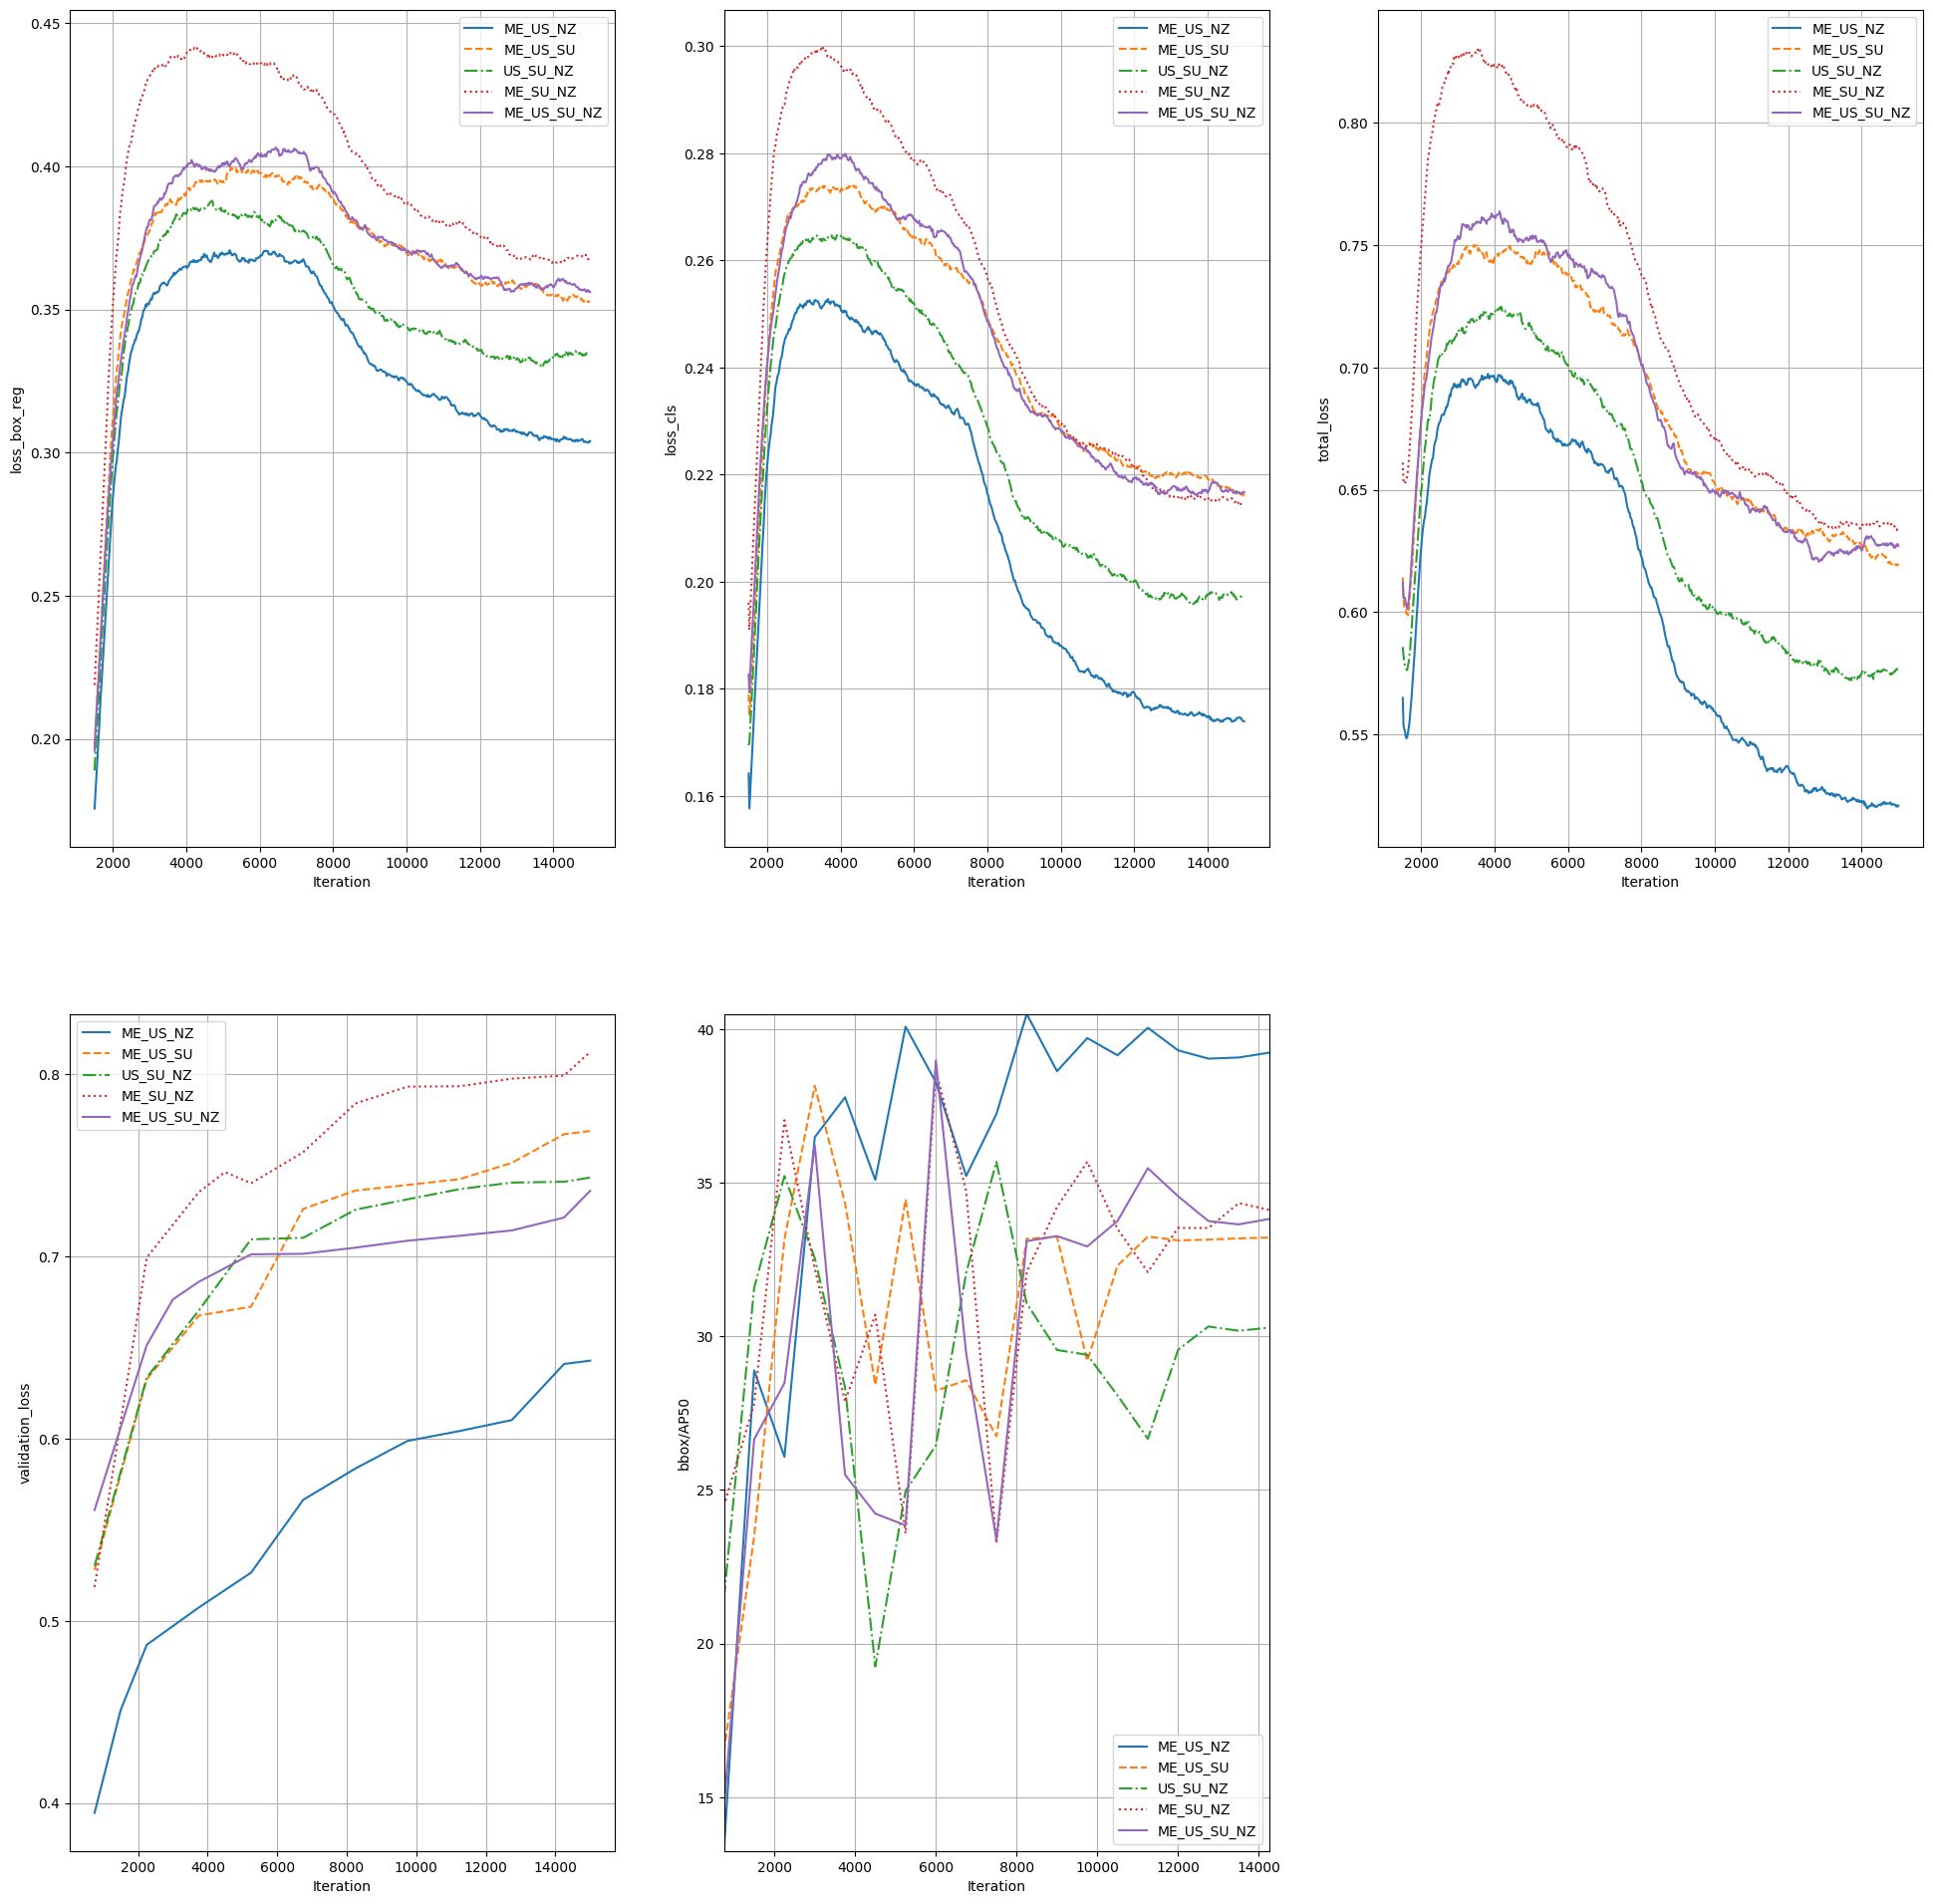

In [326]:
plot_metrics(['/workspace/output/experiment2/leave-one-out/04.23.18.43/ME_US_NZ',
             '/workspace/output/experiment2/leave-one-out/04.23.18.43/ME_US_SU',
             '/workspace/output/experiment2/leave-one-out/04.23.18.43/US_SU_NZ',
             '/workspace/output/experiment2/leave-one-out/04.23.18.43/ME_SU_NZ',
             '/workspace/output/experiment2/leave-one-out/04.23.18.43/ME_US_SU_NZ'],
             ['ME_US_NZ', 'ME_US_SU', 'US_SU_NZ', 'ME_SU_NZ', 'ME_US_SU_NZ'])



## Evaluate on Test sets

In [226]:


def evaluate_detectron_loo(config_dict = None, 
                         default_dict = None,
                         resolution = "res_missing",
                         output_dir_prefix = None,
                         dataset_name_train = '030_train',
                        dataset_name_val = '030_val',
                        comb = None,
                        country = None,
                        best_model_path = None
                        ):
    
    """
    func: trains a detectron model on one country 
    
    inputs:
        - dataset_name_train: name of the coco registered training dataset
        - dataset_name_val:   name of the coco registered validation dataset
        - resolution:         input resolution of the images
        - iterations:         number of iterations the model should train
        - eval_period:        (default = None) number of iterations after which the model is evaluated on the train set
        - batch_size:         (default = 8)
        - anchors:            (default = [[4, 8, 16, 32, 64]]) size of the ROI heads proposals 
        - weight_decay:       (default = 0.0001) regularization (float)
        - solver_steps_divider(default = 10) after what fraction of the number of iterations the LR is multiplied by 0.1
        
    returns: 
        - cfg object
        - trainer object
        - predictor object
    """
    
    if comb is None:
        return "You did not pass a country combo"

    if config_dict is None:
        config_dict = {}
    if default_dict is None:
        default_dict = {
            'eval_period': None,
            'learning_rate': 0.001,
            'batch_size': 8,
            'anchors': [[4, 8, 16, 32, 64]],
            'weight_decay': 0.0001,
            'solver_steps_divider': 10,
            'freeze_at': 2,
            'gradient_clipping': False}

    # Merge default_dict with my_dict, overriding any duplicate keys
    config = {**default_dict, **config_dict}
    
    print(config)
    
    register(dataset_name_train, f"/workspace/data/countries/leave-one-out-johannes/{comb}_labels_train.json" , f"/workspace/data/data_030_mexico_60-90/train/data")
    register(dataset_name_val, f"/workspace/data/countries/test_{country}_labels.json",  f"/workspace/data/data_030_mexico_60-90/test/data")
    
    
    if output_dir_prefix:
        now = datetime.now() 
        output_dir = f"/workspace/output/{output_dir_prefix}/{country}"
    else:
        now = datetime.now() 
        output_dir = f"/workspace/output/res{resolution}_{now.strftime('%m.%d.%H.%M')}"
        
    #create_local_process_group(num_workers_per_machine=2)
    
    # batchsize * iterations
    views = 75000
    
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
    cfg.INPUT.FORMAT = "RGB"
    
    cfg.OUTPUT_DIR = output_dir
    print("Output Dir:", cfg.OUTPUT_DIR)
    cfg.DATASETS.TRAIN = (dataset_name_train)
    cfg.DATASETS.TEST = (dataset_name_val,)
    cfg.DATASETS.EVAL = (dataset_name_val,)
    
    
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.ANCHOR_GENERATOR.SIZES = config['anchors']
    cfg.SOLVER.MAX_ITER = round(views/config['batch_size'])
    cfg.TEST.EVAL_PERIOD = cfg.SOLVER.MAX_ITER / 10 # für unseren Evaluator

    cfg.SOLVER.IMS_PER_BATCH = config['batch_size']
    cfg.SOLVER.BASE_LR = config['learning_rate']
    cfg.SOLVER.WEIGHT_DECAY = config['weight_decay']
    cfg.SOLVER.CLIP_GRADIENTS.ENABLED = config['gradient_clipping']
    cfg.SOLVER.STEPS = [.5*cfg.SOLVER.MAX_ITER, .75*cfg.SOLVER.MAX_ITER, .9*cfg.SOLVER.MAX_ITER]
    #print(cfg.SOLVER.STEPS)
    
    cfg.MODEL.BACKBONE.FREEZE_AT = config['freeze_at']
    
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
    cfg.TEST.DETECTIONS_PER_IMAGE = 30
    
    cfg.MODEL.WEIGHTS = best_model_path

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    
    trainer = MyTrainer_sampled(cfg)
    trainer.resume_or_load(resume=True)
    
    evaluator = COCOEvaluator(dataset_name_val, cfg, False, output_dir="/workspace/final_test",max_dets_per_image = 30)
    val_loader = build_detection_test_loader(cfg, dataset_name_val)
    
    
    
    return inference_on_dataset(trainer.model, val_loader, evaluator)


In [327]:
config1 = {'learning_rate': 0.001, 
              'batch_size': 5, 
              'gradient_clipping': True, 
              'weight_decay': 0.001, 
              'freeze_at': 1, 
              'index': 8}

test_dict_loo = {}

for country_model, country_comb in zip(['/workspace/output/experiment2/leave-one-out/04.23.18.43/ME_US_NZ',
             '/workspace/output/experiment2/leave-one-out/04.23.18.43/ME_US_SU',
             '/workspace/output/experiment2/leave-one-out/04.23.18.43/US_SU_NZ',
             '/workspace/output/experiment2/leave-one-out/04.23.18.43/ME_SU_NZ',
              '/workspace/output/experiment2/leave-one-out/04.23.18.43/ME_US_SU_NZ'],
             ['ME_US_NZ', 'ME_US_SU', 'US_SU_NZ', 'ME_SU_NZ', 'ME_US_SU_NZ']):
    
    tested = {}
    for country_test in ['Mexico', 'NZ', 'China', 'USA', 'Sudan']:
        
        print("testing: ", country_test, "on ", country_comb)
        aps =  evaluate_detectron_loo(config1,
                         resolution = "030",
                         output_dir_prefix = 'exp2/output_test_eval_mittwoch',
                         dataset_name_train = '030_train',
                        dataset_name_val = '030_val',
                        comb = country_comb,
                        country = country_test,
                        best_model_path = f"{country_model}/best_ap50.pth"
                        )


        tested[country_test] = aps['bbox']['AP50']
    test_dict_loo[country_comb] = tested
    

testing:  Mexico on  ME_US_NZ
{'eval_period': None, 'learning_rate': 0.001, 'batch_size': 5, 'anchors': [[4, 8, 16, 32, 64]], 'weight_decay': 0.001, 'solver_steps_divider': 10, 'freeze_at': 1, 'gradient_clipping': True, 'index': 8}
Output Dir: /workspace/output/exp2/output_test_eval_mittwoch/Mexico
[04/24 15:50:37 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1)

WARNING [04/24 15:50:37 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:50:37 d2.data.datasets.coco]: Loaded 4500 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_US_NZ_labels_train.json
[04/24 15:50:37 d2.data.build]: Removed 353 images with no usable annotations. 4147 images left.
[04/24 15:50:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 15:50:37 d2.data.common]: Serializing 4147 elements to byte tensors and concatenating them all ...
[04/24 15:50:37 d2.data.common]: Serialized dataset takes 1.63 MiB
[04/24 15:50:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/2

WARNING [04/24 15:50:37 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/24 15:50:37 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:50:37 d2.data.datasets.coco]: Loaded 1043 images in COCO format from /workspace/data/countries/test_Mexico_labels.json
[04/24 15:50:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 15:50:37 d2.data.common]: Serializing 1043 elements to byte tensors and concatenating them all ...
[04/24 15:50:37 d2.data.common]: Serialized dataset takes 0.48 MiB
[04/24 15:50:37 d2.evaluation.evaluator]: Start inference on 1043 batches
[04/24 15:50:38 d2.evaluation.evaluator]: Inference done 11/1043. Dataloading: 0.0008 s/iter. Inference: 0.0367 s/iter. Eval: 0.0002 s/it

WARNING [04/24 15:51:17 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:51:17 d2.data.datasets.coco]: Loaded 4500 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_US_NZ_labels_train.json
[04/24 15:51:17 d2.data.build]: Removed 353 images with no usable annotations. 4147 images left.
[04/24 15:51:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 15:51:17 d2.data.common]: Serializing 4147 elements to byte tensors and concatenating them all ...
[04/24 15:51:17 d2.data.common]: Serialized dataset takes 1.63 MiB
[04/24 15:51:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/2

WARNING [04/24 15:51:17 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/24 15:51:17 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:51:17 d2.data.datasets.coco]: Loaded 191 images in COCO format from /workspace/data/countries/test_NZ_labels.json
[04/24 15:51:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 15:51:17 d2.data.common]: Serializing 191 elements to byte tensors and concatenating them all ...
[04/24 15:51:17 d2.data.common]: Serialized dataset takes 0.06 MiB
[04/24 15:51:17 d2.evaluation.evaluator]: Start inference on 191 batches
[04/24 15:51:18 d2.evaluation.evaluator]: Inference done 18/191. Dataloading: 0.0009 s/iter. Inference: 0.0347 s/iter. Eval: 0.0002 s/iter. Tota

WARNING [04/24 15:51:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:51:25 d2.data.datasets.coco]: Loaded 4500 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_US_NZ_labels_train.json
[04/24 15:51:25 d2.data.build]: Removed 353 images with no usable annotations. 4147 images left.
[04/24 15:51:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 15:51:25 d2.data.common]: Serializing 4147 elements to byte tensors and concatenating them all ...
[04/24 15:51:25 d2.data.common]: Serialized dataset takes 1.63 MiB
[04/24 15:51:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/2

WARNING [04/24 15:51:26 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/24 15:51:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:51:26 d2.data.datasets.coco]: Loaded 104 images in COCO format from /workspace/data/countries/test_China_labels.json
[04/24 15:51:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 15:51:26 d2.data.common]: Serializing 104 elements to byte tensors and concatenating them all ...
[04/24 15:51:26 d2.data.common]: Serialized dataset takes 0.04 MiB
[04/24 15:51:26 d2.evaluation.evaluator]: Start inference on 104 batches
[04/24 15:51:28 d2.evaluation.evaluator]: Inference done 69/104. Dataloading: 0.0010 s/iter. Inference: 0.0346 s/iter. Eval: 0.0001 s/iter. T

WARNING [04/24 15:51:30 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:51:30 d2.data.datasets.coco]: Loaded 4500 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_US_NZ_labels_train.json
[04/24 15:51:30 d2.data.build]: Removed 353 images with no usable annotations. 4147 images left.
[04/24 15:51:30 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 15:51:30 d2.data.common]: Serializing 4147 elements to byte tensors and concatenating them all ...
[04/24 15:51:30 d2.data.common]: Serialized dataset takes 1.63 MiB
[04/24 15:51:30 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/2

WARNING [04/24 15:51:31 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/24 15:51:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:51:31 d2.data.datasets.coco]: Loaded 897 images in COCO format from /workspace/data/countries/test_USA_labels.json
[04/24 15:51:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 15:51:31 d2.data.common]: Serializing 897 elements to byte tensors and concatenating them all ...
[04/24 15:51:31 d2.data.common]: Serialized dataset takes 0.33 MiB
[04/24 15:51:31 d2.evaluation.evaluator]: Start inference on 897 batches
[04/24 15:51:33 d2.evaluation.evaluator]: Inference done 65/897. Dataloading: 0.0009 s/iter. Inference: 0.0344 s/iter. Eval: 0.0001 s/iter. Tot

WARNING [04/24 15:52:04 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:52:04 d2.data.datasets.coco]: Loaded 4500 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_US_NZ_labels_train.json
[04/24 15:52:04 d2.data.build]: Removed 353 images with no usable annotations. 4147 images left.
[04/24 15:52:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 15:52:04 d2.data.common]: Serializing 4147 elements to byte tensors and concatenating them all ...
[04/24 15:52:04 d2.data.common]: Serialized dataset takes 1.63 MiB
[04/24 15:52:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/2

WARNING [04/24 15:52:05 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:52:05 d2.data.datasets.coco]: Loaded 466 images in COCO format from /workspace/data/countries/test_Sudan_labels.json
[04/24 15:52:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 15:52:05 d2.data.common]: Serializing 466 elements to byte tensors and concatenating them all ...
[04/24 15:52:05 d2.data.common]: Serialized dataset takes 0.33 MiB
[04/24 15:52:05 d2.evaluation.evaluator]: Start inference on 466 batches
[04/24 15:52:05 d2.evaluation.evaluator]: Inference done 11/466. Dataloading: 0.0009 s/iter. Inference: 0.0362 s/iter. Eval: 0.0001 s/iter. Total: 0.0372 s/iter. ETA=0:00:16
[04/24 15:52:10 d2.evaluation.evaluator]: Inference done 153/466. Dataloading: 0.0010 s/iter. Inference: 0.0343 s/iter. Eval: 0.0001 s/it

WARNING [04/24 15:52:22 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:52:22 d2.data.datasets.coco]: Loaded 4500 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_US_SU_labels_train.json
[04/24 15:52:22 d2.data.build]: Removed 264 images with no usable annotations. 4236 images left.
[04/24 15:52:23 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 15:52:23 d2.data.common]: Serializing 4236 elements to byte tensors and concatenating them all ...
[04/24 15:52:23 d2.data.common]: Serialized dataset takes 2.20 MiB
[04/24 15:52:23 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/2

WARNING [04/24 15:52:23 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/24 15:52:23 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:52:23 d2.data.datasets.coco]: Loaded 1043 images in COCO format from /workspace/data/countries/test_Mexico_labels.json
[04/24 15:52:23 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 15:52:23 d2.data.common]: Serializing 1043 elements to byte tensors and concatenating them all ...
[04/24 15:52:23 d2.data.common]: Serialized dataset takes 0.48 MiB
[04/24 15:52:23 d2.evaluation.evaluator]: Start inference on 1043 batches
[04/24 15:52:25 d2.evaluation.evaluator]: Inference done 54/1043. Dataloading: 0.0009 s/iter. Inference: 0.0345 s/iter. Eval: 0.0002 s/it

WARNING [04/24 15:53:04 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:53:04 d2.data.datasets.coco]: Loaded 4500 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_US_SU_labels_train.json
[04/24 15:53:04 d2.data.build]: Removed 264 images with no usable annotations. 4236 images left.
[04/24 15:53:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 15:53:04 d2.data.common]: Serializing 4236 elements to byte tensors and concatenating them all ...
[04/24 15:53:04 d2.data.common]: Serialized dataset takes 2.20 MiB
[04/24 15:53:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/2

WARNING [04/24 15:53:04 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:53:04 d2.data.datasets.coco]: Loaded 191 images in COCO format from /workspace/data/countries/test_NZ_labels.json
[04/24 15:53:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 15:53:04 d2.data.common]: Serializing 191 elements to byte tensors and concatenating them all ...
[04/24 15:53:04 d2.data.common]: Serialized dataset takes 0.06 MiB
[04/24 15:53:04 d2.evaluation.evaluator]: Start inference on 191 batches
[04/24 15:53:05 d2.evaluation.evaluator]: Inference done 26/191. Dataloading: 0.0010 s/iter. Inference: 0.0355 s/iter. Eval: 0.0001 s/iter. Total: 0.0367 s/iter. ETA=0:00:06
[04/24 15:53:10 d2.evaluation.evaluator]: Inference done 165/191. Dataloading: 0.0010 s/iter. Inference: 0.0349 s/iter. Eval: 0.0002 s/iter.

WARNING [04/24 15:53:12 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:53:12 d2.data.datasets.coco]: Loaded 4500 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_US_SU_labels_train.json
[04/24 15:53:12 d2.data.build]: Removed 264 images with no usable annotations. 4236 images left.
[04/24 15:53:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 15:53:13 d2.data.common]: Serializing 4236 elements to byte tensors and concatenating them all ...
[04/24 15:53:13 d2.data.common]: Serialized dataset takes 2.20 MiB
[04/24 15:53:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/2

WARNING [04/24 15:53:13 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:53:13 d2.data.datasets.coco]: Loaded 104 images in COCO format from /workspace/data/countries/test_China_labels.json
[04/24 15:53:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 15:53:13 d2.data.common]: Serializing 104 elements to byte tensors and concatenating them all ...
[04/24 15:53:13 d2.data.common]: Serialized dataset takes 0.04 MiB
[04/24 15:53:13 d2.evaluation.evaluator]: Start inference on 104 batches
[04/24 15:53:16 d2.evaluation.evaluator]: Inference done 74/104. Dataloading: 0.0010 s/iter. Inference: 0.0343 s/iter. Eval: 0.0001 s/iter. Total: 0.0354 s/iter. ETA=0:00:01
[04/24 15:53:17 d2.evaluation.evaluator]: Total inference time: 0:00:03.590516 (0.036268 s / iter per device, on 1 devices)
[04/24 15:53:

WARNING [04/24 15:53:17 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:53:17 d2.data.datasets.coco]: Loaded 4500 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_US_SU_labels_train.json
[04/24 15:53:18 d2.data.build]: Removed 264 images with no usable annotations. 4236 images left.
[04/24 15:53:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 15:53:18 d2.data.common]: Serializing 4236 elements to byte tensors and concatenating them all ...
[04/24 15:53:18 d2.data.common]: Serialized dataset takes 2.20 MiB
[04/24 15:53:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/2

WARNING [04/24 15:53:18 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:53:18 d2.data.datasets.coco]: Loaded 897 images in COCO format from /workspace/data/countries/test_USA_labels.json
[04/24 15:53:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 15:53:18 d2.data.common]: Serializing 897 elements to byte tensors and concatenating them all ...
[04/24 15:53:18 d2.data.common]: Serialized dataset takes 0.33 MiB
[04/24 15:53:18 d2.evaluation.evaluator]: Start inference on 897 batches
[04/24 15:53:21 d2.evaluation.evaluator]: Inference done 63/897. Dataloading: 0.0010 s/iter. Inference: 0.0346 s/iter. Eval: 0.0002 s/iter. Total: 0.0358 s/iter. ETA=0:00:29
[04/24 15:53:26 d2.evaluation.evaluator]: Inference done 203/897. Dataloading: 0.0010 s/iter. Inference: 0.0345 s/iter. Eval: 0.0002 s/iter

WARNING [04/24 15:53:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:53:52 d2.data.datasets.coco]: Loaded 4500 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_US_SU_labels_train.json
[04/24 15:53:53 d2.data.build]: Removed 264 images with no usable annotations. 4236 images left.
[04/24 15:53:53 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 15:53:53 d2.data.common]: Serializing 4236 elements to byte tensors and concatenating them all ...
[04/24 15:53:53 d2.data.common]: Serialized dataset takes 2.20 MiB
[04/24 15:53:53 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/2

WARNING [04/24 15:53:53 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:53:53 d2.data.datasets.coco]: Loaded 466 images in COCO format from /workspace/data/countries/test_Sudan_labels.json
[04/24 15:53:53 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 15:53:53 d2.data.common]: Serializing 466 elements to byte tensors and concatenating them all ...
[04/24 15:53:53 d2.data.common]: Serialized dataset takes 0.33 MiB
[04/24 15:53:53 d2.evaluation.evaluator]: Start inference on 466 batches
[04/24 15:53:54 d2.evaluation.evaluator]: Inference done 11/466. Dataloading: 0.0009 s/iter. Inference: 0.0357 s/iter. Eval: 0.0002 s/iter. Total: 0.0367 s/iter. ETA=0:00:16
[04/24 15:53:59 d2.evaluation.evaluator]: Inference done 151/466. Dataloading: 0.0010 s/iter. Inference: 0.0347 s/iter. Eval: 0.0002 s/it

WARNING [04/24 15:54:13 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:54:13 d2.data.datasets.coco]: Loaded 4500 images in COCO format from /workspace/data/countries/leave-one-out-johannes/US_SU_NZ_labels_train.json
[04/24 15:54:13 d2.data.build]: Removed 359 images with no usable annotations. 4141 images left.
[04/24 15:54:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 15:54:13 d2.data.common]: Serializing 4141 elements to byte tensors and concatenating them all ...
[04/24 15:54:13 d2.data.common]: Serialized dataset takes 2.08 MiB
[04/24 15:54:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/2

WARNING [04/24 15:54:13 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/24 15:54:13 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:54:13 d2.data.datasets.coco]: Loaded 1043 images in COCO format from /workspace/data/countries/test_Mexico_labels.json
[04/24 15:54:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 15:54:13 d2.data.common]: Serializing 1043 elements to byte tensors and concatenating them all ...
[04/24 15:54:13 d2.data.common]: Serialized dataset takes 0.48 MiB
[04/24 15:54:13 d2.evaluation.evaluator]: Start inference on 1043 batches
[04/24 15:54:14 d2.evaluation.evaluator]: Inference done 11/1043. Dataloading: 0.0009 s/iter. Inference: 0.0351 s/iter. Eval: 0.0002 s/it

WARNING [04/24 15:54:53 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:54:53 d2.data.datasets.coco]: Loaded 4500 images in COCO format from /workspace/data/countries/leave-one-out-johannes/US_SU_NZ_labels_train.json
[04/24 15:54:53 d2.data.build]: Removed 359 images with no usable annotations. 4141 images left.
[04/24 15:54:53 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 15:54:53 d2.data.common]: Serializing 4141 elements to byte tensors and concatenating them all ...
[04/24 15:54:53 d2.data.common]: Serialized dataset takes 2.08 MiB
[04/24 15:54:53 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/2

WARNING [04/24 15:54:53 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:54:53 d2.data.datasets.coco]: Loaded 191 images in COCO format from /workspace/data/countries/test_NZ_labels.json
[04/24 15:54:53 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 15:54:53 d2.data.common]: Serializing 191 elements to byte tensors and concatenating them all ...
[04/24 15:54:53 d2.data.common]: Serialized dataset takes 0.06 MiB
[04/24 15:54:53 d2.evaluation.evaluator]: Start inference on 191 batches
[04/24 15:54:54 d2.evaluation.evaluator]: Inference done 15/191. Dataloading: 0.0010 s/iter. Inference: 0.0351 s/iter. Eval: 0.0002 s/iter. Total: 0.0363 s/iter. ETA=0:00:06
[04/24 15:54:59 d2.evaluation.evaluator]: Inference done 155/191. Dataloading: 0.0010 s/iter. Inference: 0.0346 s/iter. Eval: 0.0001 s/iter.

WARNING [04/24 15:55:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:55:02 d2.data.datasets.coco]: Loaded 4500 images in COCO format from /workspace/data/countries/leave-one-out-johannes/US_SU_NZ_labels_train.json
[04/24 15:55:02 d2.data.build]: Removed 359 images with no usable annotations. 4141 images left.
[04/24 15:55:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 15:55:02 d2.data.common]: Serializing 4141 elements to byte tensors and concatenating them all ...
[04/24 15:55:02 d2.data.common]: Serialized dataset takes 2.08 MiB
[04/24 15:55:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/2

WARNING [04/24 15:55:02 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/24 15:55:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:55:02 d2.data.datasets.coco]: Loaded 104 images in COCO format from /workspace/data/countries/test_China_labels.json
[04/24 15:55:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 15:55:02 d2.data.common]: Serializing 104 elements to byte tensors and concatenating them all ...
[04/24 15:55:02 d2.data.common]: Serialized dataset takes 0.04 MiB
[04/24 15:55:02 d2.evaluation.evaluator]: Start inference on 104 batches
[04/24 15:55:04 d2.evaluation.evaluator]: Inference done 54/104. Dataloading: 0.0010 s/iter. Inference: 0.0349 s/iter. Eval: 0.0002 s/iter. T

WARNING [04/24 15:55:07 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:55:07 d2.data.datasets.coco]: Loaded 4500 images in COCO format from /workspace/data/countries/leave-one-out-johannes/US_SU_NZ_labels_train.json
[04/24 15:55:07 d2.data.build]: Removed 359 images with no usable annotations. 4141 images left.
[04/24 15:55:07 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 15:55:07 d2.data.common]: Serializing 4141 elements to byte tensors and concatenating them all ...
[04/24 15:55:07 d2.data.common]: Serialized dataset takes 2.08 MiB
[04/24 15:55:07 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/2

WARNING [04/24 15:55:07 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/24 15:55:07 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:55:07 d2.data.datasets.coco]: Loaded 897 images in COCO format from /workspace/data/countries/test_USA_labels.json
[04/24 15:55:07 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 15:55:07 d2.data.common]: Serializing 897 elements to byte tensors and concatenating them all ...
[04/24 15:55:07 d2.data.common]: Serialized dataset takes 0.33 MiB
[04/24 15:55:07 d2.evaluation.evaluator]: Start inference on 897 batches
[04/24 15:55:09 d2.evaluation.evaluator]: Inference done 47/897. Dataloading: 0.0009 s/iter. Inference: 0.0348 s/iter. Eval: 0.0002 s/iter. Tot

WARNING [04/24 15:55:42 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:55:42 d2.data.datasets.coco]: Loaded 4500 images in COCO format from /workspace/data/countries/leave-one-out-johannes/US_SU_NZ_labels_train.json
[04/24 15:55:42 d2.data.build]: Removed 359 images with no usable annotations. 4141 images left.
[04/24 15:55:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 15:55:42 d2.data.common]: Serializing 4141 elements to byte tensors and concatenating them all ...
[04/24 15:55:42 d2.data.common]: Serialized dataset takes 2.08 MiB
[04/24 15:55:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/2

WARNING [04/24 15:55:42 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:55:42 d2.data.datasets.coco]: Loaded 466 images in COCO format from /workspace/data/countries/test_Sudan_labels.json
[04/24 15:55:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 15:55:42 d2.data.common]: Serializing 466 elements to byte tensors and concatenating them all ...
[04/24 15:55:42 d2.data.common]: Serialized dataset takes 0.33 MiB
[04/24 15:55:42 d2.evaluation.evaluator]: Start inference on 466 batches
[04/24 15:55:44 d2.evaluation.evaluator]: Inference done 48/466. Dataloading: 0.0011 s/iter. Inference: 0.0348 s/iter. Eval: 0.0002 s/iter. Total: 0.0361 s/iter. ETA=0:00:15
[04/24 15:55:49 d2.evaluation.evaluator]: Inference done 188/466. Dataloading: 0.0010 s/iter. Inference: 0.0346 s/iter. Eval: 0.0002 s/it

WARNING [04/24 15:56:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:56:02 d2.data.datasets.coco]: Loaded 4500 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_SU_NZ_labels_train.json
[04/24 15:56:02 d2.data.build]: Removed 92 images with no usable annotations. 4408 images left.
[04/24 15:56:03 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 15:56:03 d2.data.common]: Serializing 4408 elements to byte tensors and concatenating them all ...
[04/24 15:56:03 d2.data.common]: Serialized dataset takes 2.30 MiB
[04/24 15:56:03 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/24

WARNING [04/24 15:56:03 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/24 15:56:03 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:56:03 d2.data.datasets.coco]: Loaded 1043 images in COCO format from /workspace/data/countries/test_Mexico_labels.json
[04/24 15:56:03 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 15:56:03 d2.data.common]: Serializing 1043 elements to byte tensors and concatenating them all ...
[04/24 15:56:03 d2.data.common]: Serialized dataset takes 0.48 MiB
[04/24 15:56:03 d2.evaluation.evaluator]: Start inference on 1043 batches
[04/24 15:56:04 d2.evaluation.evaluator]: Inference done 35/1043. Dataloading: 0.0009 s/iter. Inference: 0.0343 s/iter. Eval: 0.0002 s/it

WARNING [04/24 15:56:42 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:56:42 d2.data.datasets.coco]: Loaded 4500 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_SU_NZ_labels_train.json
[04/24 15:56:43 d2.data.build]: Removed 92 images with no usable annotations. 4408 images left.
[04/24 15:56:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 15:56:43 d2.data.common]: Serializing 4408 elements to byte tensors and concatenating them all ...
[04/24 15:56:43 d2.data.common]: Serialized dataset takes 2.30 MiB
[04/24 15:56:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/24

WARNING [04/24 15:56:43 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:56:43 d2.data.datasets.coco]: Loaded 191 images in COCO format from /workspace/data/countries/test_NZ_labels.json
[04/24 15:56:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 15:56:43 d2.data.common]: Serializing 191 elements to byte tensors and concatenating them all ...
[04/24 15:56:43 d2.data.common]: Serialized dataset takes 0.06 MiB
[04/24 15:56:43 d2.evaluation.evaluator]: Start inference on 191 batches
[04/24 15:56:44 d2.evaluation.evaluator]: Inference done 39/191. Dataloading: 0.0010 s/iter. Inference: 0.0348 s/iter. Eval: 0.0001 s/iter. Total: 0.0360 s/iter. ETA=0:00:05
[04/24 15:56:49 d2.evaluation.evaluator]: Inference done 179/191. Dataloading: 0.0010 s/iter. Inference: 0.0347 s/iter. Eval: 0.0001 s/iter.

WARNING [04/24 15:56:51 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:56:51 d2.data.datasets.coco]: Loaded 4500 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_SU_NZ_labels_train.json
[04/24 15:56:51 d2.data.build]: Removed 92 images with no usable annotations. 4408 images left.
[04/24 15:56:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 15:56:51 d2.data.common]: Serializing 4408 elements to byte tensors and concatenating them all ...
[04/24 15:56:51 d2.data.common]: Serialized dataset takes 2.30 MiB
[04/24 15:56:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/24

WARNING [04/24 15:56:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:56:52 d2.data.datasets.coco]: Loaded 104 images in COCO format from /workspace/data/countries/test_China_labels.json
[04/24 15:56:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 15:56:52 d2.data.common]: Serializing 104 elements to byte tensors and concatenating them all ...
[04/24 15:56:52 d2.data.common]: Serialized dataset takes 0.04 MiB
[04/24 15:56:52 d2.evaluation.evaluator]: Start inference on 104 batches
[04/24 15:56:55 d2.evaluation.evaluator]: Inference done 78/104. Dataloading: 0.0010 s/iter. Inference: 0.0348 s/iter. Eval: 0.0001 s/iter. Total: 0.0360 s/iter. ETA=0:00:00
[04/24 15:56:56 d2.evaluation.evaluator]: Total inference time: 0:00:03.648267 (0.036851 s / iter per device, on 1 devices)
[04/24 15:56:

WARNING [04/24 15:56:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:56:56 d2.data.datasets.coco]: Loaded 4500 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_SU_NZ_labels_train.json
[04/24 15:56:56 d2.data.build]: Removed 92 images with no usable annotations. 4408 images left.
[04/24 15:56:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 15:56:57 d2.data.common]: Serializing 4408 elements to byte tensors and concatenating them all ...
[04/24 15:56:57 d2.data.common]: Serialized dataset takes 2.30 MiB
[04/24 15:56:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/24

WARNING [04/24 15:56:57 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:56:57 d2.data.datasets.coco]: Loaded 897 images in COCO format from /workspace/data/countries/test_USA_labels.json
[04/24 15:56:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 15:56:57 d2.data.common]: Serializing 897 elements to byte tensors and concatenating them all ...
[04/24 15:56:57 d2.data.common]: Serialized dataset takes 0.33 MiB
[04/24 15:56:57 d2.evaluation.evaluator]: Start inference on 897 batches
[04/24 15:57:00 d2.evaluation.evaluator]: Inference done 73/897. Dataloading: 0.0010 s/iter. Inference: 0.0344 s/iter. Eval: 0.0001 s/iter. Total: 0.0355 s/iter. ETA=0:00:29
[04/24 15:57:05 d2.evaluation.evaluator]: Inference done 212/897. Dataloading: 0.0010 s/iter. Inference: 0.0348 s/iter. Eval: 0.0001 s/iter

WARNING [04/24 15:57:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:57:31 d2.data.datasets.coco]: Loaded 4500 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_SU_NZ_labels_train.json
[04/24 15:57:31 d2.data.build]: Removed 92 images with no usable annotations. 4408 images left.
[04/24 15:57:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 15:57:31 d2.data.common]: Serializing 4408 elements to byte tensors and concatenating them all ...
[04/24 15:57:31 d2.data.common]: Serialized dataset takes 2.30 MiB
[04/24 15:57:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [04/24

WARNING [04/24 15:57:31 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/24 15:57:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:57:31 d2.data.datasets.coco]: Loaded 466 images in COCO format from /workspace/data/countries/test_Sudan_labels.json
[04/24 15:57:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 15:57:31 d2.data.common]: Serializing 466 elements to byte tensors and concatenating them all ...
[04/24 15:57:31 d2.data.common]: Serialized dataset takes 0.33 MiB
[04/24 15:57:31 d2.evaluation.evaluator]: Start inference on 466 batches
[04/24 15:57:32 d2.evaluation.evaluator]: Inference done 11/466. Dataloading: 0.0008 s/iter. Inference: 0.0363 s/iter. Eval: 0.0002 s/iter. T

WARNING [04/24 15:57:51 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:57:51 d2.data.datasets.coco]: Loaded 4500 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_US_SU_NZ_labels_train.json
[04/24 15:57:51 d2.data.build]: Removed 243 images with no usable annotations. 4257 images left.
[04/24 15:57:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 15:57:51 d2.data.common]: Serializing 4257 elements to byte tensors and concatenating them all ...
[04/24 15:57:51 d2.data.common]: Serialized dataset takes 2.06 MiB
[04/24 15:57:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [0

WARNING [04/24 15:57:51 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/24 15:57:51 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:57:51 d2.data.datasets.coco]: Loaded 1043 images in COCO format from /workspace/data/countries/test_Mexico_labels.json
[04/24 15:57:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 15:57:51 d2.data.common]: Serializing 1043 elements to byte tensors and concatenating them all ...
[04/24 15:57:51 d2.data.common]: Serialized dataset takes 0.48 MiB
[04/24 15:57:51 d2.evaluation.evaluator]: Start inference on 1043 batches
[04/24 15:57:52 d2.evaluation.evaluator]: Inference done 11/1043. Dataloading: 0.0009 s/iter. Inference: 0.0354 s/iter. Eval: 0.0002 s/it

WARNING [04/24 15:58:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:58:31 d2.data.datasets.coco]: Loaded 4500 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_US_SU_NZ_labels_train.json
[04/24 15:58:31 d2.data.build]: Removed 243 images with no usable annotations. 4257 images left.
[04/24 15:58:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 15:58:32 d2.data.common]: Serializing 4257 elements to byte tensors and concatenating them all ...
[04/24 15:58:32 d2.data.common]: Serialized dataset takes 2.06 MiB
[04/24 15:58:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [0

WARNING [04/24 15:58:32 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:58:32 d2.data.datasets.coco]: Loaded 191 images in COCO format from /workspace/data/countries/test_NZ_labels.json
[04/24 15:58:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 15:58:32 d2.data.common]: Serializing 191 elements to byte tensors and concatenating them all ...
[04/24 15:58:32 d2.data.common]: Serialized dataset takes 0.06 MiB
[04/24 15:58:32 d2.evaluation.evaluator]: Start inference on 191 batches
[04/24 15:58:32 d2.evaluation.evaluator]: Inference done 11/191. Dataloading: 0.0008 s/iter. Inference: 0.0344 s/iter. Eval: 0.0002 s/iter. Total: 0.0353 s/iter. ETA=0:00:06
[04/24 15:58:37 d2.evaluation.evaluator]: Inference done 152/191. Dataloading: 0.0009 s/iter. Inference: 0.0343 s/iter. Eval: 0.0001 s/iter.

WARNING [04/24 15:58:40 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:58:40 d2.data.datasets.coco]: Loaded 4500 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_US_SU_NZ_labels_train.json
[04/24 15:58:40 d2.data.build]: Removed 243 images with no usable annotations. 4257 images left.
[04/24 15:58:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 15:58:40 d2.data.common]: Serializing 4257 elements to byte tensors and concatenating them all ...
[04/24 15:58:40 d2.data.common]: Serialized dataset takes 2.06 MiB
[04/24 15:58:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [0

WARNING [04/24 15:58:40 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/24 15:58:40 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:58:40 d2.data.datasets.coco]: Loaded 104 images in COCO format from /workspace/data/countries/test_China_labels.json
[04/24 15:58:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 15:58:40 d2.data.common]: Serializing 104 elements to byte tensors and concatenating them all ...
[04/24 15:58:40 d2.data.common]: Serialized dataset takes 0.04 MiB
[04/24 15:58:40 d2.evaluation.evaluator]: Start inference on 104 batches
[04/24 15:58:42 d2.evaluation.evaluator]: Inference done 61/104. Dataloading: 0.0009 s/iter. Inference: 0.0345 s/iter. Eval: 0.0001 s/iter. T

WARNING [04/24 15:58:45 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:58:45 d2.data.datasets.coco]: Loaded 4500 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_US_SU_NZ_labels_train.json
[04/24 15:58:45 d2.data.build]: Removed 243 images with no usable annotations. 4257 images left.
[04/24 15:58:45 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 15:58:45 d2.data.common]: Serializing 4257 elements to byte tensors and concatenating them all ...
[04/24 15:58:45 d2.data.common]: Serialized dataset takes 2.06 MiB
[04/24 15:58:45 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [0

WARNING [04/24 15:58:45 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/24 15:58:45 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:58:45 d2.data.datasets.coco]: Loaded 897 images in COCO format from /workspace/data/countries/test_USA_labels.json
[04/24 15:58:45 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 15:58:45 d2.data.common]: Serializing 897 elements to byte tensors and concatenating them all ...
[04/24 15:58:45 d2.data.common]: Serialized dataset takes 0.33 MiB
[04/24 15:58:45 d2.evaluation.evaluator]: Start inference on 897 batches
[04/24 15:58:47 d2.evaluation.evaluator]: Inference done 50/897. Dataloading: 0.0010 s/iter. Inference: 0.0344 s/iter. Eval: 0.0002 s/iter. Tot

WARNING [04/24 15:59:19 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:59:19 d2.data.datasets.coco]: Loaded 4500 images in COCO format from /workspace/data/countries/leave-one-out-johannes/ME_US_SU_NZ_labels_train.json
[04/24 15:59:19 d2.data.build]: Removed 243 images with no usable annotations. 4257 images left.
[04/24 15:59:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 15:59:20 d2.data.common]: Serializing 4257 elements to byte tensors and concatenating them all ...
[04/24 15:59:20 d2.data.common]: Serialized dataset takes 2.06 MiB
[04/24 15:59:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
WARNING [0

WARNING [04/24 15:59:20 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/24 15:59:20 d2.data.datasets.coco]: Loaded 466 images in COCO format from /workspace/data/countries/test_Sudan_labels.json
[04/24 15:59:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/24 15:59:20 d2.data.common]: Serializing 466 elements to byte tensors and concatenating them all ...
[04/24 15:59:20 d2.data.common]: Serialized dataset takes 0.33 MiB
[04/24 15:59:20 d2.evaluation.evaluator]: Start inference on 466 batches
[04/24 15:59:23 d2.evaluation.evaluator]: Inference done 65/466. Dataloading: 0.0010 s/iter. Inference: 0.0342 s/iter. Eval: 0.0002 s/iter. Total: 0.0353 s/iter. ETA=0:00:14
[04/24 15:59:28 d2.evaluation.evaluator]: Inference done 207/466. Dataloading: 0.0010 s/iter. Inference: 0.0342 s/iter. Eval: 0.0002 s/it

In [328]:
#os.makedirs(f"/workspace/output/experiment2/leave-one-out/{now.strftime('%m.%d.%H.%M')}/")
with open(f"/workspace/output/experiment2/leave-one-out/{now.strftime('%m.%d.%H.%M')}/test_set_evals.json", 'w') as f:
        json.dump(test_dict_loo, f)

In [329]:
test_dict_loo

{'ME_US_NZ': {'Mexico': 8.225464013558764,
  'NZ': 36.17967957801338,
  'China': 0.03337412392924686,
  'USA': 32.56507099952483,
  'Sudan': 0.09249468636184006},
 'ME_US_SU': {'Mexico': 8.20296391170906,
  'NZ': 1.5893944114263587,
  'China': 0.3274095126427677,
  'USA': 24.994692262885692,
  'Sudan': 43.266163095976516},
 'US_SU_NZ': {'Mexico': 1.2257366020724283,
  'NZ': 38.601510577683776,
  'China': 3.239803112056626,
  'USA': 27.725318937687643,
  'Sudan': 46.14945451769991},
 'ME_SU_NZ': {'Mexico': 6.033330619074364,
  'NZ': 31.124945347036903,
  'China': 2.4225822456081683,
  'USA': 2.177569663548317,
  'Sudan': 40.68781622895762},
 'ME_US_SU_NZ': {'Mexico': 8.132261373387607,
  'NZ': 31.499575540240045,
  'China': 1.9187829320731586,
  'USA': 28.19594716214529,
  'Sudan': 42.97458403190868}}

In [348]:
y_labels = []
countries = ["Mexico", "USA", "Sudan", "New Zealand"]
for comb in itertools.combinations(countries, 3):
    label_str = ''
    for c in comb:
        label_str += c + '\n'
    y_labels.append(label_str)
y_labels.append('Mexico\nNZ\nUSA\nSudan')
print(y_labels)

['Mexico\nUSA\nSudan\n', 'Mexico\nUSA\nNew Zealand\n', 'Mexico\nSudan\nNew Zealand\n', 'USA\nSudan\nNew Zealand\n', 'Mexico\nNZ\nUSA\nSudan']


In [350]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re

keys = list(test_dict_loo.keys())
inner_keys = ['Sudan', 'NZ', 'Mexico', 'USA', 'China']
values = np.array([[test_dict_loo[key][inner_key] for inner_key in inner_keys] for key in keys])

# Identify inner keys that are not part of the combination of first two letters of the keys
non_matching_inner_keys = [[inner_key for inner_key in inner_keys if not inner_key[:2].upper() in key] for key in keys]
print(non_matching_inner_keys)
# Create a mask to highlight the non-matching inner keys with a red box
mask = np.zeros_like(values, dtype=bool)
for i, key in enumerate(keys):
    for j, inner_key in enumerate(inner_keys):
        if inner_key in non_matching_inner_keys[i]:
            mask[i, j] = True

# Create heatmap
plt.figure(figsize=(10, 8))
# # Draw red boxes around the non-matching inner keys
# for i, key in enumerate(keys):
#     for j, inner_key in enumerate(inner_keys):
#         if mask[i, j]:
#             plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill = False, edgecolor='red', lw=2))
y_labels = ['Mexico\nUSA\nNew Zealand\n',
            'Mexico\nUSA\nSudan\n', 'USA\nSudan\nNew Zealand\n',
            'Mexico\nSudan\nNew Zealand\n', 
            'Mexico\nNew Zealand\nUSA\nSudan']


sns.heatmap(values, annot=True, cmap="viridis", cbar=True, xticklabels=inner_keys, yticklabels=y_labels)#, mask=mask)
plt.yticks(rotation = 0)
plt.ylabel('Model')
plt.xlabel('Test Set (AP50 Score)')

plt.savefig('/workspace/figures/exp2_leave_one_out', bbox_inches = 'tight')
plt.show()

[['Sudan', 'China'], ['NZ', 'China'], ['Mexico', 'China'], ['USA', 'China'], ['China']]


In [331]:
torch.cuda.empty_cache()

## visualize predictions

In [ ]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode

import random
import cv2
import matplotlib.pyplot as plt

def plot_sample(dataset_name, n=1):
    
    """
    Plots a random sample of images and annotations from a Detectron2 dataset.

    Args:
    - dataset_name (str): the name of the dataset registered with Detectron2.
    - n (int): the number of images to plot. Default is 1.

    Returns:
    - None
    """
    
    dataset_custom = DatasetCatalog.get(dataset_name)
    dataset_custom_metadata = MetadataCatalog.get(dataset_name)
    image_filepaths = random.sample(dataset_custom, n)
    for s in image_filepaths:
        
        img = cv2.imread(s["file_name"])
        v = Visualizer(img[:, :, ::-1], metadata=dataset_custom_metadata, scale=0.5)
        v = v.draw_dataset_dict(s)
        plt.figure(figsize=(12,12))
        plt.imshow(v.get_image())
        return plt.show()
    
    
def plot_prediction(dataset_name, predictor, n=1):
    
    """
    Plots a random image from a Detectron2 dataset and its corresponding predictions generated by the provided predictor.

    Args:
    - dataset_name (str): the name of the dataset registered with Detectron2.
    - predictor: a Detectron2 predictor object that takes an image as input and generates predictions.
    - n (int): the number of images to plot. Default is 1.

    Returns:
    - None
    """
    
    dataset_custom = DatasetCatalog.get(dataset_name)
    dataset_custom_metadata = MetadataCatalog.get(dataset_name)
    image_filepaths = random.sample(dataset_custom, n)
    print(len(image_filepaths))
    
    for s in image_filepaths: 
        im = cv2.imread(s["file_name"])
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 12))
        
        
        v = Visualizer(im[:, :, ::-1], metadata=dataset_custom_metadata, scale=0.5)
        v = v.draw_dataset_dict(s)
        ax[0].imshow(v.get_image())
        ax[0].axis('off')
        ax[0].set_title('Original Image')     
        
        
        outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
        v = Visualizer(im,#[:, :, ::-1],
                       metadata= MetadataCatalog.get(dataset_name), 
                       scale=0.5 
                       #,instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
        )
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        
        ax[1].imshow(out.get_image()[:, :, ::-1])
        ax[1].axis('off')
        ax[1].set_title('Predicted Image')

    return plt.show()
    

In [ ]:
plot_prediction(dataset_name_train, predictor_obj, 5)

# Plotting Curves together for paper

In [355]:
## for paper & individual saving


import seaborn as sns
colors = sns.color_palette('colorblind',  as_cmap=True)

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

ltys = ['-','--','-.',':']
resolution_set = ['030','035','040','045','050','070','100']

def save_metrics(plotting_files, 
                 resolution_set, 
                window_divider = 10,   # divides the number of iterations for averaging window set
                losses = ['loss_box_reg', 'loss_cls', 'total_loss', 'validation_loss', 'bbox/AP50']): 
    ap50_max = []
    ap50_last = []

    plt.figure(figsize = (12,8))    
    for n, loss in enumerate(losses):
        #plt.subplot(2,3,n+1)

        l = 0
        for latest_file, res in zip(plotting_files, resolution_set):
            

            experiment_metrics = load_json_arr(latest_file + f'/metrics.json')

            # Extract the values for the specified loss
            loss_values = [x[loss] for x in experiment_metrics if loss in x]

            if loss not in ['validation_loss','bbox/AP50'] and window_divider >0:
                window_size = round(len(loss_values)/window_divider)

                # Calculate the rolling average of the loss over a specified window size
                loss_avg = np.convolve(loss_values, np.ones(window_size) / window_size, mode='valid')            
                plt.plot(
                    [x['iteration'] for x in experiment_metrics if loss in x][window_size-1:], 
                    loss_avg, 
                    label = res,
                    color = colors[l],
                    linestyle = ltys[0],
                    alpha = 1
                )
                plt.xlabel('Iteration')
                plt.ylabel(loss)
                #plt.title(loss)
                #plt.grid()

            else: 
                plt.plot(
                    [x['iteration'] for x in experiment_metrics if loss in x and 'validation_loss' in x], 
                    [x[loss] for x in experiment_metrics if loss in x and 'validation_loss' in x], 
                    label = f"{res}  ",#_v",
                    linestyle = ltys[len(losses)-1],
                    color = colors[l],
                    alpha = 1
                )
                plt.xlabel('Iteration')
                plt.ylabel(loss)
                #plt.title(loss)
                
                #plt.grid()
            l += 1

        #plt.gca().set_axis_off()
    plt.legend(ncol = len(losses))
    plt.grid()
    plt.savefig(f"/workspace/figures/exp2_LOO_loss_curves_{str.replace(loss, '/','')}", 
            bbox_inches = 'tight',
            pad_inches = .25)
    plt.show()

    
    return 


# plotting_files = ['/workspace/output/experiment2_Mexico_04.22.10.10/Mexico',
#              '/workspace/output/experiment2_NZ_04.16.22.29/NZ',
#              '/workspace/output/experiment2_USA_04.16.23.28/USA',
#              '/workspace/output/experiment2_Sudan_04.17.00.28/Sudan']

# countries = ['Mexico', 'NZ','USA', 'Sudan']

plotting_files = ['/workspace/output/experiment2/leave-one-out/04.23.18.43/ME_US_NZ',
             '/workspace/output/experiment2/leave-one-out/04.23.18.43/ME_US_SU',
             '/workspace/output/experiment2/leave-one-out/04.23.18.43/US_SU_NZ',
             '/workspace/output/experiment2/leave-one-out/04.23.18.43/ME_SU_NZ',
              '/workspace/output/experiment2/leave-one-out/04.23.18.43/ME_US_SU_NZ']
countries_combo = ['ME_US_NZ', 'ME_US_SU', 'US_SU_NZ', 'ME_SU_NZ', 'ME_US_SU_NZ']


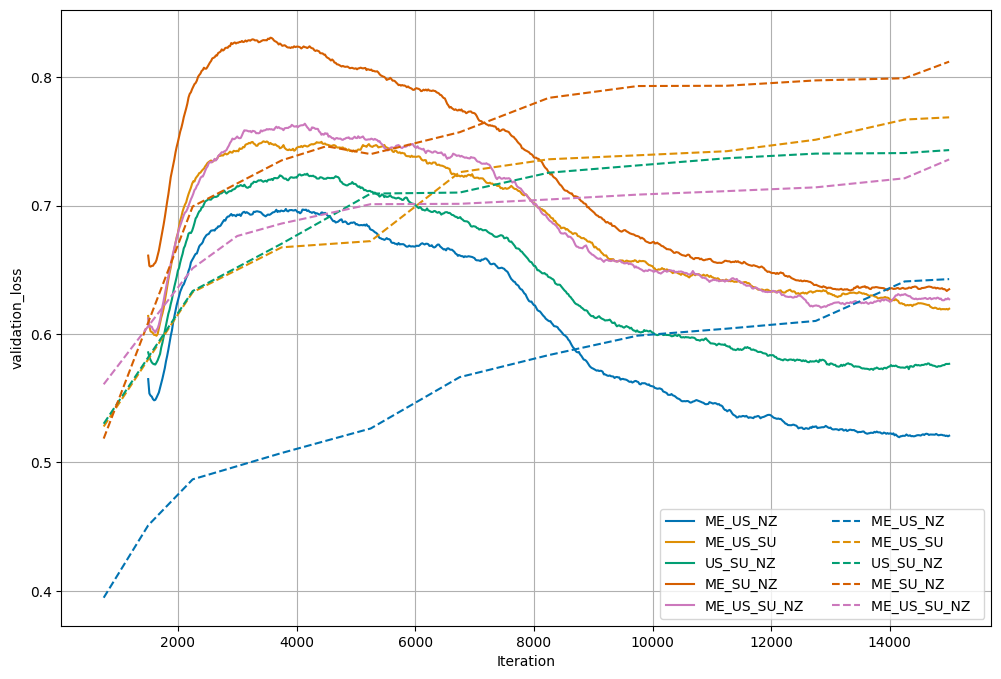

In [356]:
save_metrics(plotting_files, countries_combo, losses = ['total_loss', 'validation_loss'])

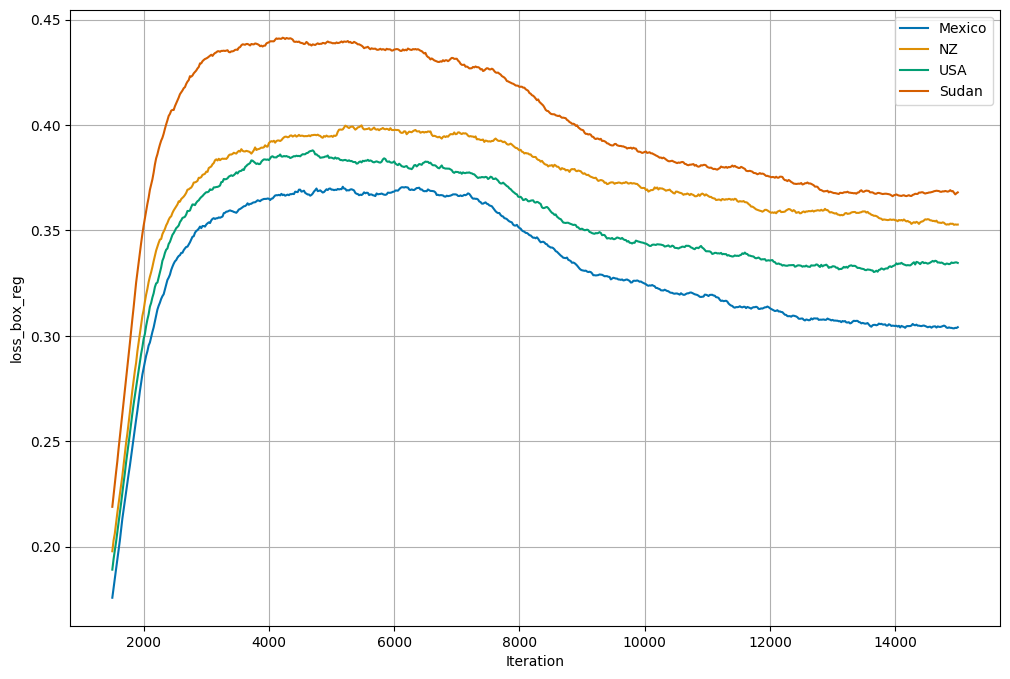

In [357]:
save_metrics(plotting_files, countries, losses = ['loss_box_reg'])

In [358]:
save_metrics(plotting_files, countries, losses = ['loss_cls'])

In [359]:
save_metrics(plotting_files, countries, losses = ['bbox/AP50'])

## Re-Make the Mexican data split

This was used to re-run the experiments with a different train/val/test split. 

In [68]:
# import os
# import shutil

# def duplicate_images_without_ME_prefix(src_folder, dest_folder):
#     """
#     Looks at all the files in `src_folder` that have a file extension of `.jpg` or `.png`.
#     If the file name does not start with "ME", it duplicates the file to `dest_folder`.
#     """
    
        
#     if not os.path.exists(dest_folder):
#         os.makedirs(dest_folder)
        
        
#     for filename in os.listdir(src_folder):
#         if filename.endswith(('.jpg', '.png')) and not filename.startswith("ME"):
#             src_path = os.path.join(src_folder, filename)
#             dest_path = os.path.join(dest_folder)#, filename)
#             print(dest_path)
#             shutil.copy(src_path, dest_folder)
            
# def duplicate_images(src_folder, dest_folder):
#     """
#     Looks at all the files in `src_folder` that have a file extension of `.jpg` or `.png`.
#     If the file name does not start with "ME", it duplicates the file to `dest_folder`.
#     """
    
        
#     if not os.path.exists(dest_folder):
#         os.makedirs(dest_folder)
        
        
#     for filename in os.listdir(src_folder):
#         if filename.endswith(('.jpg', '.png')):
#             src_path = os.path.join(src_folder, filename)
#             dest_path = os.path.join(dest_folder)#, filename)
#             print(dest_path)
#             shutil.copy(src_path, dest_folder)

In [69]:
# for mode in ['train', 'val', 'test']:

#     duplicate_images_without_ME_prefix(f'/workspace/data/data_030/{mode}/data/', 
#                                        f"/workspace/data/data_030_mexico_60-90/{mode}/data")

/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data

/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data

/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data

/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data

/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data

/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data

/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data

/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data

/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data

/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data

/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data

/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data

/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data

/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data

/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data

/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data

/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data

/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data

/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data

/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data

/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data

/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data

/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data

/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data

/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data_030_mexico_60-90/train/data
/workspace/data/data

/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/da

/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/da

/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/da

/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/da

/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/data/data_030_mexico_60-90/val/data
/workspace/da

/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/te

/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/te

/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/te

/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/te

/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/test/data
/workspace/data/data_030_mexico_60-90/te